## ST1504 Deep Learning CA2 

## Part A:  GAN

In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis

In [2]:
df=pd.read_csv('emnist-letters-train.csv')
df

23    0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.406  0.407  \
0       7    0    0    0    0    0    0    0    0    0  ...      0      0   
1      16    0    0    0    0    0    0    0    0    0  ...      0      0   
2      15    0    0    0    0    0    0    0    0    0  ...      0      0   
3      23    0    0    0    0    0    0    0    0    0  ...      0      0   
4      17    0    0    0    0    0    0    0    0    0  ...      0      0   
...    ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
99034  18    0    0    0    0    0    0    0    0    0  ...      0      0   
99035  24    0    0    0    0    0    0    0    0    0  ...      0      0   
99036  19    0    0    0    0    0    0    0    0    0  ...      0      0   
99037  -1  174  174  174  174  174  174  174  174  174  ...    174    174   
99038  -1   42   42   42   42   42   42   42   42   42  ...     42     42   

       0.408  0.409  0.410  0.411  0.412  0.413  0.414  0.415  
0          0      0      0      0      0      0      0      0  
1          0      0      0      0      0      0      0      0  
2          0      0      0      0      0      0      0      0  
3          0      0      0      0      0      0      0      0  
4          0      0      0      0      0      0      0      0  
...      ...    ...    ...    ...    ...    ...    ...    ...  
99034      0      0      0      0      0      0      0      0  
99035      0      0      0      0      0      0      0      0  
99036      0      0      0      0      0      0      0      0  
99037    174    174    174    174    174    174    174    174  
99038     42     42     42     42     42     42     42     42  

[99039 rows x 785 columns]

In [3]:
# # Filter out rows with label -1
df = df[df.iloc[:, 0] != -1]

# Proceed with extracting labels and pixel values
labels = df.iloc[:, 0].values
pixel_values = df.iloc[:, 1:].values


## Plotting images

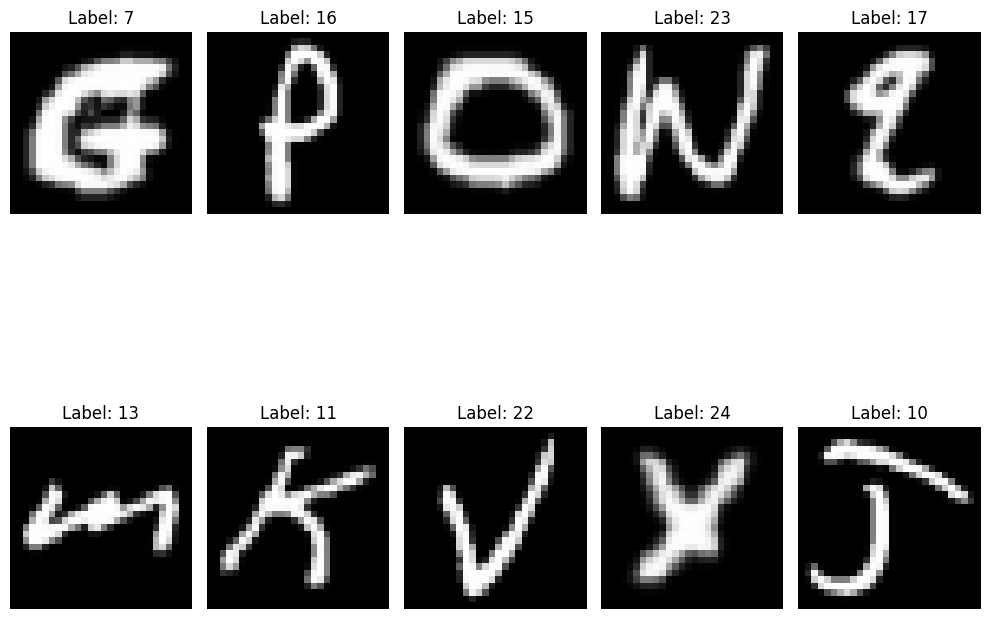

In [8]:
# Normalize the pixel values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
images = scaler.fit_transform(pixel_values)

# Reshape images to 28x28
images = images.reshape(-1, 28, 28, 1)

num_images = 10

# Create a figure with 5x2 subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 10))

# Loop through the first 10 images
for i in range(num_images):
    row, col = divmod(i, 5)  # Determine the row and column
    transposed_image = np.transpose(images[i].reshape(28, 28))  # Transpose the image
    axes[row, col].imshow(transposed_image, cmap='gray')
    axes[row, col].set_title(f'Label: {labels[i]}')
    axes[row, col].axis('off')  # Hide axes

# Adjust the layout
plt.tight_layout()
plt.show()

## Checking Class distribution

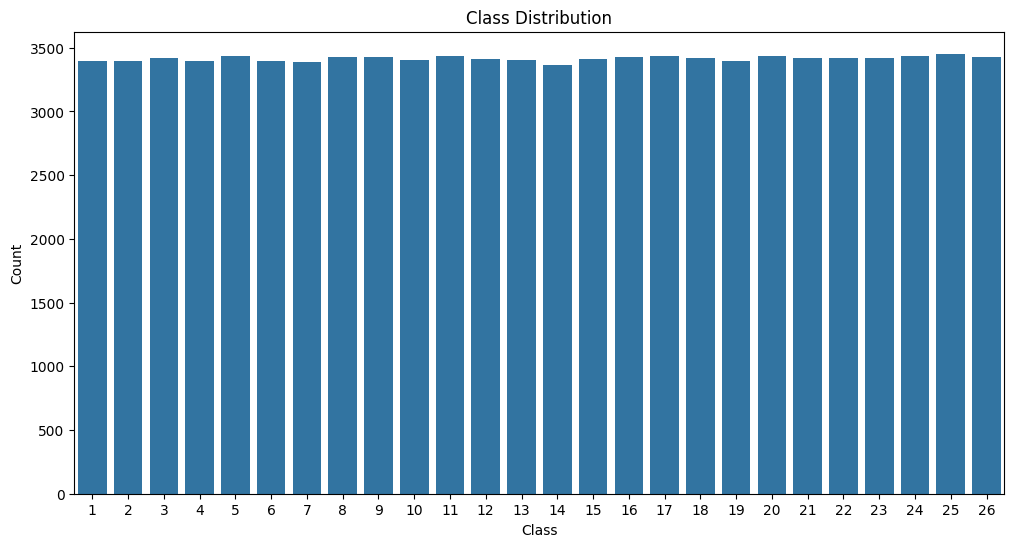

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Seems to be an even class distrubution

## Image Pixel Distribution

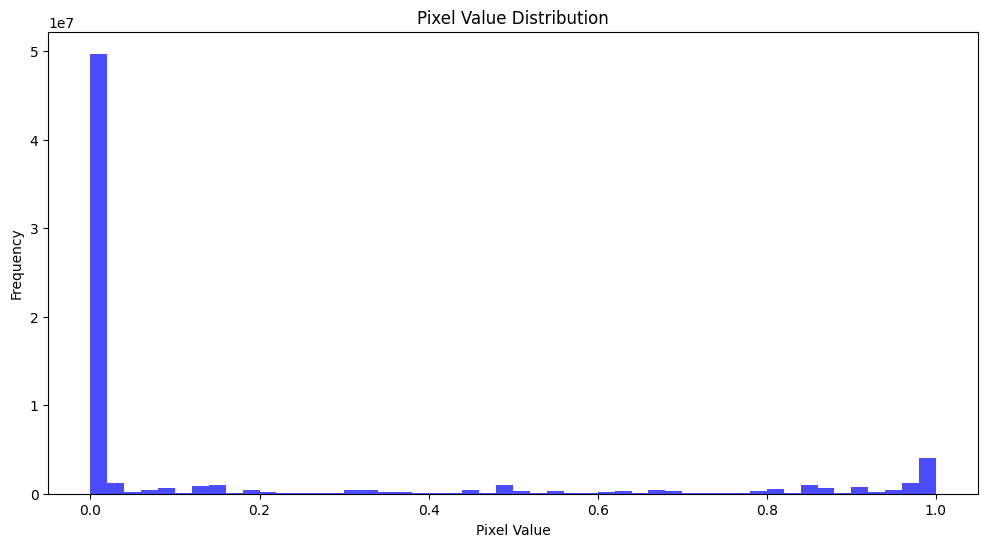

In [10]:
# Plot pixel value distribution
plt.figure(figsize=(12, 6))
plt.hist(images.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

### According to pixel value distrubution, it seems the majority of the image are black, likely due to the background being black, and there seems to a small peak at 1.0 likely due to the strokes of the character

Imbalance in Pixel Distribution:

The GAN might focus too much on generating the black background and not enough on the important features (strokes).

Training Challenges:

The discriminator may easily distinguish between real and generated images based on the predominance of black pixels, making it harder for the generator to improve

## Cropping images to reduce background

In [7]:
from PIL import Image, ImageOps
import numpy as np

def pad_and_resize(image, target_size=(28, 28), padding_color=0):
    # Convert to PIL Image
    pil_img = Image.fromarray((image * 255).astype(np.uint8))
    
    # Calculate padding to make the image square
    width, height = pil_img.size
    max_dim = max(width, height)
    delta_w = max_dim - width
    delta_h = max_dim - height
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    
    # Add padding
    padded_img = ImageOps.expand(pil_img, padding, fill=padding_color)
    
    # Resize to target size
    resized_img = padded_img.resize(target_size)
    
    # Convert back to numpy array
    return np.array(resized_img) / 255.0

# Apply to all images
processed_images = np.array([pad_and_resize(img.reshape(28, 28)) for img in transposed_image])

# Visualize some processed images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(processed_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


ValueError: cannot reshape array of size 28 into shape (28,28)

## Average Image

TypeError: Invalid shape (28,) for image data

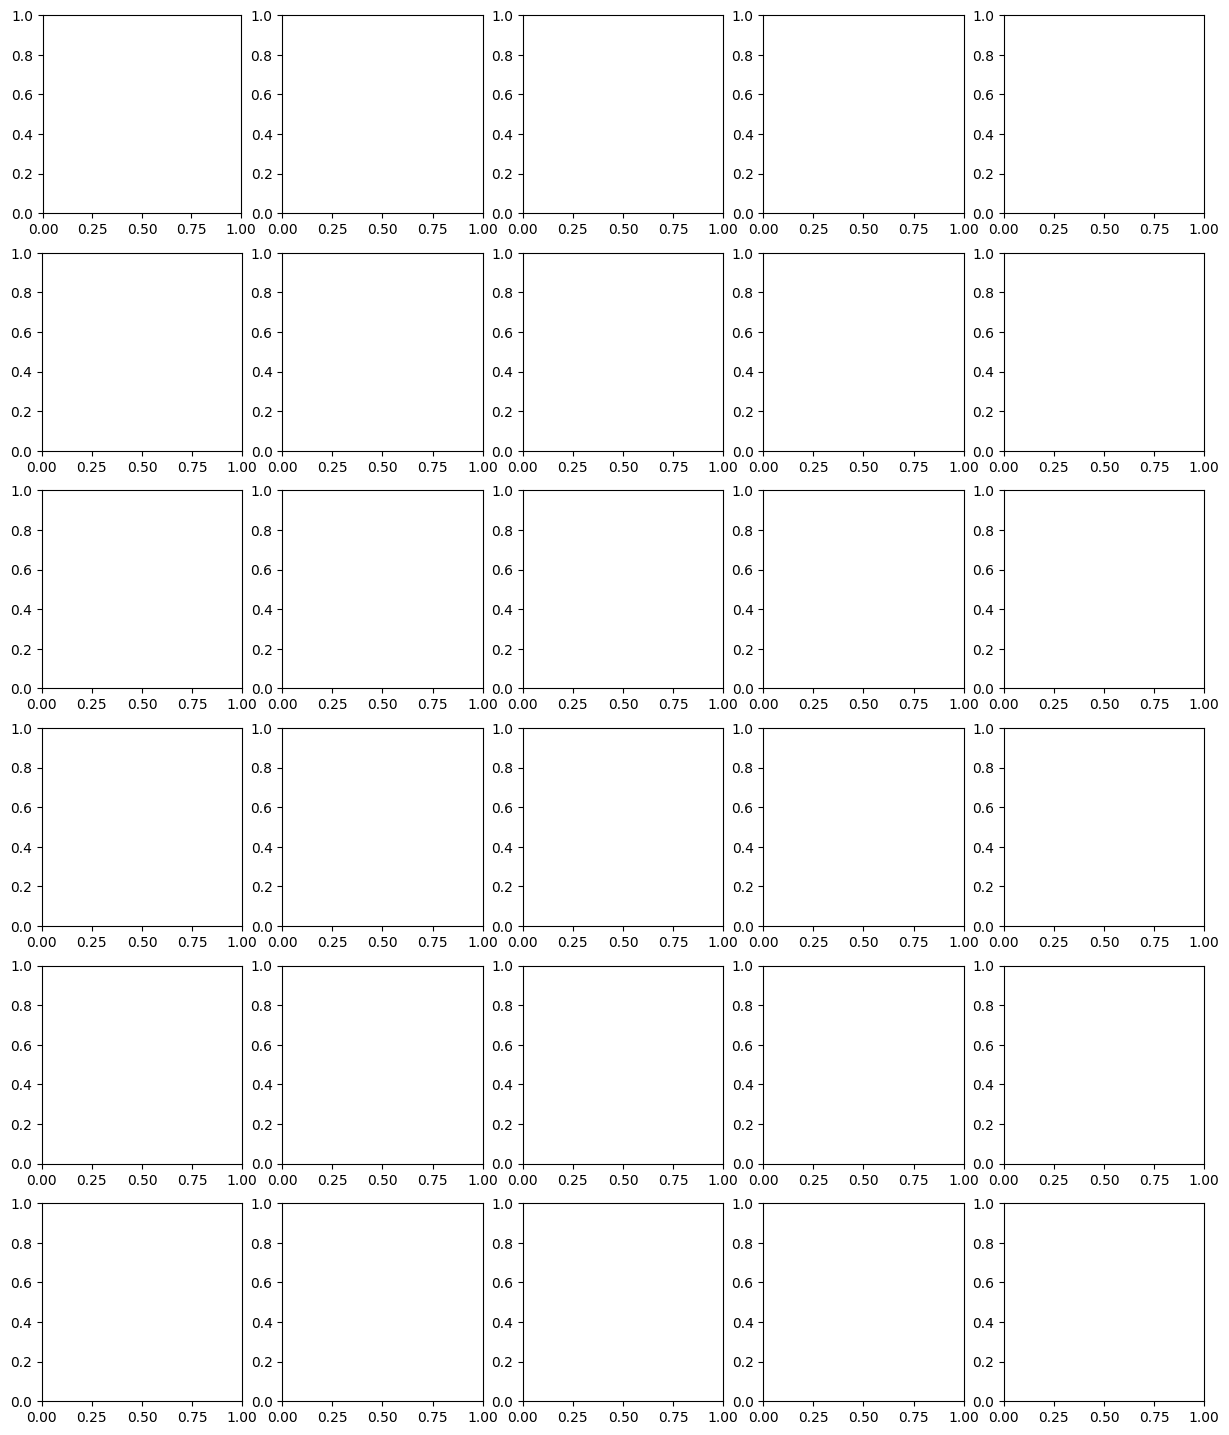

In [ ]:
# Get the unique labels
unique_labels = np.unique(labels)

# Create a figure for the average images
num_labels = len(unique_labels)
fig, axes = plt.subplots((num_labels + 4) // 5, 5, figsize=(15, (num_labels + 4) // 5 * 3))

# Loop through each label and calculate the average image
for i, label in enumerate(unique_labels):
    # Select images for the current label

    selected_images = transposed_image[unique_labels]

    # Compute the average image
    average_image = np.mean(selected_images, axis=0)

    # Plot the average image
    row, col = divmod(i, 5)
    axes[row, col].imshow(average_image, cmap='gray')
    axes[row, col].set_title(f'Label: {label}')
    axes[row, col].axis('off')  # Hide axes

# Adjust the layout
plt.tight_layout()
plt.show()

## Blurry Images 
If the average image of a class is blurry, it suggests several key points about your dataset:

- High Variability: There is a high degree of variation in how the images of that class are represented.

-  This could mean that the shapes, sizes, orientations, and positions of the strokes or features vary significantly across the images in that c

## Similar Images like label 11 and 24, 21 and 22

1. Re-evaluate Class Definitions

- Merge Classes: If the similarity is due to overlapping definitions, consider merging the classes if it makes sense for your application.

- Sub-classing: Alternatively, create subclasses to better capture the subtle differences if merging is not appropriate.

2. Enhanced Feature Engineering

- Extract Distinguishing Features: Use advanced feature extraction techniques to identify features that can help differentiate the classes.

- Edge Detection: Apply edge detection filters to highlight contours and shapes.

- Histogram of Oriented Gradients (HOG): Use HOG descriptors to capture the structure and shape of objects.

## What we learn from the Average Image

Feature Learning: The average images help identify the key features that your model needs to learn for each class. 

For instance, the consistent strokes or shapes that are visible in the average images are crucial features for classification.

Class Distinction: These average images can help you see how distinct or similar different classes are.

If two classes have very similar average images, it might be challenging for the model to distinguish between them, and you may need more discriminative features.

Data Quality: Clear average images indicate good quality and consistency in your dataset. If some classes have very blurred averages, you might need to investigate and possibly clean or augment those classes to improve consistency

## Investigating Class Seperability using PCA, T-SNE

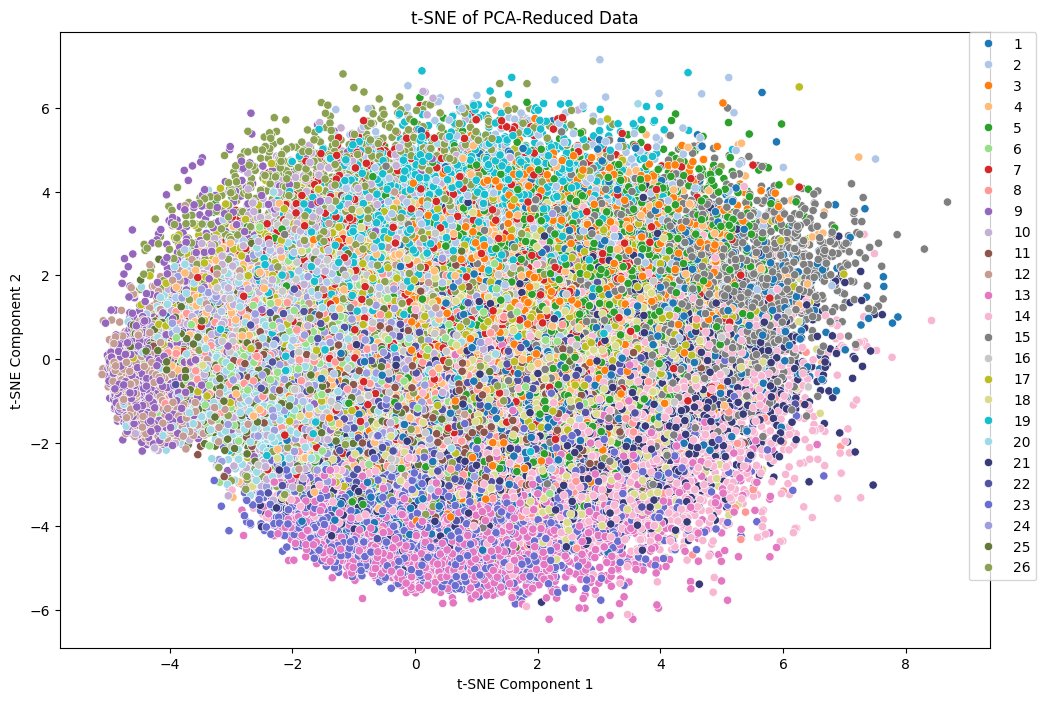

In [ ]:
from sklearn.decomposition import PCA

# Flatten images for PCA
flat_images = images.reshape(images.shape[0], -1)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flat_images)

palette = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", 6)
#  Plot t-SNE results after PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette=palette, legend='full')
plt.title('t-SNE of PCA-Reduced Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0., ncol=1)
plt.show()




In [ ]:
# from sklearn.manifold import TSNE

# # Apply t-SNE to the flattened images
# # Flatten images for PCA
# images_flatten = images.reshape(len(images), -1)
# tsne = TSNE(n_components=2, random_state=42)
# tsne_result = tsne.fit_transform(images_flatten)

# # Plot t-SNE results
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="tab10", legend='full')
# plt.title('t-SNE of Image Data')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.legend(loc='best')
# plt.show()


In [ ]:
# from sklearn.decomposition import PCA
# import seaborn as sns

# # Apply PCA

# # Flatten images for PCA and t-SNE
# images_flatten = images.reshape(len(images), -1)

# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(images_flatten)

# # Create a large color palette
# palette = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", 6)

# # Plot PCA results with larger palette
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette=palette, legend='full')
# plt.title('PCA of EMNIST Data')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0., ncol=1)
# plt.show()


In [ ]:
# # Apply PCA before t-SNE
# from sklearn.manifold import TSNE
# pca_50 = PCA(n_components=50)  # Reduce to 50 dimensions first
# pca_result_50 = pca_50.fit_transform(images_flatten)
# tsne = TSNE(n_components=2, random_state=42)

# # Apply t-SNE on PCA-reduced data
# tsne_pca_result = tsne.fit_transform(pca_result_50)
# # Generate a palette with 40 colors
# palette = sns.color_palette("hsv", 40)
# # Plot t-SNE results after PCA
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x=tsne_pca_result[:, 0], y=tsne_pca_result[:, 1], hue=labels, palette=palette, legend='full')
# plt.title('t-SNE of PCA-Reduced Data')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0., ncol=1)
# plt.show()


# Feature Engineering

## Edge Detection

- Edge detection is a technique used to identify and locate sharp discontinuities in an image. 

- These discontinuities correspond to significant changes in intensity, which typically represent boundaries of objects within the image.

- The primary goal of edge detection is to capture important features of an image such as lines, curves, and shapes

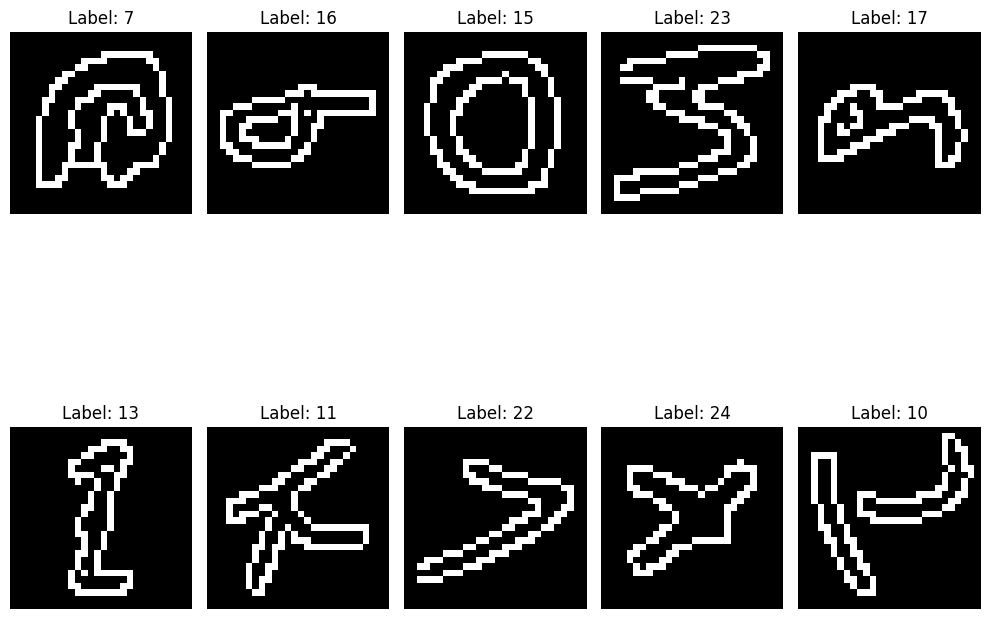

In [ ]:
import matplotlib.pyplot as plt
from skimage import feature

# Apply edge detection (Canny filter) to the images
edges = np.array([feature.canny(image.squeeze()) for image in images])

# Display some edge-detected images
fig, axes = plt.subplots(2, 5, figsize=(10, 10))
for i in range(10):
    row, col = divmod(i, 5)
    axes[row, col].imshow(edges[i], cmap='gray')
    axes[row, col].set_title(f'Label: {labels[i]}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()


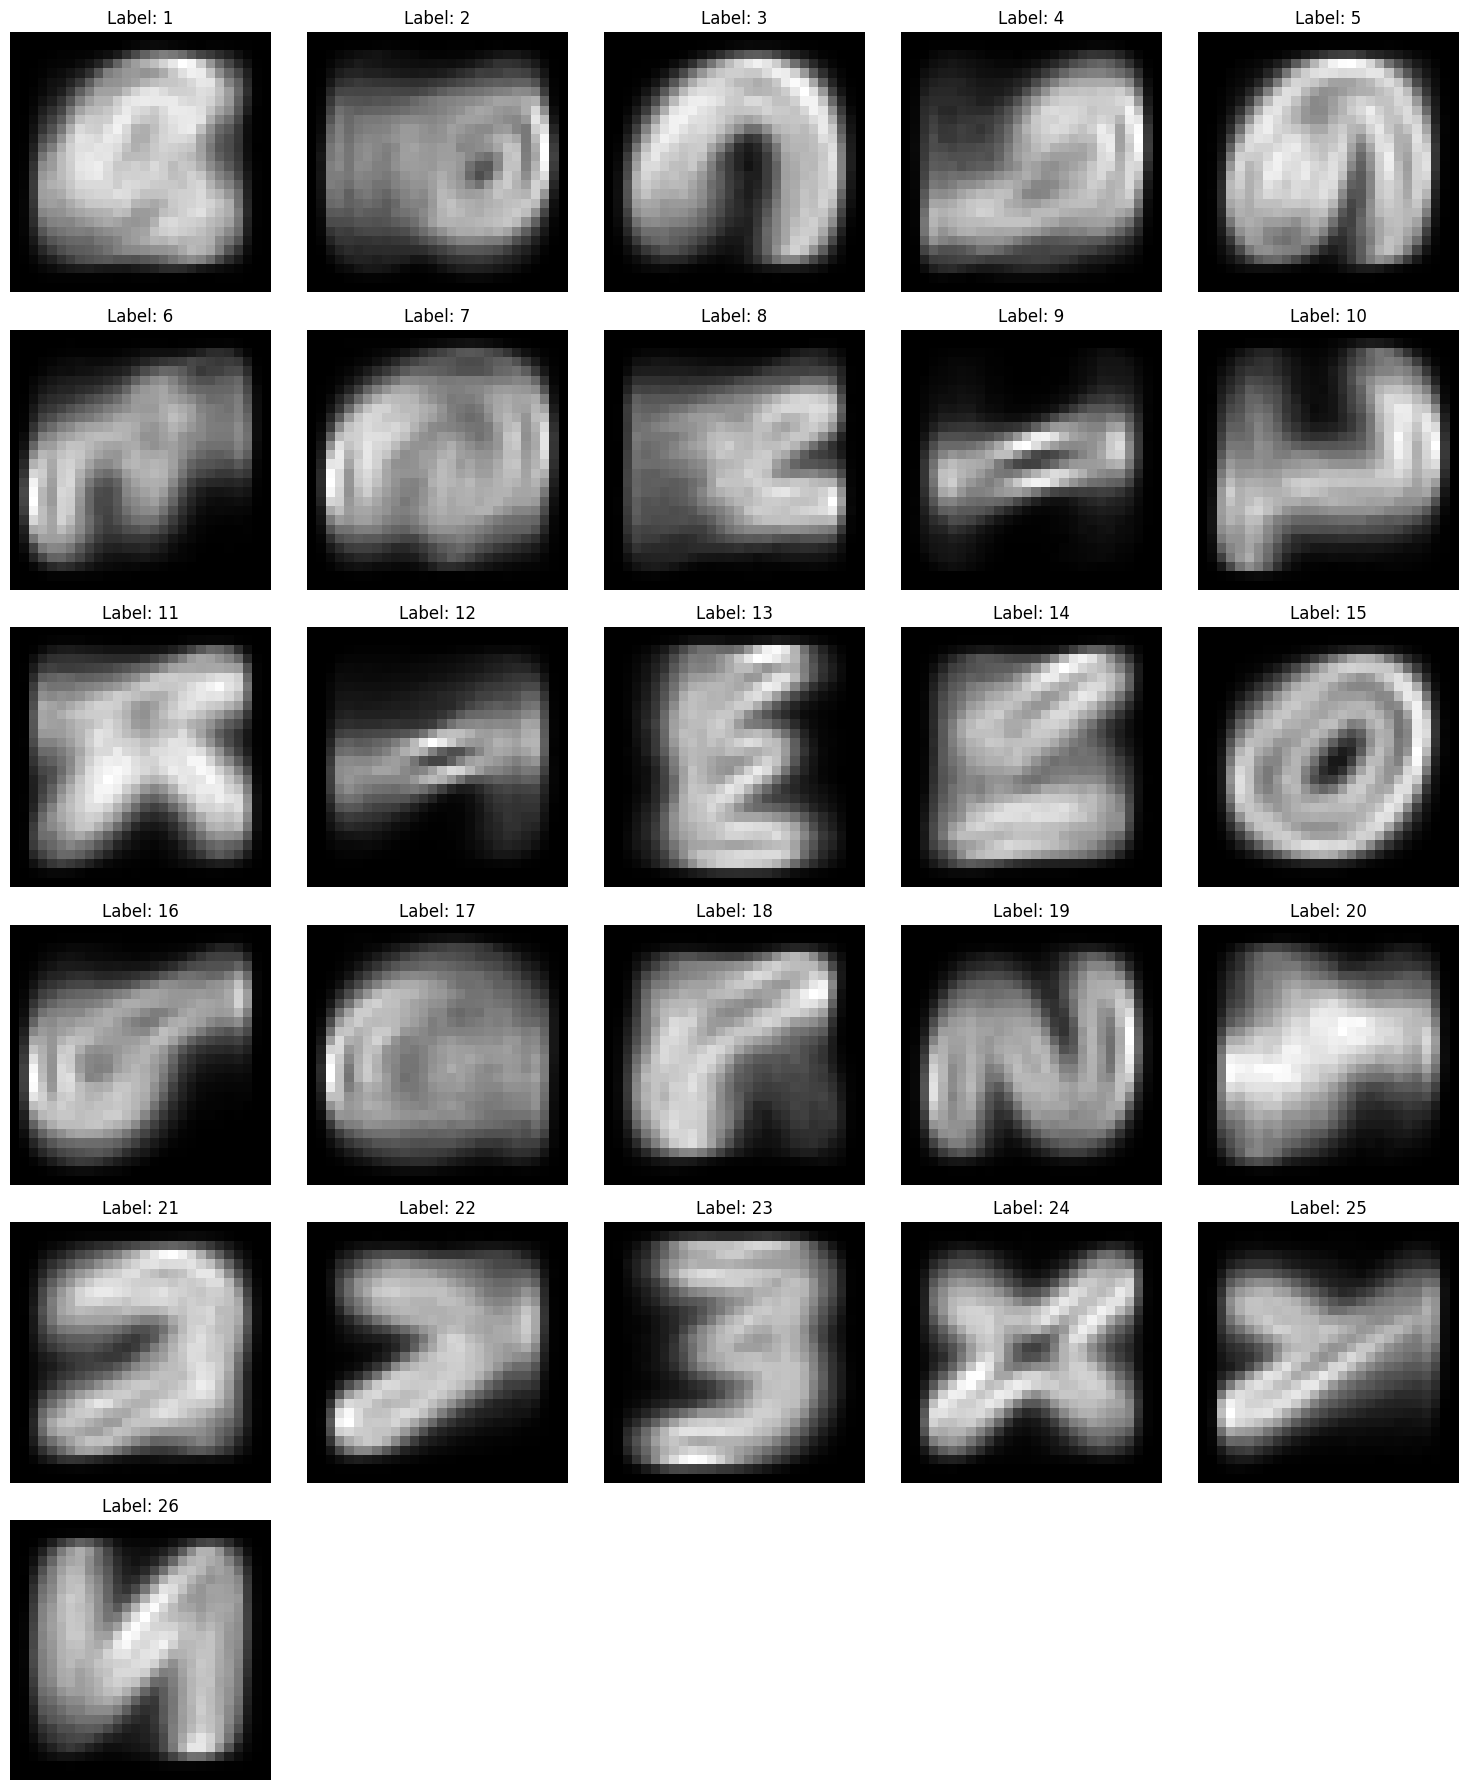

In [ ]:
## Get the unique labels
unique_labels = np.unique(labels)

# Dictionary to store average edge images for each class
average_edge_images = {}

# Compute average edge image for each class
for label in unique_labels:
    # Get all images for the current label
    class_edges = edges[labels == label]
    
    # Compute the average edge-detected image for the current label
    average_edge_images[label] = np.mean(class_edges, axis=0)

# Determine the grid size for plotting
num_labels = len(unique_labels)
rows = (num_labels + 4) // 5  # Adjust the number of columns as needed
cols = 5

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

# Display the average edge-detected images for each class
for i, label in enumerate(unique_labels):
    row, col = divmod(i, cols)
    axes[row, col].imshow(average_edge_images[label], cmap='gray')
    axes[row, col].set_title(f'Label: {label}')
    axes[row, col].axis('off')

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    row, col = divmod(j, cols)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Thresholding

- Converts the edge-detected image into a binary format to simplify the representation and make the edges more distinct.

- For instance, using Otsu’s method to find an optimal threshold value, you can binarize the edge-detected image to highlight the detected edges

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


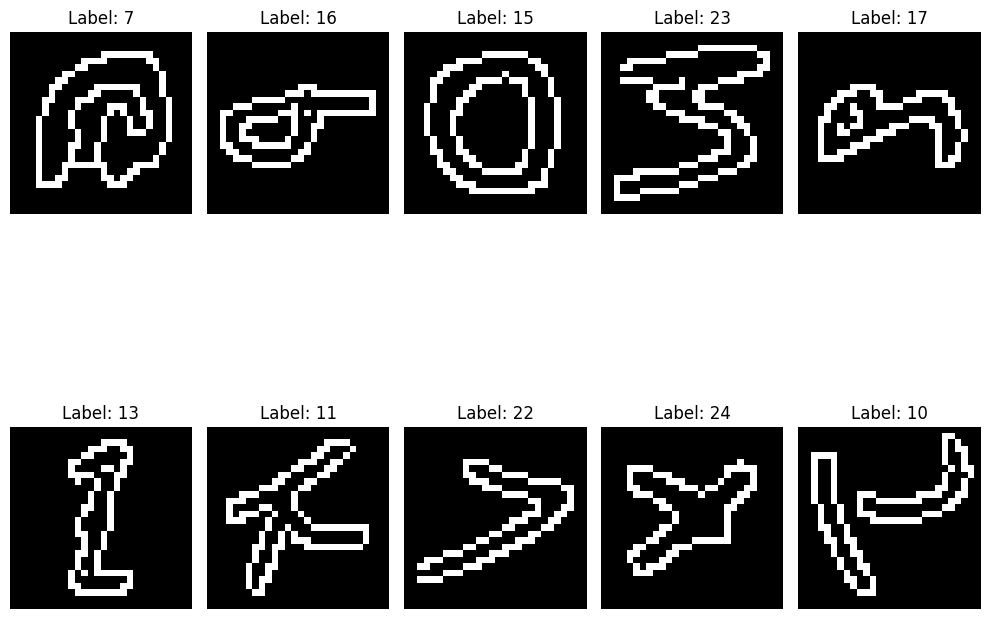

In [ ]:
from skimage import filters

# Apply a binary threshold to the edge-detected images
thresholded_edges = [filters.threshold_otsu(edge) for edge in edges]
binary_edges = [(edge > threshold).astype(int) for edge, threshold in zip(edges, thresholded_edges)]

# Display some thresholded edge-detected images
fig, axes = plt.subplots(2, 5, figsize=(10, 10))
for i in range(10):
    row, col = divmod(i, 5)
    axes[row, col].imshow(binary_edges[i], cmap='gray')
    axes[row, col].set_title(f'Label: {labels[i]}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()



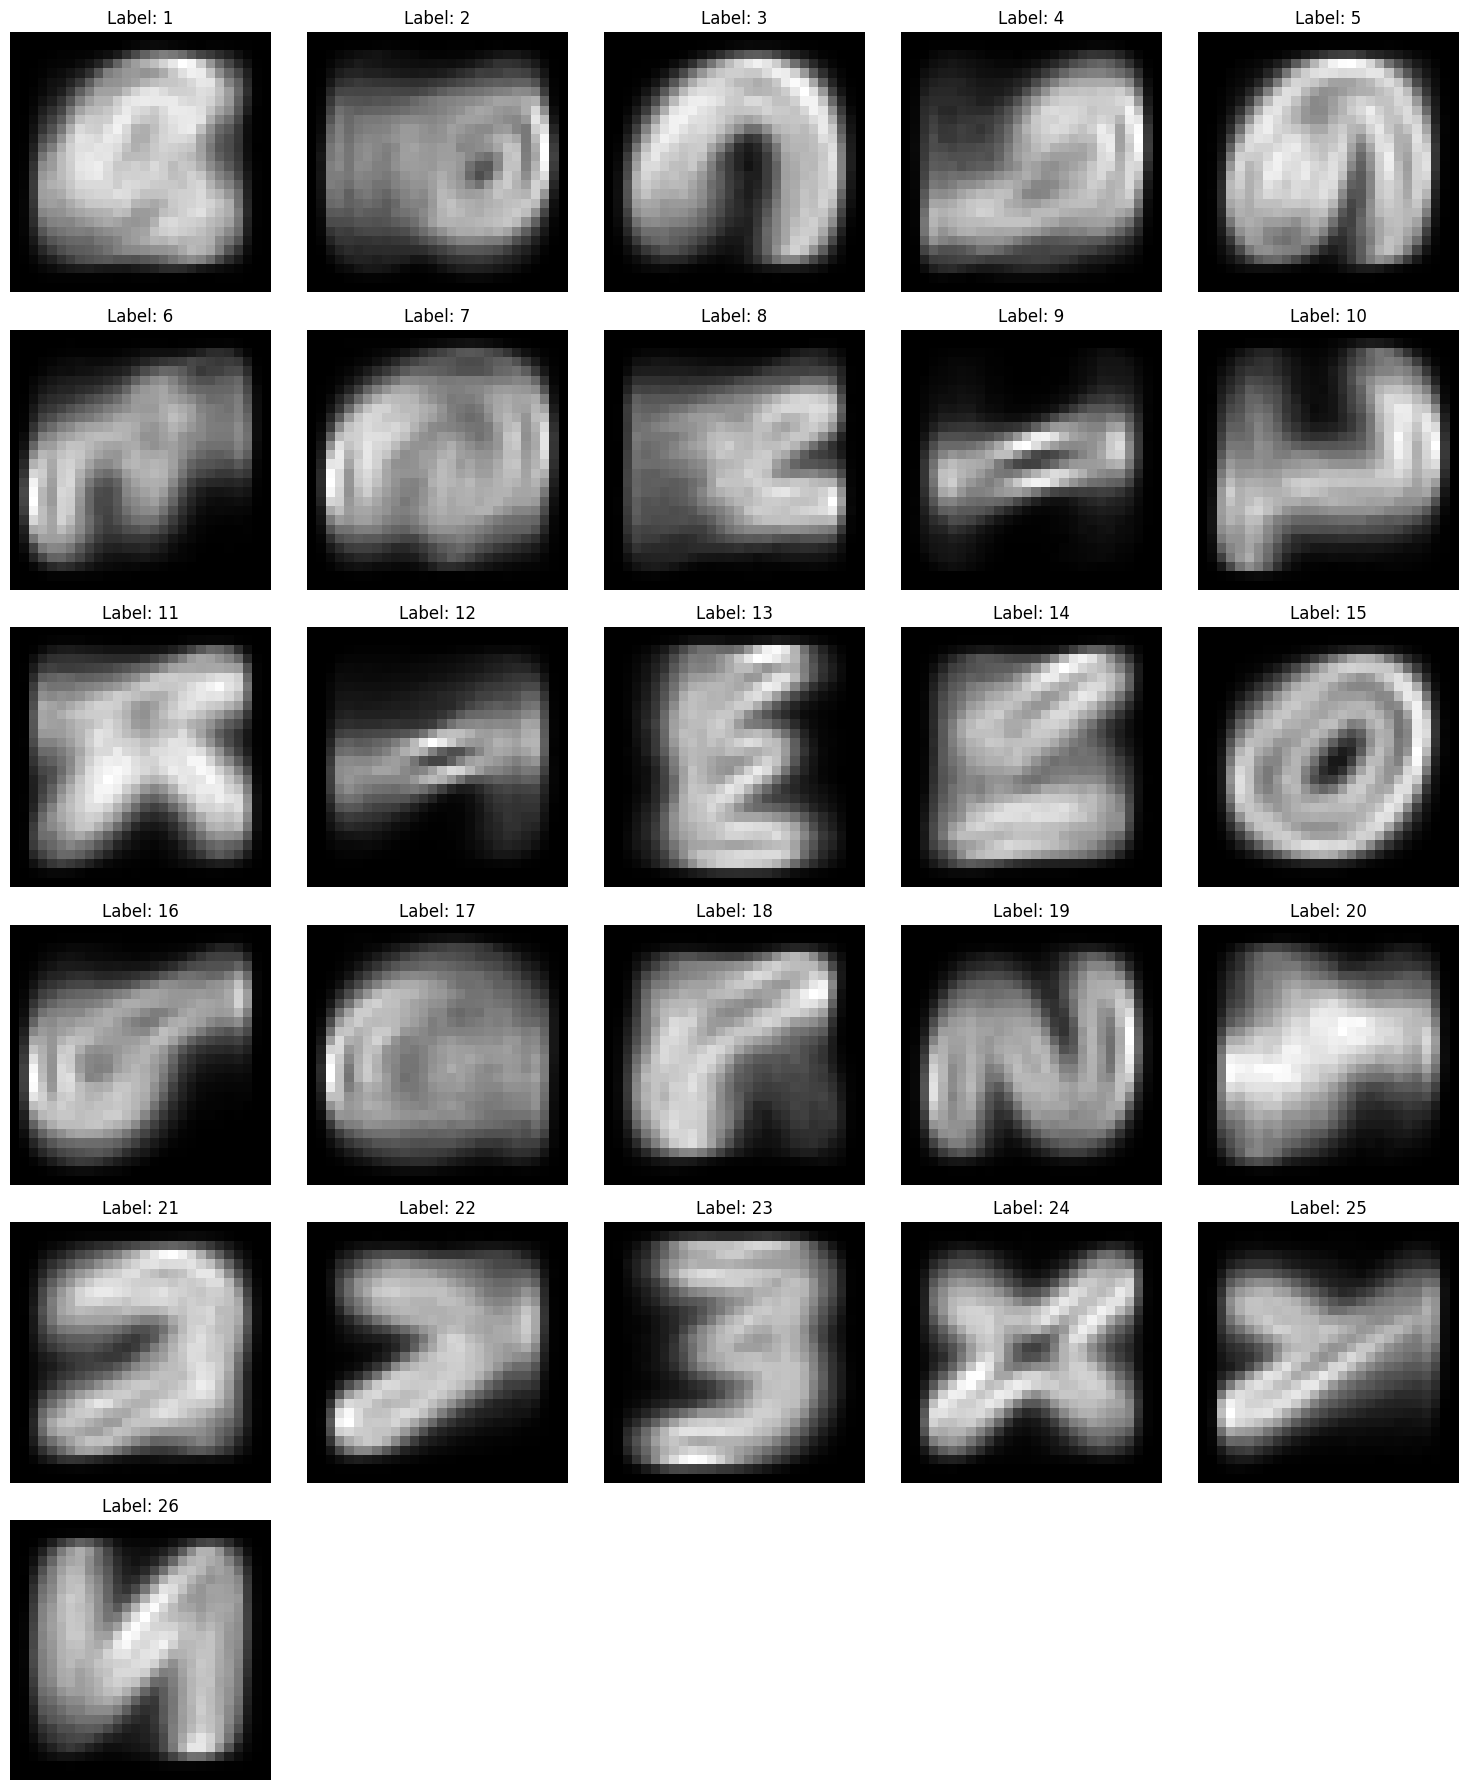

In [ ]:
# Get the unique labels
binary_edges = np.array(binary_edges)
unique_labels = np.unique(labels)

# Dictionary to store average binary edge images for each class
average_bedge_images = {}

# Compute average binary edge image for each class
for label in unique_labels:
    # Get all binary edge images for the current label
    class_edges = binary_edges[labels == label]
    
    # Compute the average binary edge-detected image for the current label
    average_bedge_images[label] = np.mean(class_edges, axis=0)

# Determine the grid size for plotting
num_labels = len(unique_labels)
rows = (num_labels + 4) // 5  # Adjust the number of columns as needed
cols = 5

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

# Display the average binary edge-detected images for each class
for i, label in enumerate(unique_labels):
    row, col = divmod(i, cols)
    axes[row, col].imshow(average_bedge_images[label], cmap='gray')
    axes[row, col].set_title(f'Label: {label}')
    axes[row, col].axis('off')

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    row, col = divmod(j, cols)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Model Buildling

Might use condtional GANs because of hard seperabiltiy

In [ ]:
k

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose,Embedding, multiply ,LeakyReLU, Dropout, Input, BatchNormalization, UpSampling2D, Activation
from tensorflow.keras.models import Sequential


In [ ]:
def build_generator(input_dim=100):
    noise_input = Input(shape=(input_dim,))
    label_input = Input(shape=(1,), dtype='int32')

    label_embedding = Embedding(26, input_dim, input_length=1)(label_input)
    label_embedding = Flatten()(label_embedding)

    model_input = multiply([noise_input, label_embedding])

    model = Sequential()
    model.add(Dense(7*7*256, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, kernel_size=7, activation='sigmoid', padding='same'))

    output = model(model_input)
    return tf.keras.models.Model([noise_input, label_input], output)


In [ ]:
def build_discriminator():
    image_input = Input(shape=(28, 28, 1))
    label_input = Input(shape=(1,), dtype='int32')

    label_embedding = Embedding(26, 28*28, input_length=1)(label_input)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape((28, 28, 1))(label_embedding)

    model_input = multiply([image_input, label_embedding])

    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    output = model(model_input)
    return tf.keras.models.Model([image_input, label_input], output)


In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define the generator
from tensorflow.keras.models import Model
def build_generator(input_dim=100, num_classes=26):
    noise_input = Input(shape=(input_dim,))
    label_input = Input(shape=(1,), dtype='int32')

    label_embedding = Embedding(num_classes, input_dim, input_length=1)(label_input)
    label_embedding = Flatten()(label_embedding)

    model_input = multiply([noise_input, label_embedding])

    x = Dense(7*7*256)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 256))(x)
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(1, kernel_size=7, activation='sigmoid', padding='same')(x)

    model = Model([noise_input, label_input], x)
    return model

# Define the discriminator
def build_discriminator(num_classes=26):
    image_input = Input(shape=(28, 28, 1))
    label_input = Input(shape=(1,), dtype='int32')

    label_embedding = Embedding(num_classes, 28*28, input_length=1)(label_input)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape((28, 28, 1))(label_embedding)

    model_input = multiply([image_input, label_embedding])

    x = Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same')(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model([image_input, label_input], x)
    return model

# Initialize the models
input_dim = 100
num_classes = 26
generator = build_generator(input_dim, num_classes)
discriminator = build_discriminator(num_classes)

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create the GAN model
noise_input = Input(shape=(input_dim,))
label_input = Input(shape=(1,), dtype='int32')
generated_image = generator([noise_input, label_input])
discriminator.trainable = False
gan_output = discriminator([generated_image, label_input])
gan = Model([noise_input, label_input], gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')



In [ ]:
def generate_and_plot_images(generator, input_dim, num_classes):
    noise = np.random.normal(0, 1, (num_classes, input_dim))
    labels = np.arange(num_classes).reshape(-1, 1)  # Generate a label for each class
    generated_images = generator.predict([noise, labels])

    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        if i < num_classes:
            ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

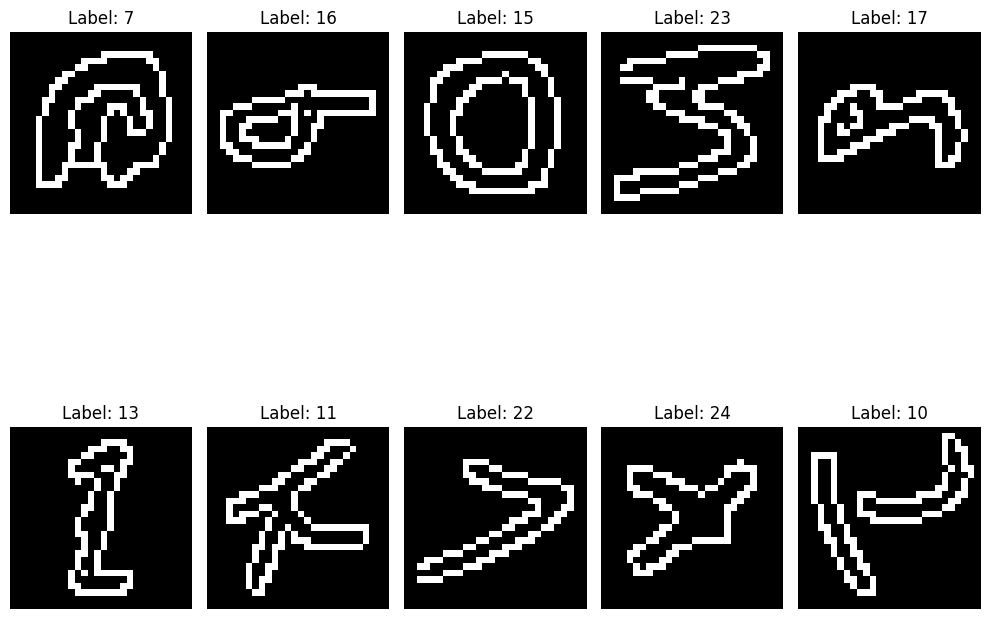

2/2 [==============================] - 11s 14ms/step
0 [D loss: 1.0981003046035767, acc.: 26.5625%] [G loss: 0.7030705213546753]
1/1 [==============================] - 0s 131ms/step


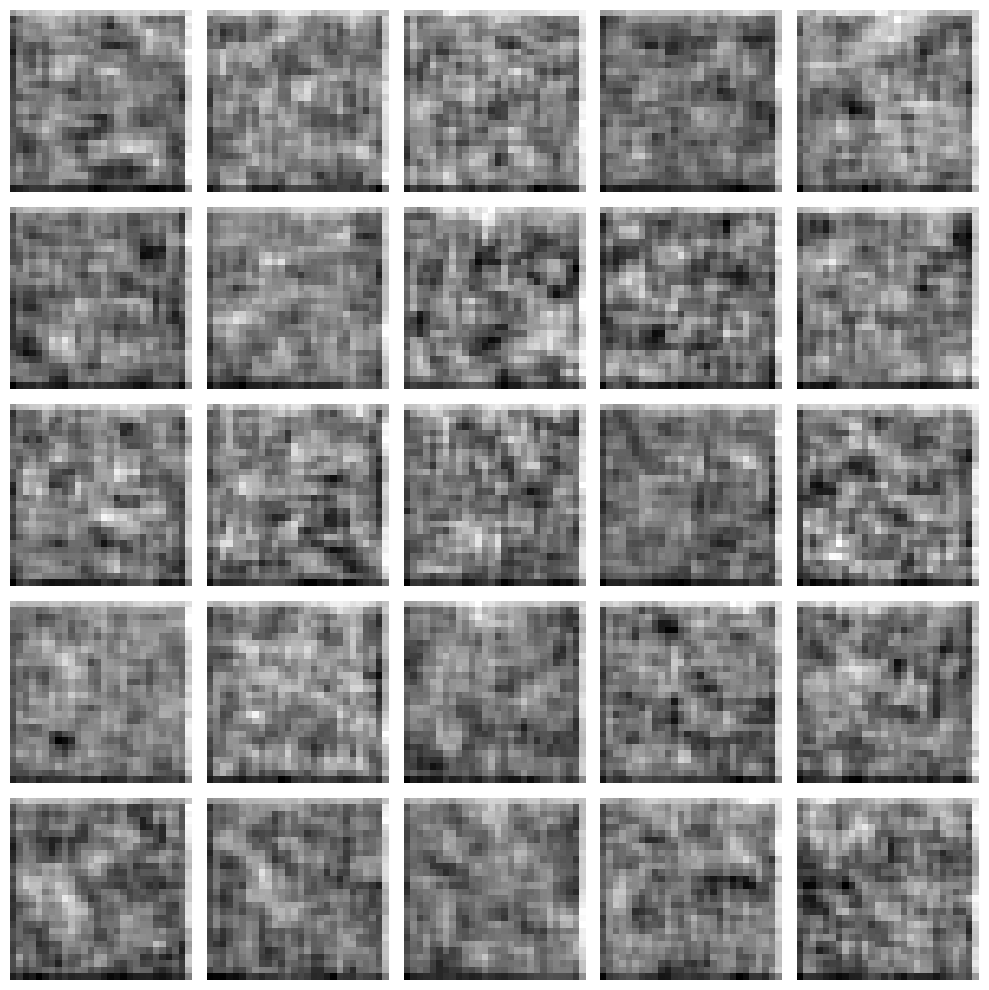

2/2 [==============================] - 0s 5ms/step
50 [D loss: 0.1038193330168724, acc.: 98.4375%] [G loss: 1.2688664197921753]
1/1 [==============================] - 0s 18ms/step


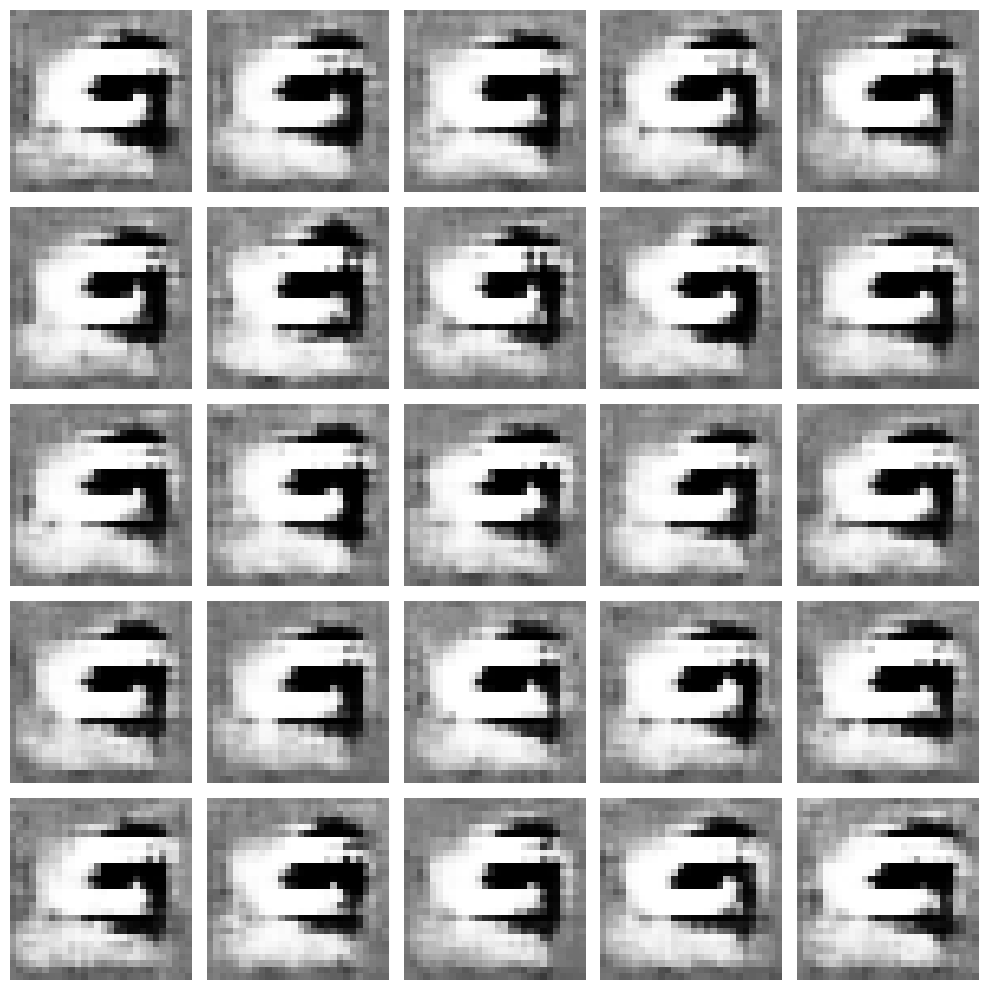

2/2 [==============================] - 0s 4ms/step
100 [D loss: 0.11808694899082184, acc.: 100.0%] [G loss: 2.686122179031372]
1/1 [==============================] - 0s 17ms/step


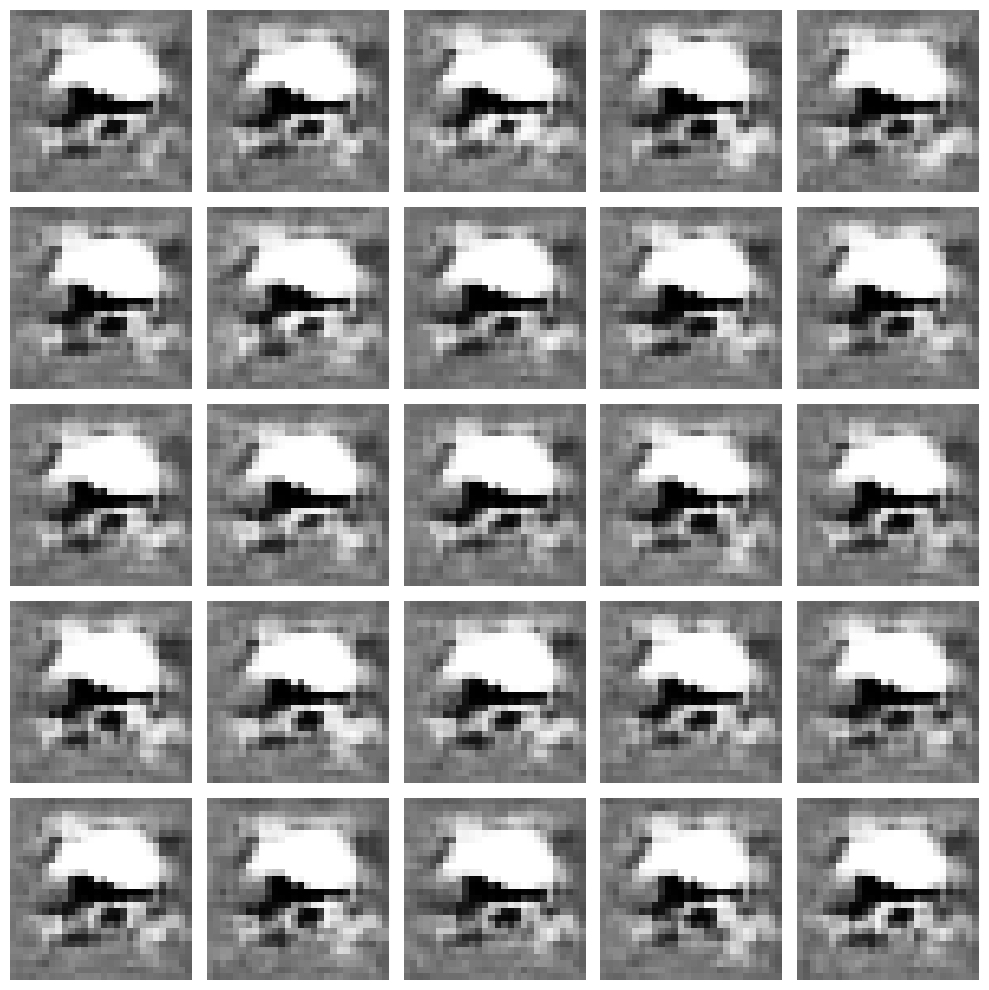

2/2 [==============================] - 0s 4ms/step
150 [D loss: 0.0842566080391407, acc.: 97.65625%] [G loss: 1.4541842937469482]
1/1 [==============================] - 0s 17ms/step


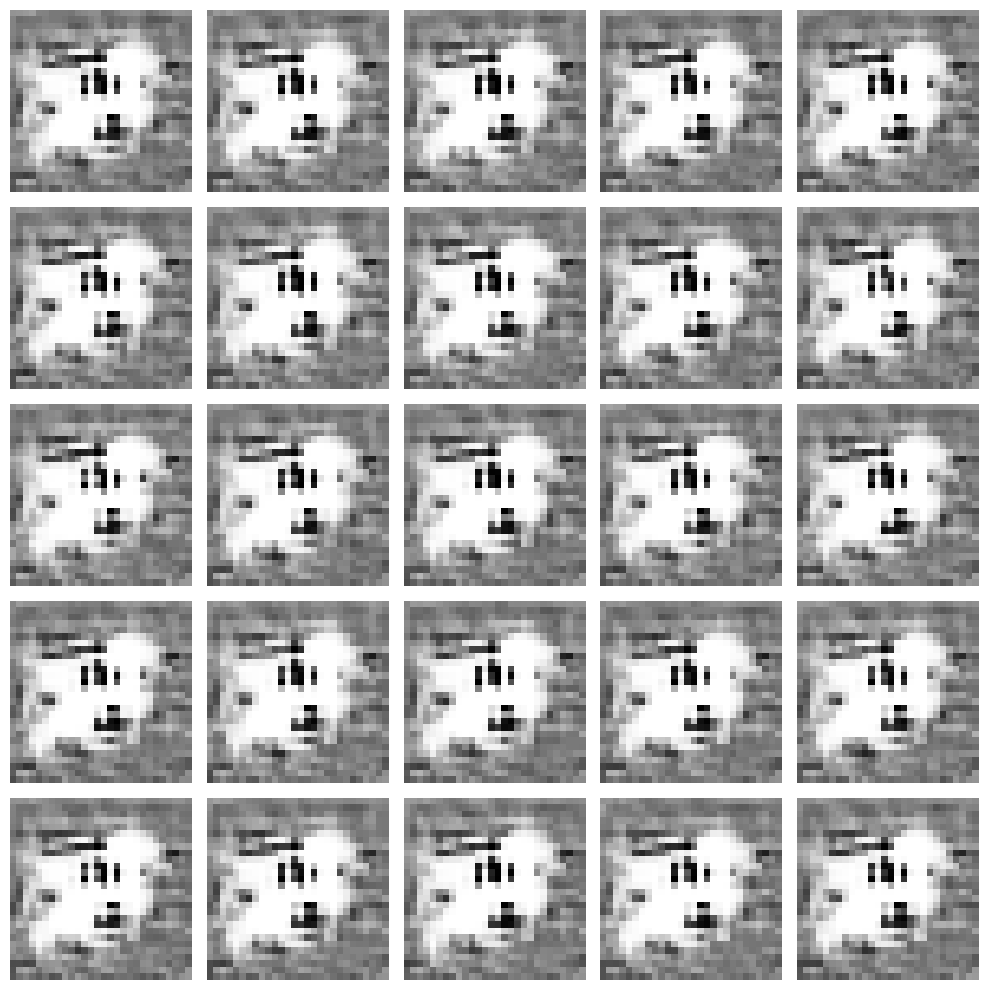

2/2 [==============================] - 0s 4ms/step
200 [D loss: 0.007597191026434302, acc.: 100.0%] [G loss: 1.7404730319976807]
1/1 [==============================] - 0s 17ms/step


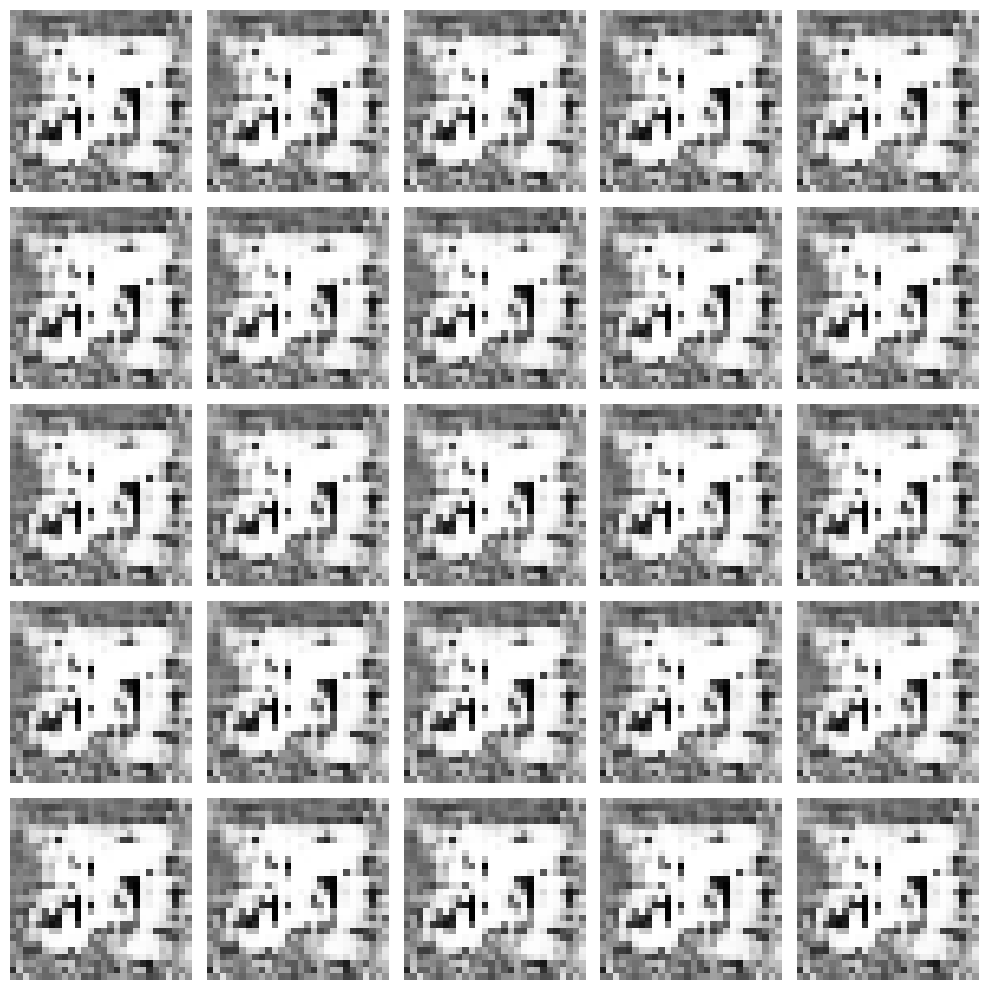

2/2 [==============================] - 0s 4ms/step
250 [D loss: 0.006896692793816328, acc.: 100.0%] [G loss: 2.0274717807769775]
1/1 [==============================] - 0s 18ms/step


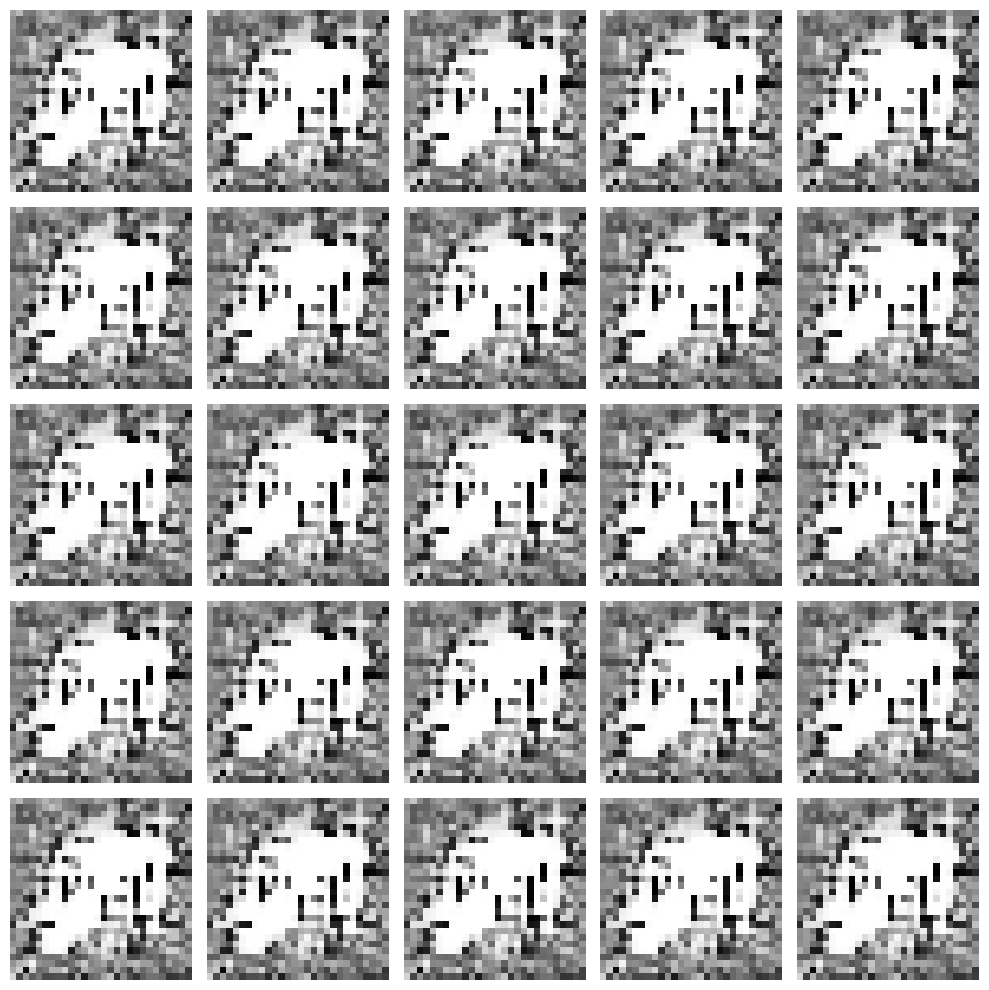

2/2 [==============================] - 0s 4ms/step
300 [D loss: 0.006644030334427953, acc.: 100.0%] [G loss: 1.9972739219665527]
1/1 [==============================] - 0s 17ms/step


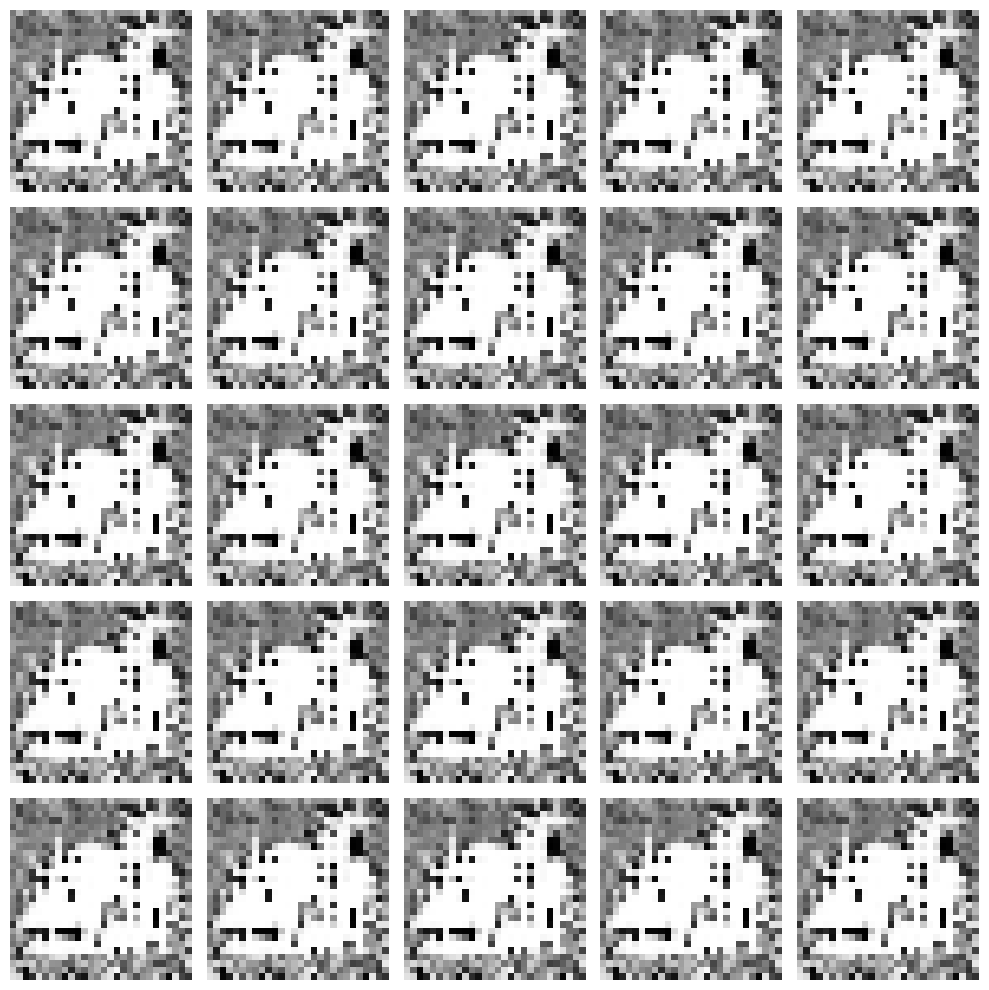

2/2 [==============================] - 0s 4ms/step
350 [D loss: 0.0016153000760823488, acc.: 100.0%] [G loss: 2.471925735473633]
1/1 [==============================] - 0s 16ms/step


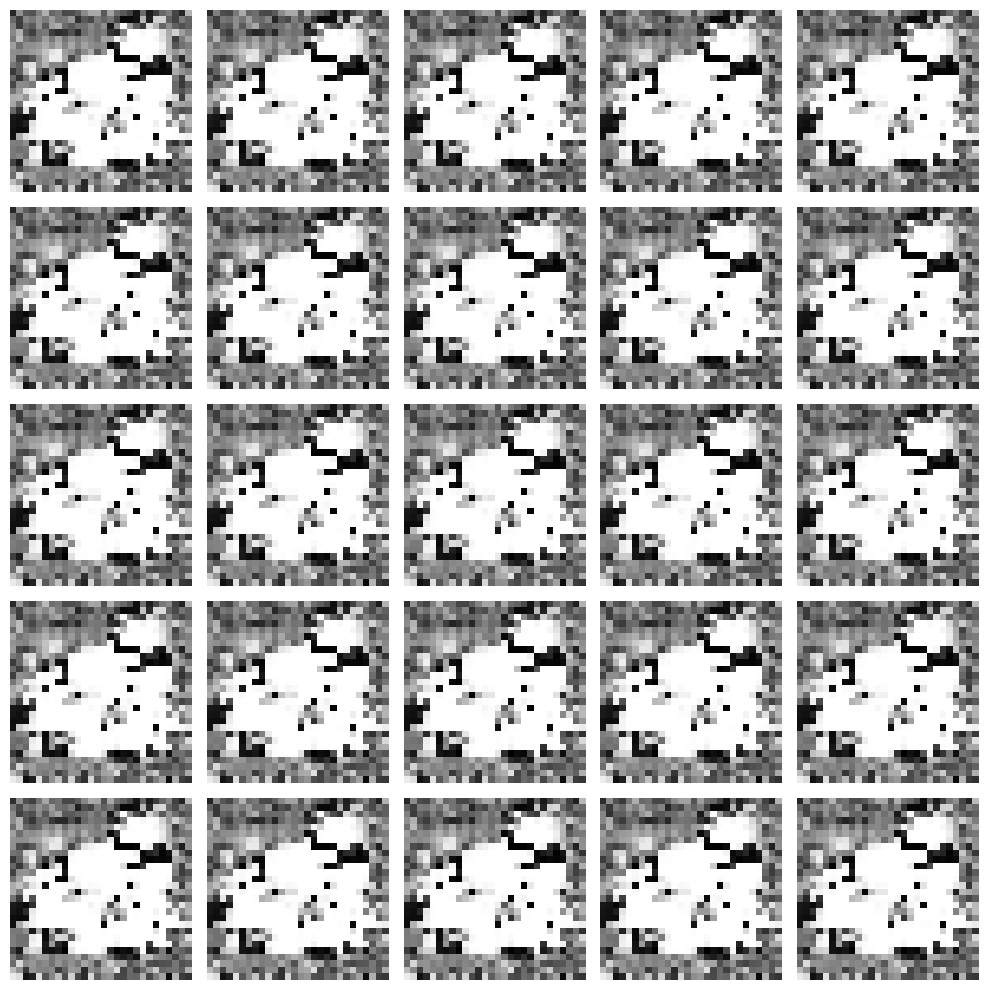

2/2 [==============================] - 0s 4ms/step
400 [D loss: 0.0019256959785707295, acc.: 100.0%] [G loss: 2.413472890853882]
1/1 [==============================] - 0s 17ms/step


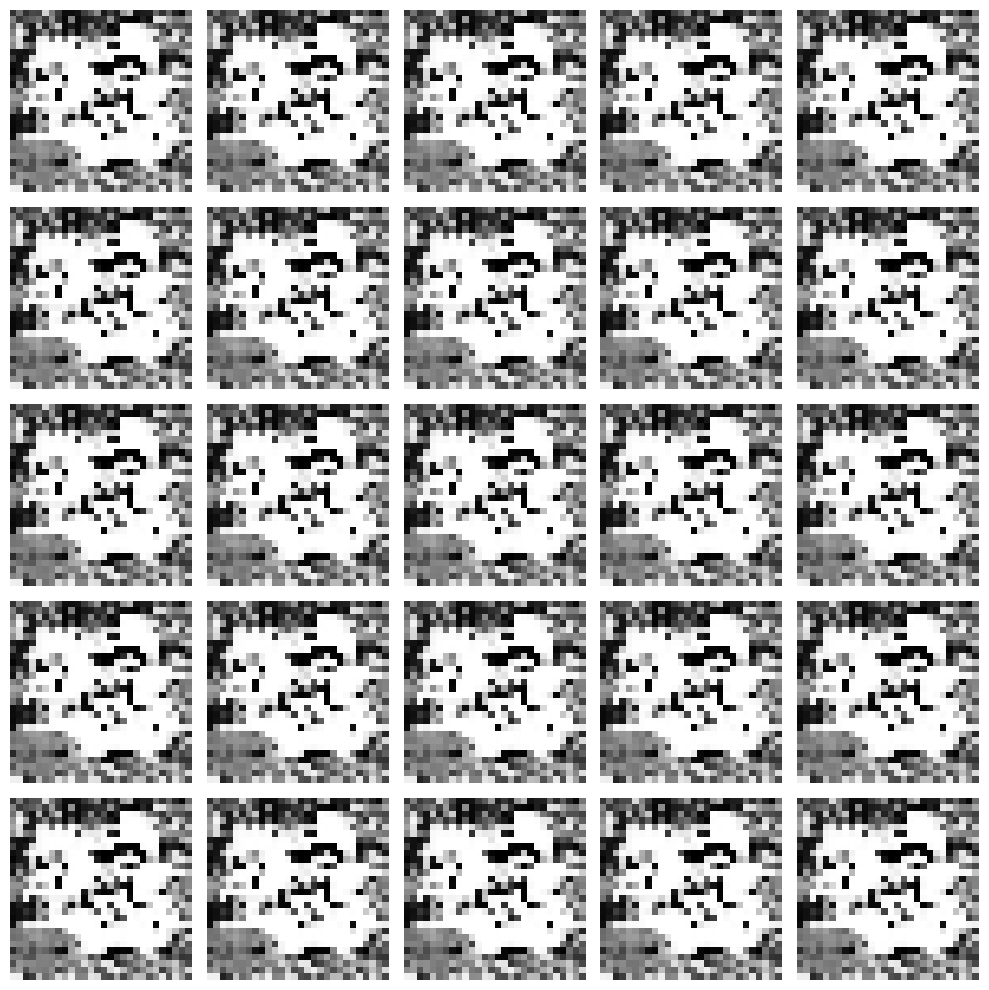

2/2 [==============================] - 0s 5ms/step
450 [D loss: 0.0009899897850118577, acc.: 100.0%] [G loss: 3.076535940170288]
1/1 [==============================] - 0s 18ms/step


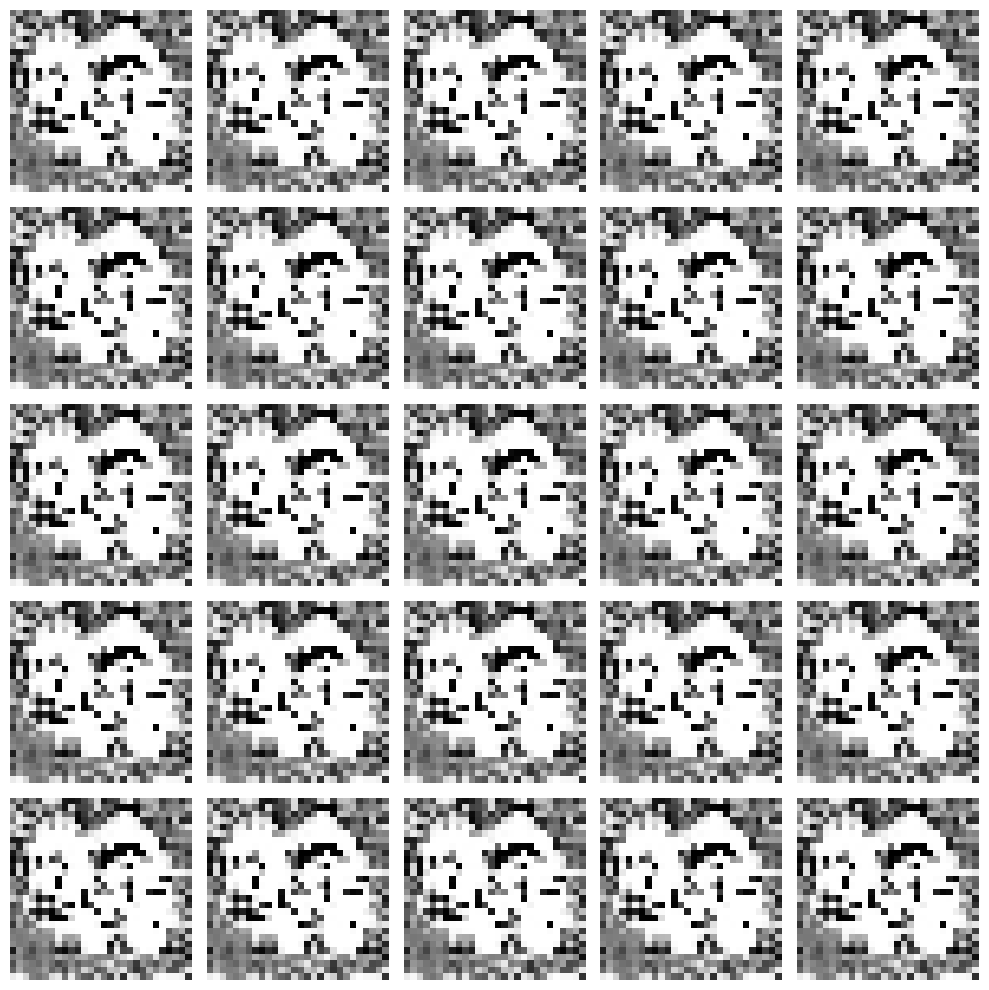

2/2 [==============================] - 0s 5ms/step
500 [D loss: 0.000882504100445658, acc.: 100.0%] [G loss: 2.162215232849121]
1/1 [==============================] - 0s 18ms/step


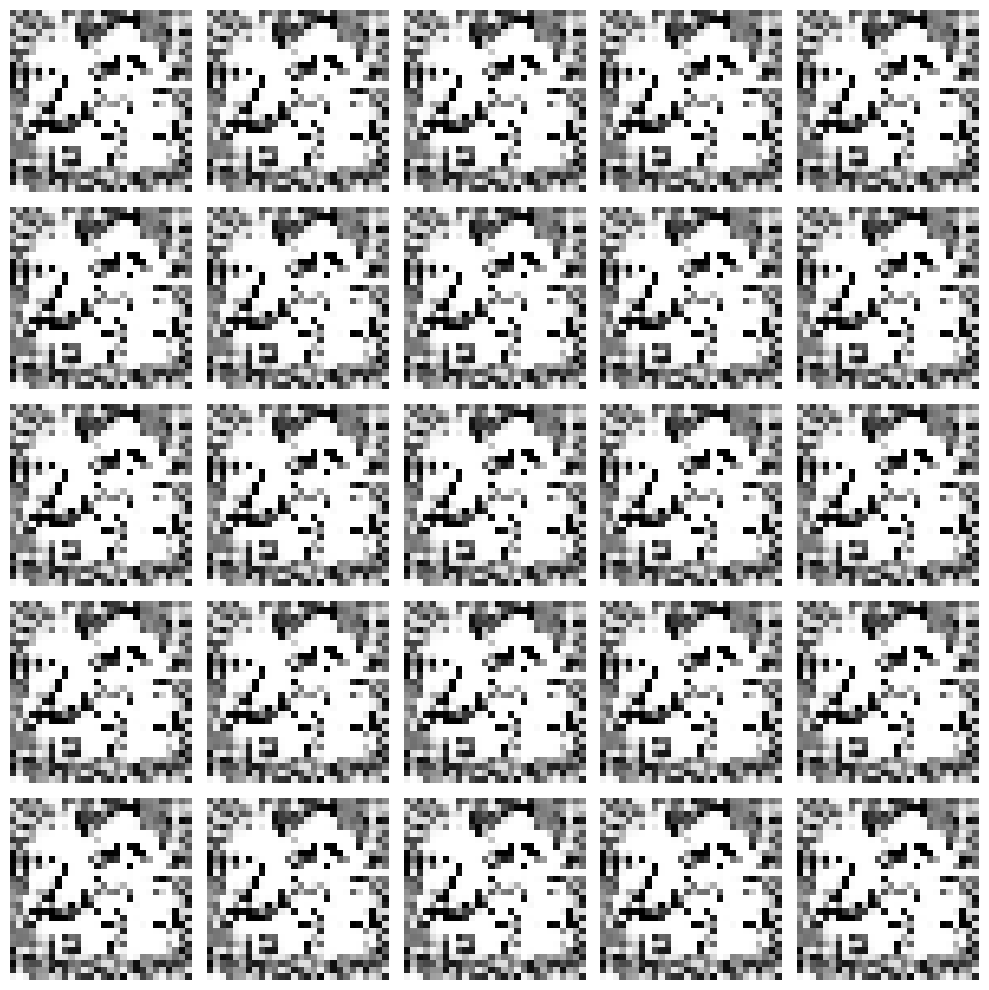

2/2 [==============================] - 0s 5ms/step
550 [D loss: 0.0004940704384353012, acc.: 100.0%] [G loss: 2.26426362991333]
1/1 [==============================] - 0s 17ms/step


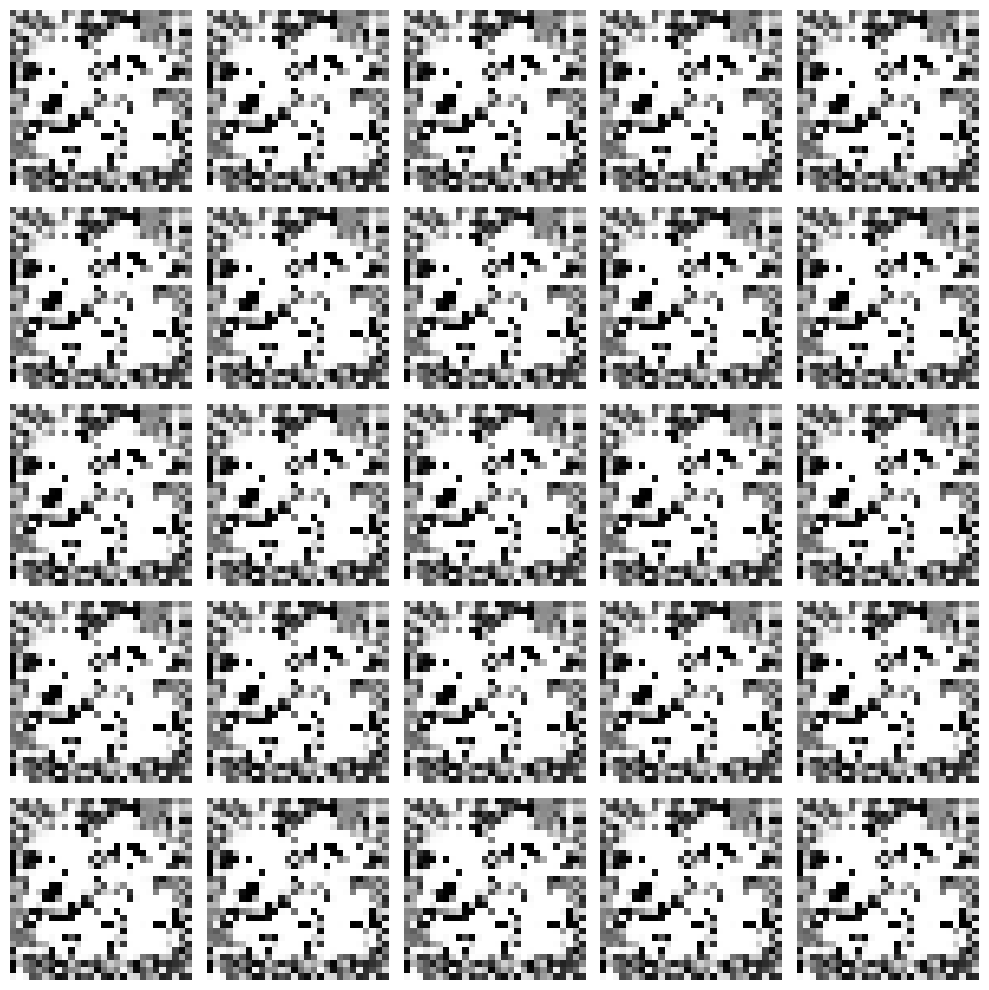

2/2 [==============================] - 0s 5ms/step
600 [D loss: 0.00037954607978463173, acc.: 100.0%] [G loss: 2.297969341278076]
1/1 [==============================] - 0s 17ms/step


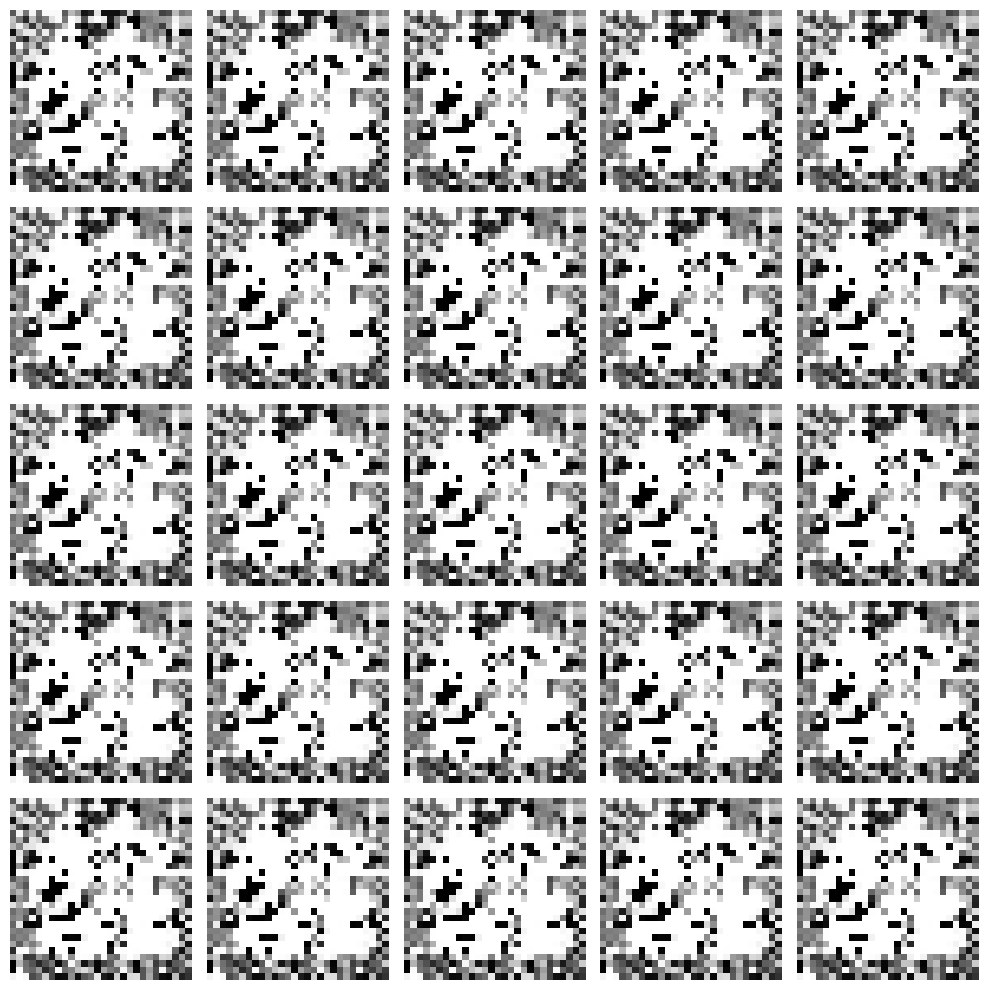

2/2 [==============================] - 0s 4ms/step
650 [D loss: 0.000562252476811409, acc.: 100.0%] [G loss: 2.6255507469177246]
1/1 [==============================] - 0s 18ms/step


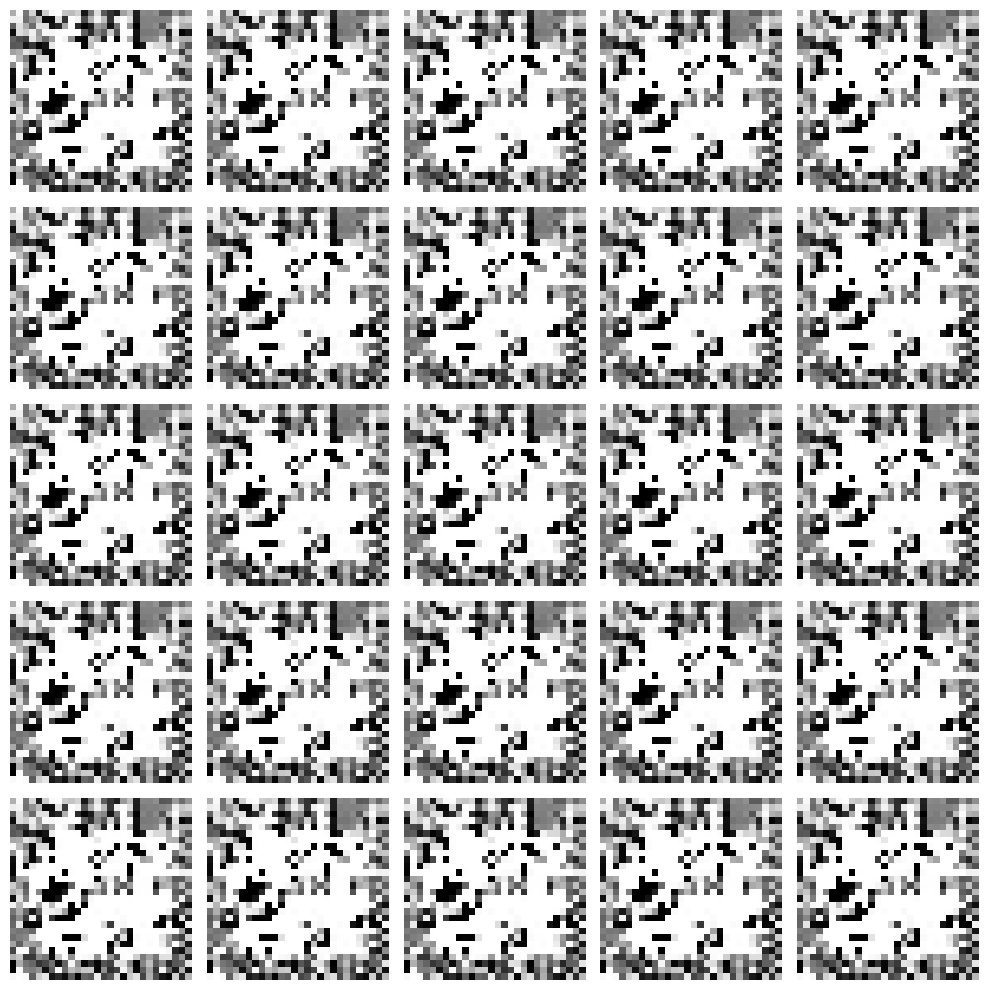

2/2 [==============================] - 0s 4ms/step
700 [D loss: 0.0002987212792504579, acc.: 100.0%] [G loss: 2.49125337600708]
1/1 [==============================] - 0s 17ms/step


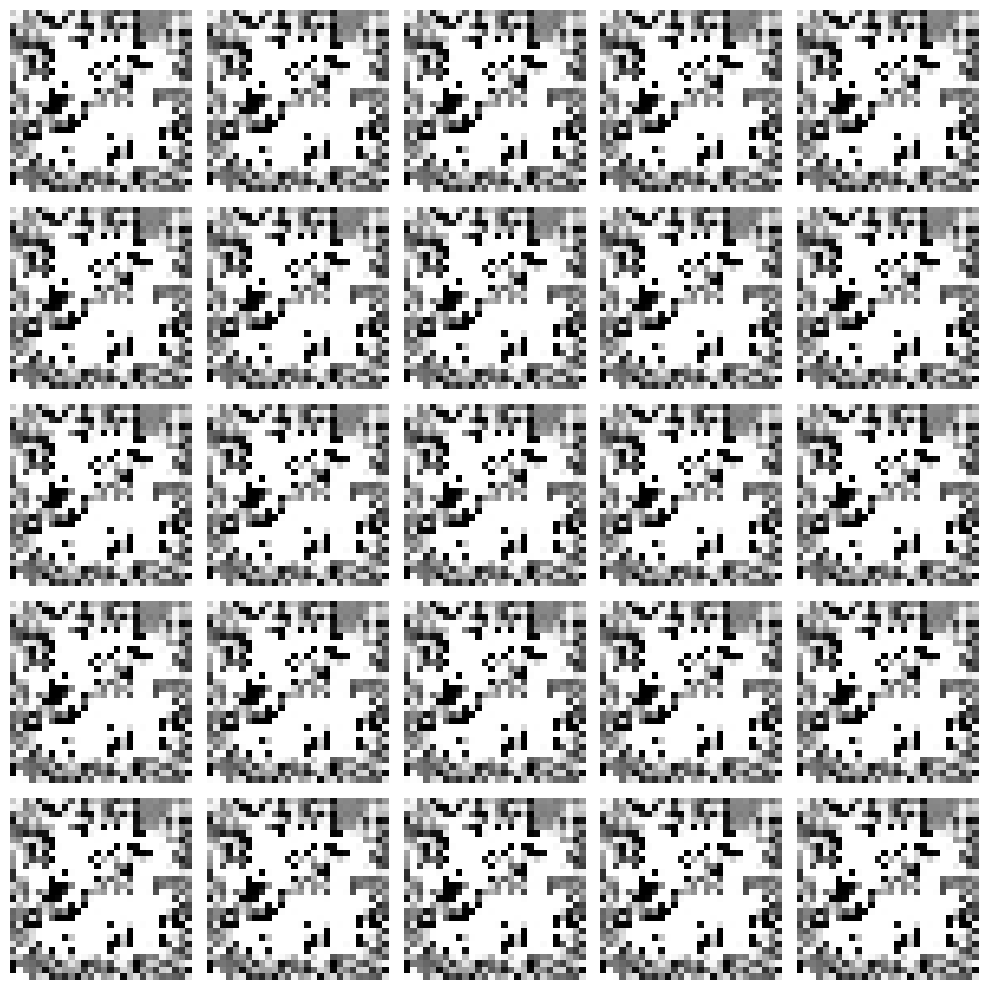

2/2 [==============================] - 0s 4ms/step
750 [D loss: 0.0005504738946910948, acc.: 100.0%] [G loss: 2.583038330078125]
1/1 [==============================] - 0s 17ms/step


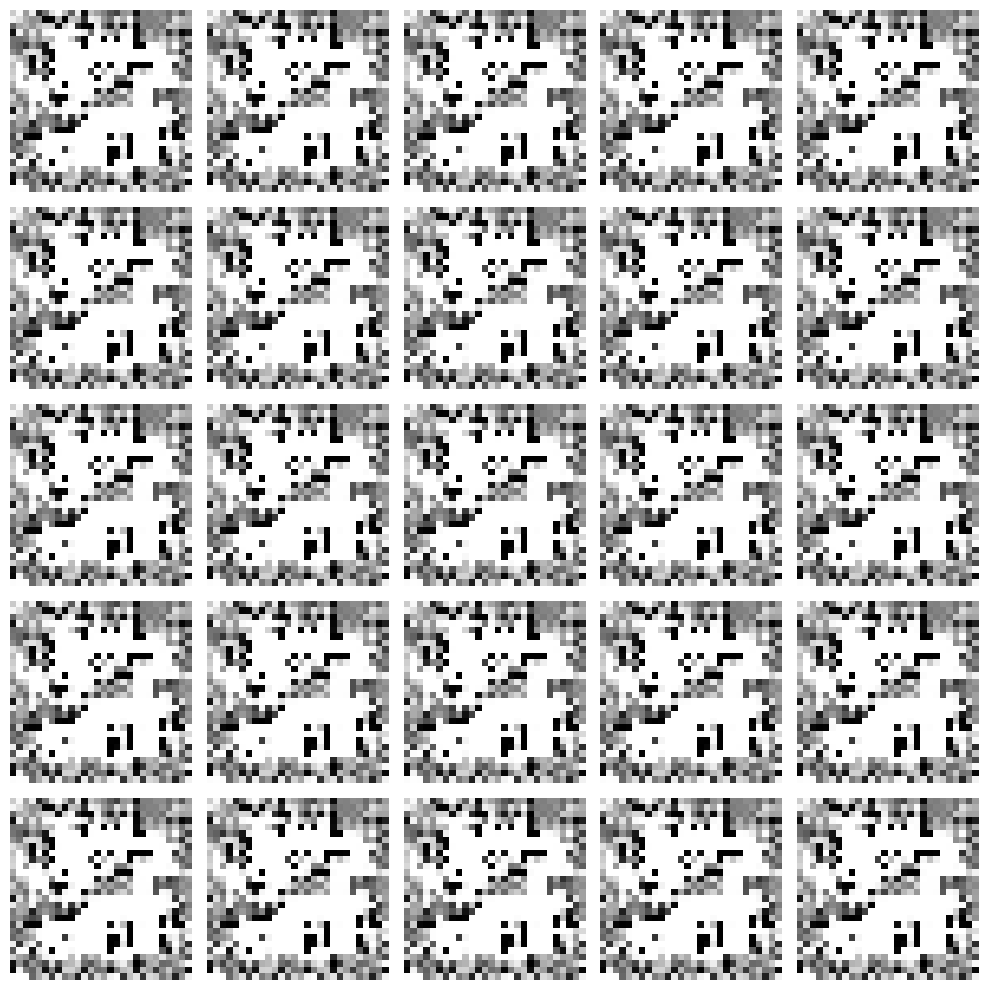

2/2 [==============================] - 0s 4ms/step
800 [D loss: 0.0005989743513055146, acc.: 100.0%] [G loss: 2.821298599243164]
1/1 [==============================] - 0s 18ms/step


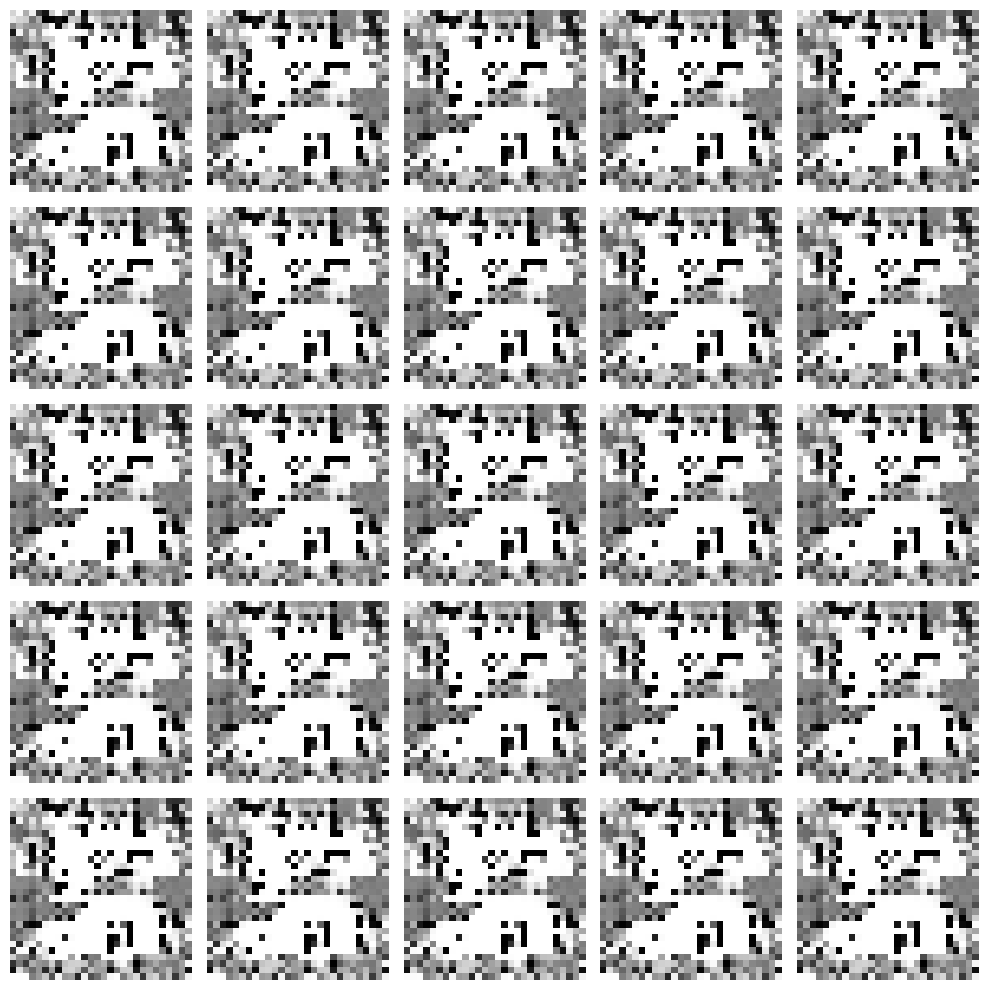

2/2 [==============================] - 0s 5ms/step
850 [D loss: 0.0006511453539133072, acc.: 100.0%] [G loss: 3.4098522663116455]
1/1 [==============================] - 0s 17ms/step


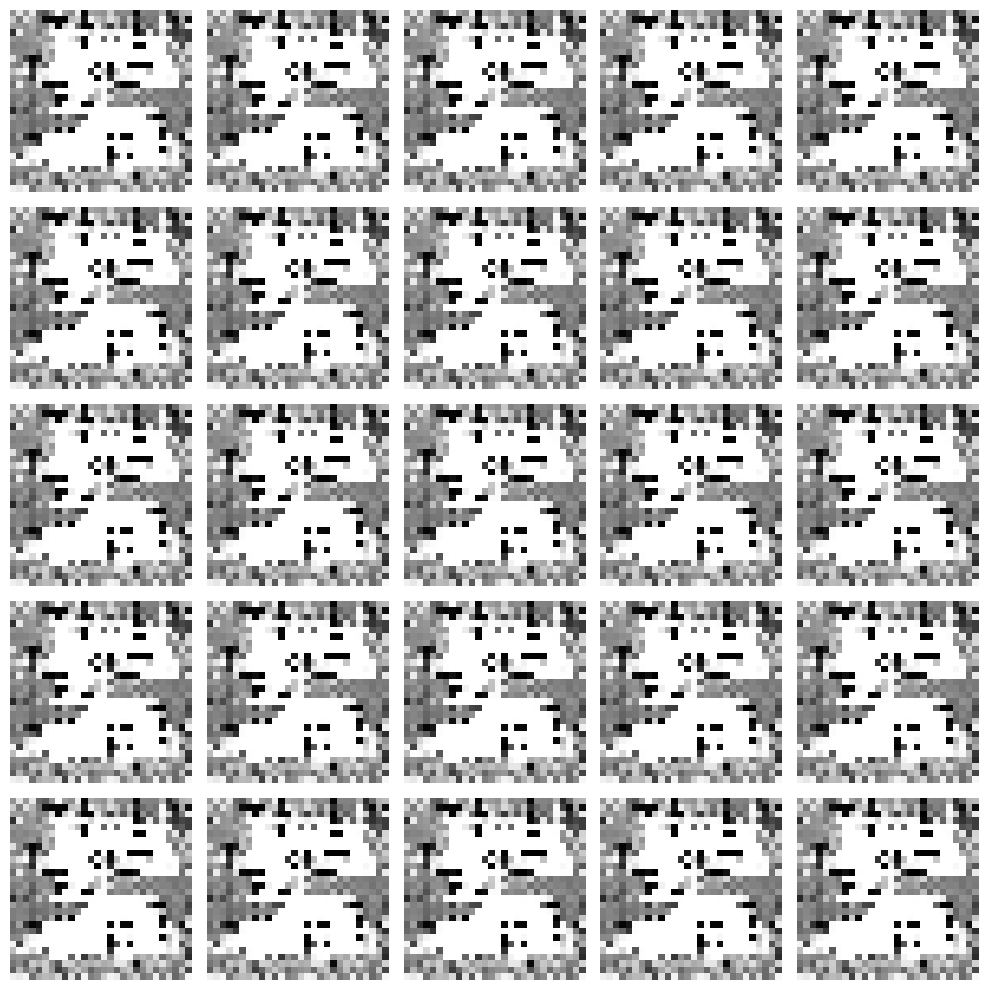

2/2 [==============================] - 0s 5ms/step
900 [D loss: 0.0009477950807195157, acc.: 100.0%] [G loss: 3.516464948654175]
1/1 [==============================] - 0s 17ms/step


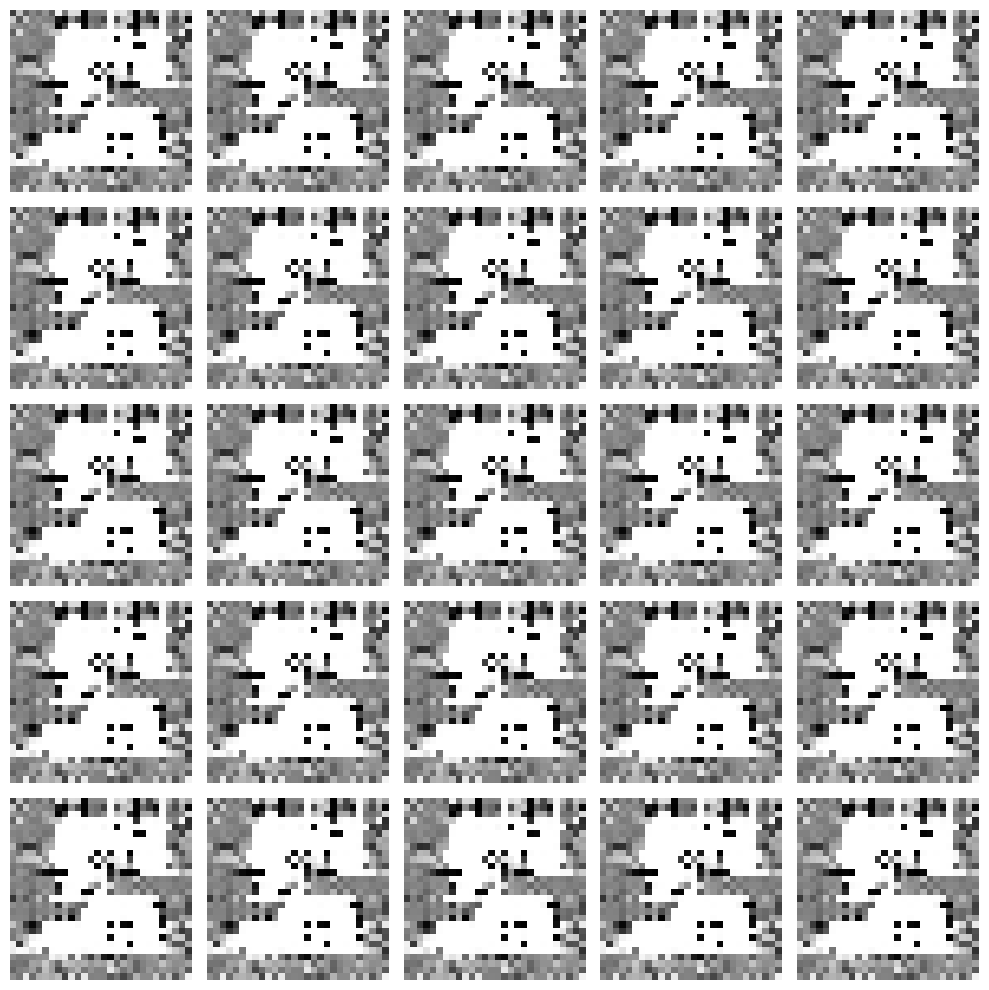

2/2 [==============================] - 0s 4ms/step
950 [D loss: 0.0009060511947609484, acc.: 100.0%] [G loss: 3.220270872116089]
1/1 [==============================] - 0s 18ms/step


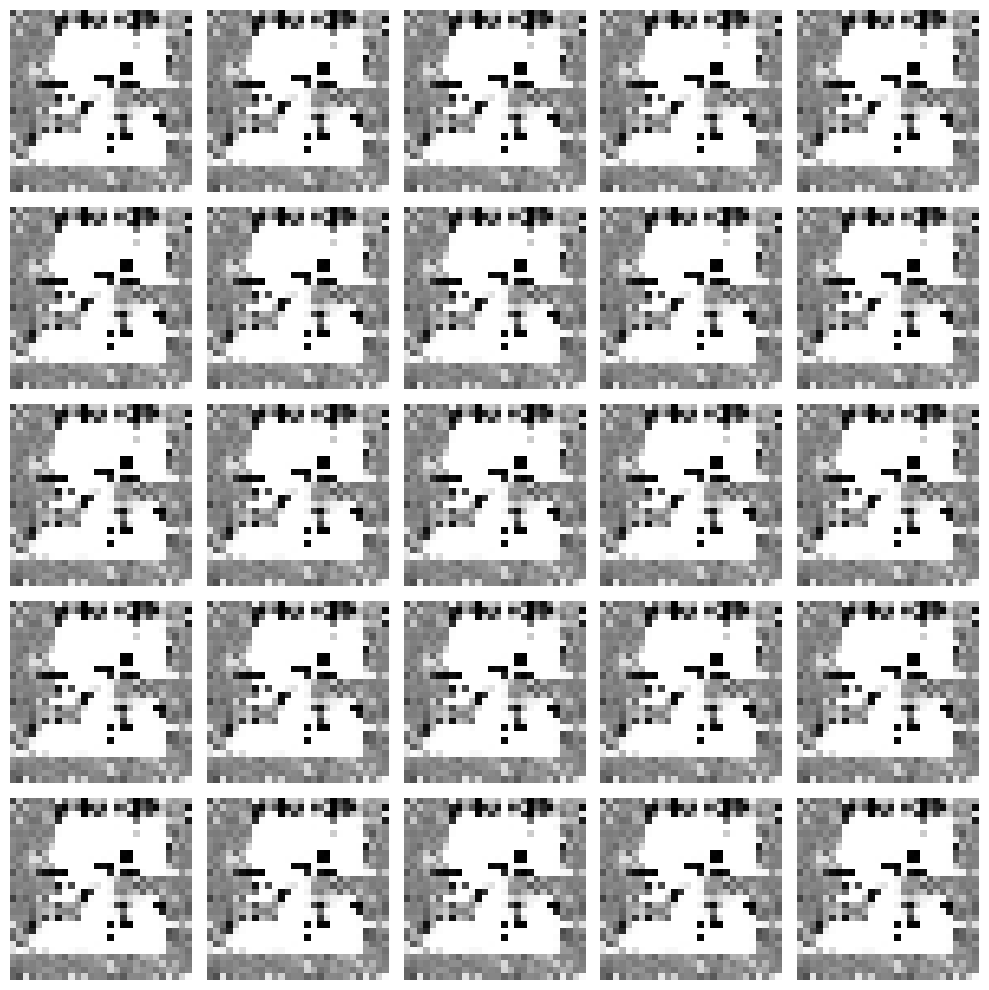

2/2 [==============================] - 0s 4ms/step
1000 [D loss: 0.0004629443137673661, acc.: 100.0%] [G loss: 2.577425956726074]
1/1 [==============================] - 0s 18ms/step


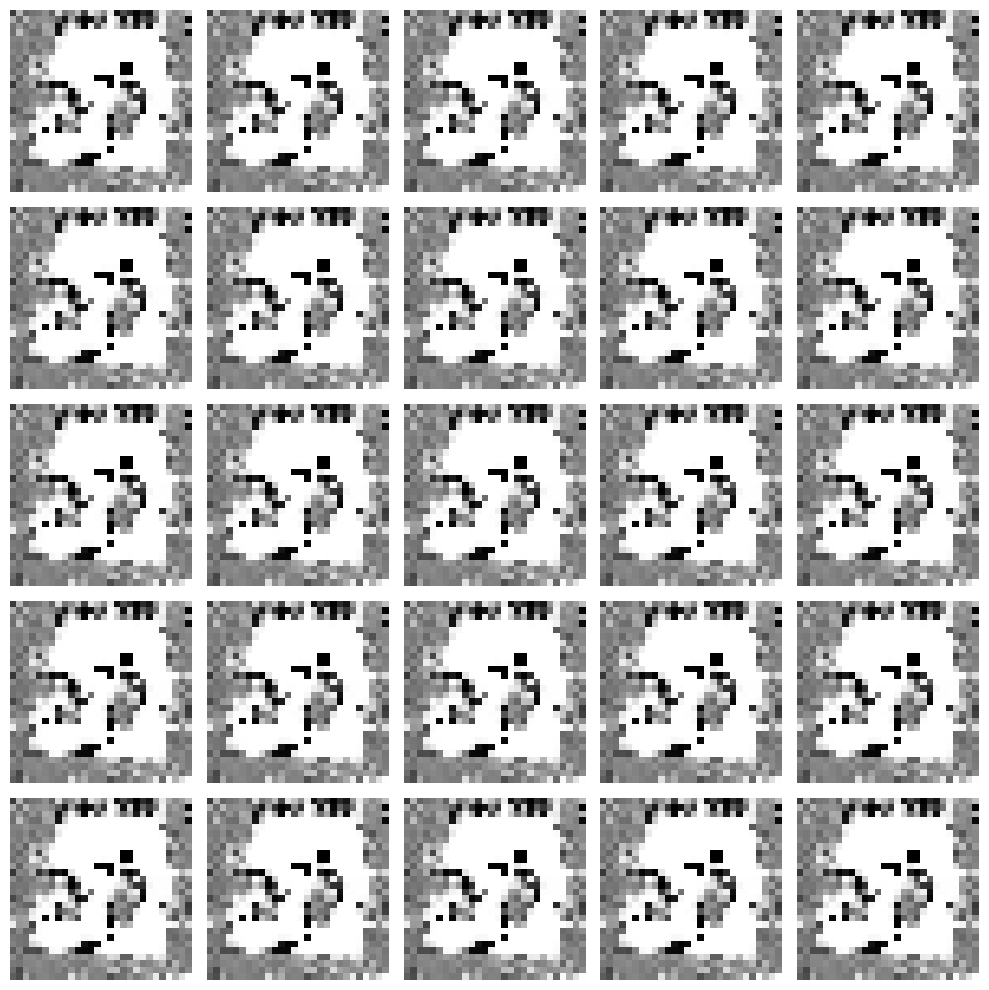

2/2 [==============================] - 0s 4ms/step
1050 [D loss: 0.0001886482277768664, acc.: 100.0%] [G loss: 2.6339850425720215]
1/1 [==============================] - 0s 17ms/step


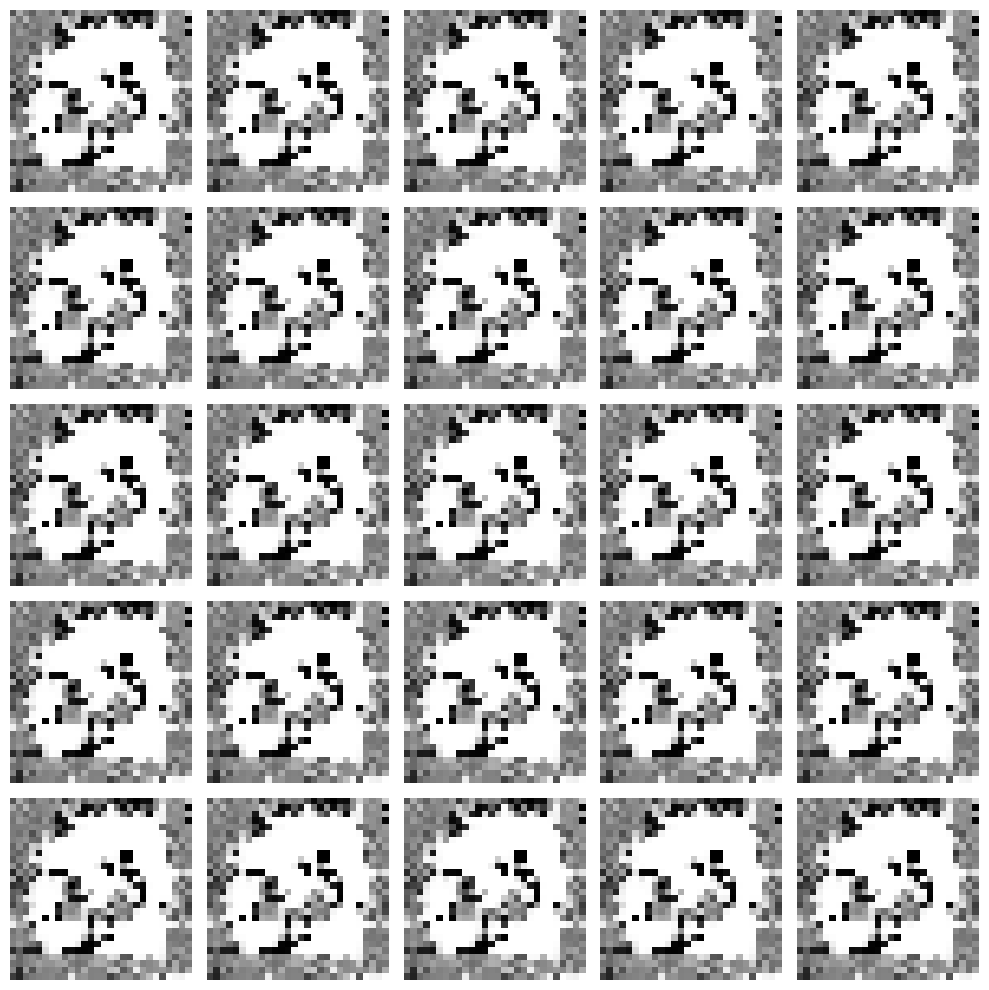

2/2 [==============================] - 0s 4ms/step
1100 [D loss: 0.00018667237236513756, acc.: 100.0%] [G loss: 2.936772346496582]
1/1 [==============================] - 0s 17ms/step


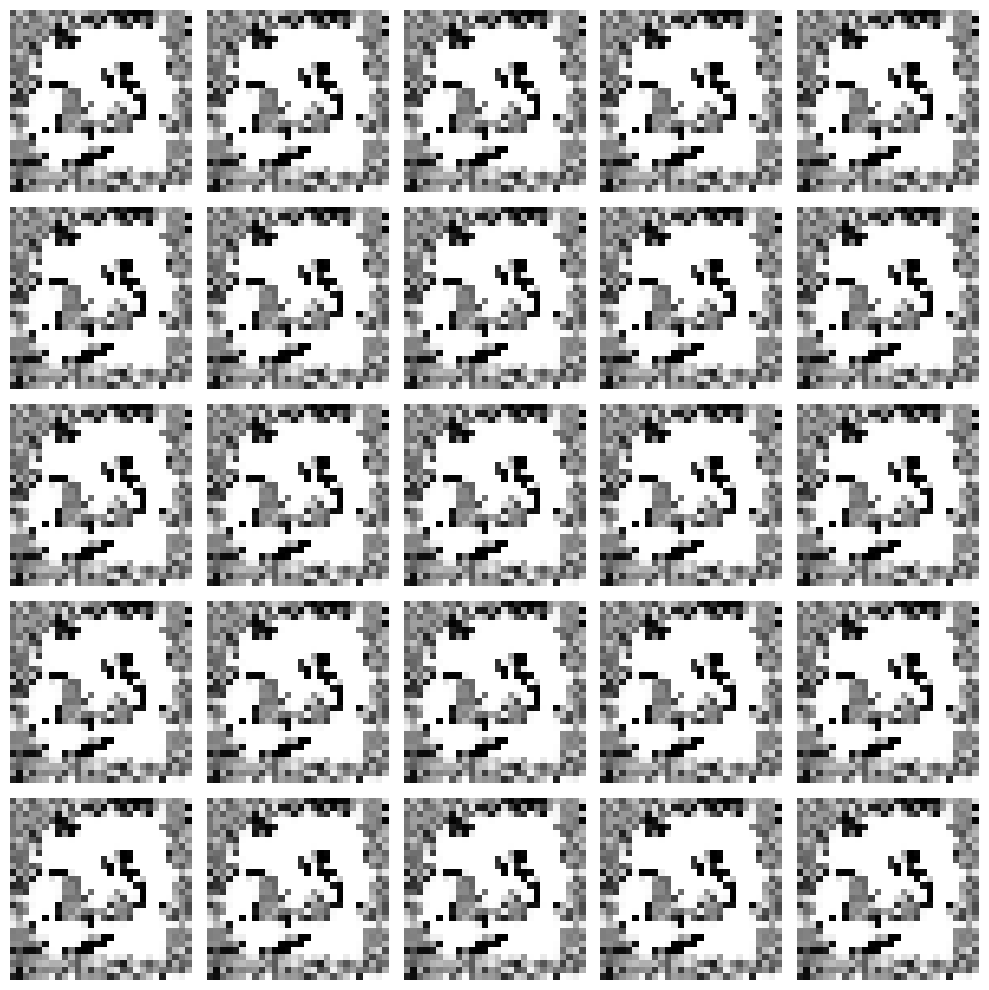

2/2 [==============================] - 0s 4ms/step
1150 [D loss: 7.152725447667763e-05, acc.: 100.0%] [G loss: 2.695559024810791]
1/1 [==============================] - 0s 18ms/step


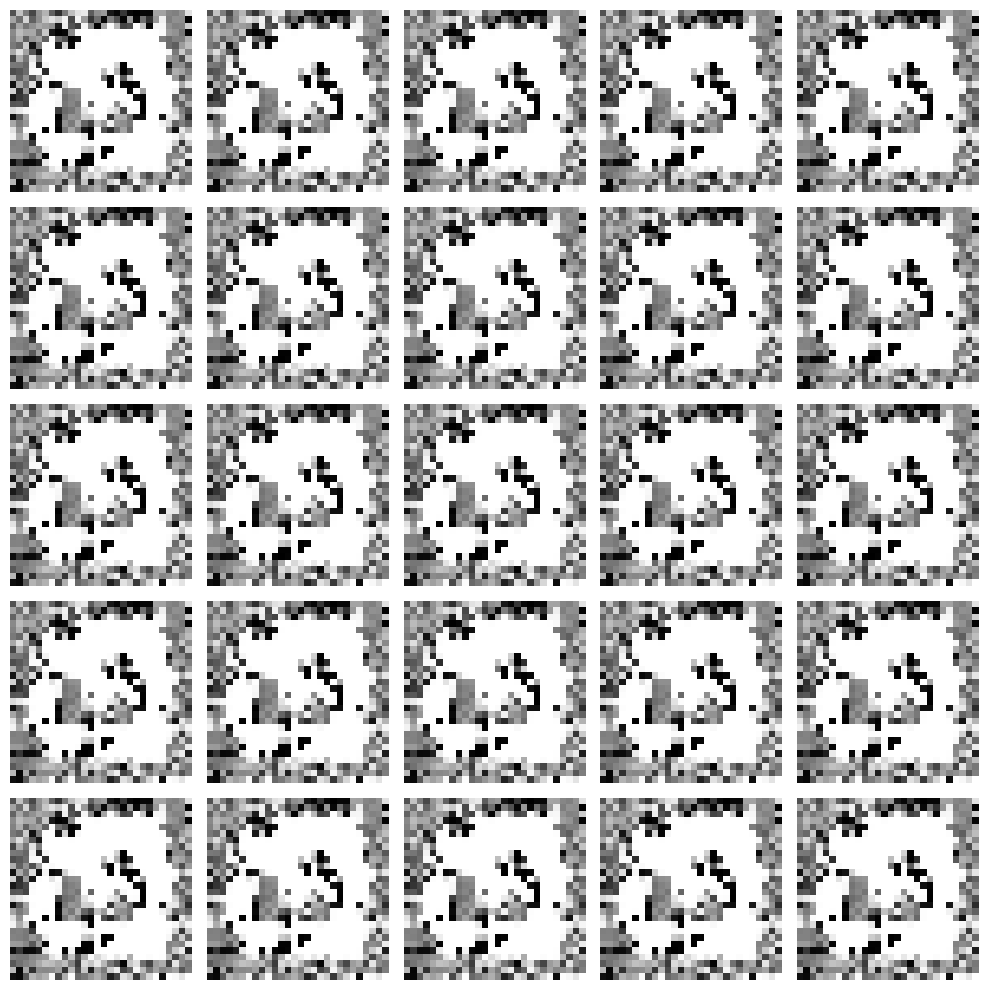

2/2 [==============================] - 0s 5ms/step
1200 [D loss: 0.00013963626406621188, acc.: 100.0%] [G loss: 2.3603506088256836]
1/1 [==============================] - 0s 18ms/step


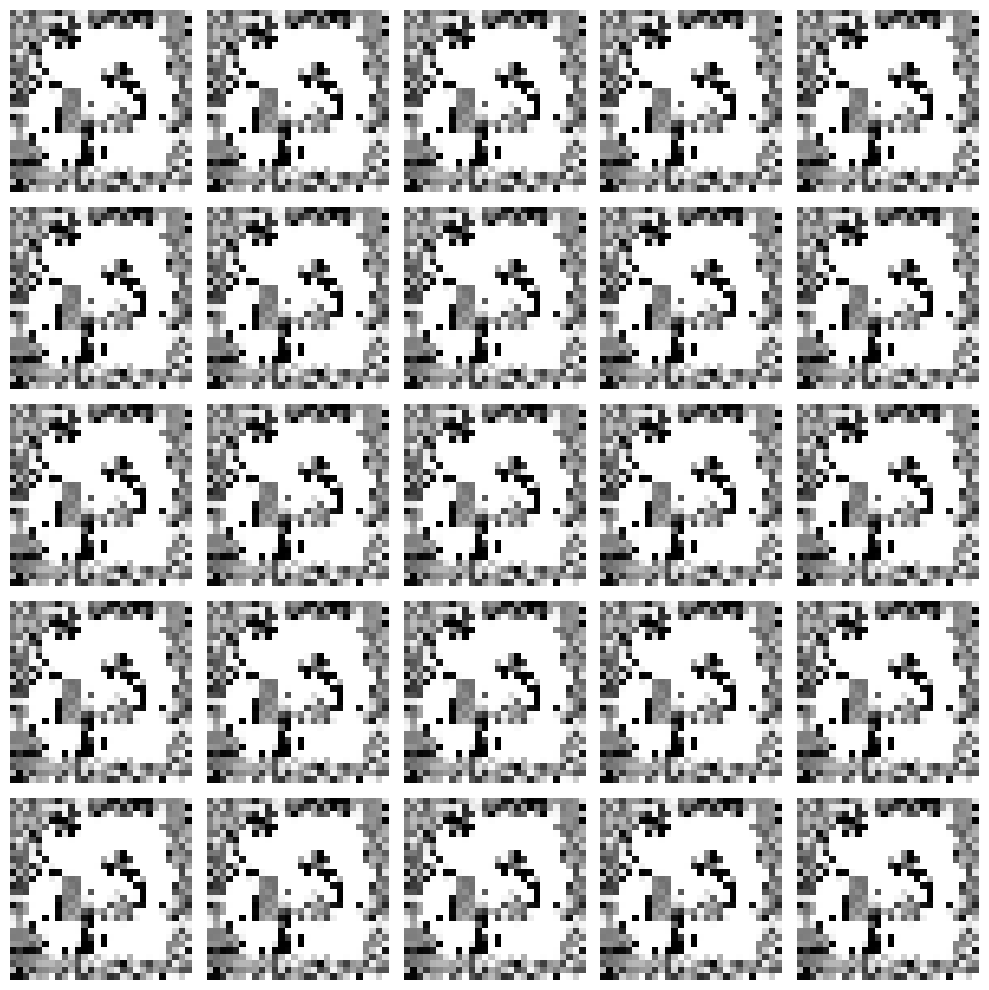

2/2 [==============================] - 0s 4ms/step
1250 [D loss: 8.95200082595693e-05, acc.: 100.0%] [G loss: 2.575587272644043]
1/1 [==============================] - 0s 18ms/step


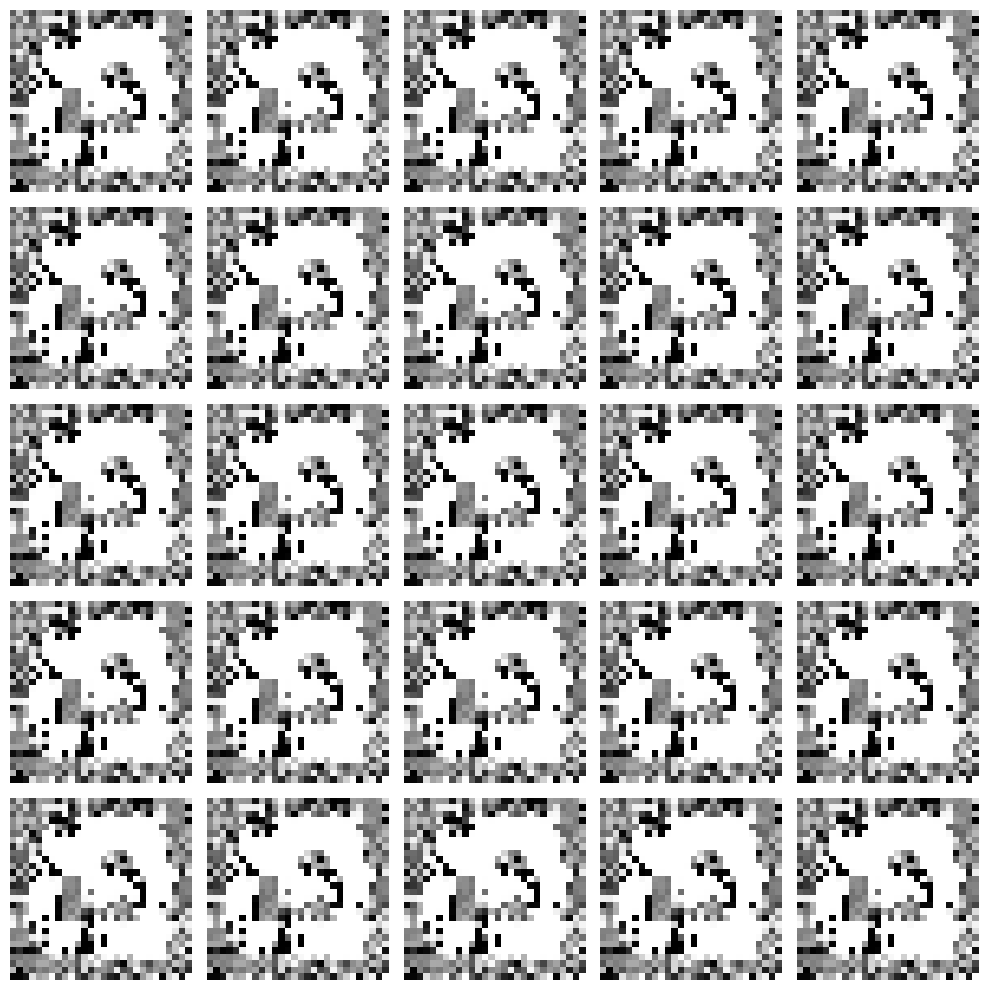

2/2 [==============================] - 0s 4ms/step
1300 [D loss: 9.122645133174956e-05, acc.: 100.0%] [G loss: 2.7438650131225586]
1/1 [==============================] - 0s 18ms/step


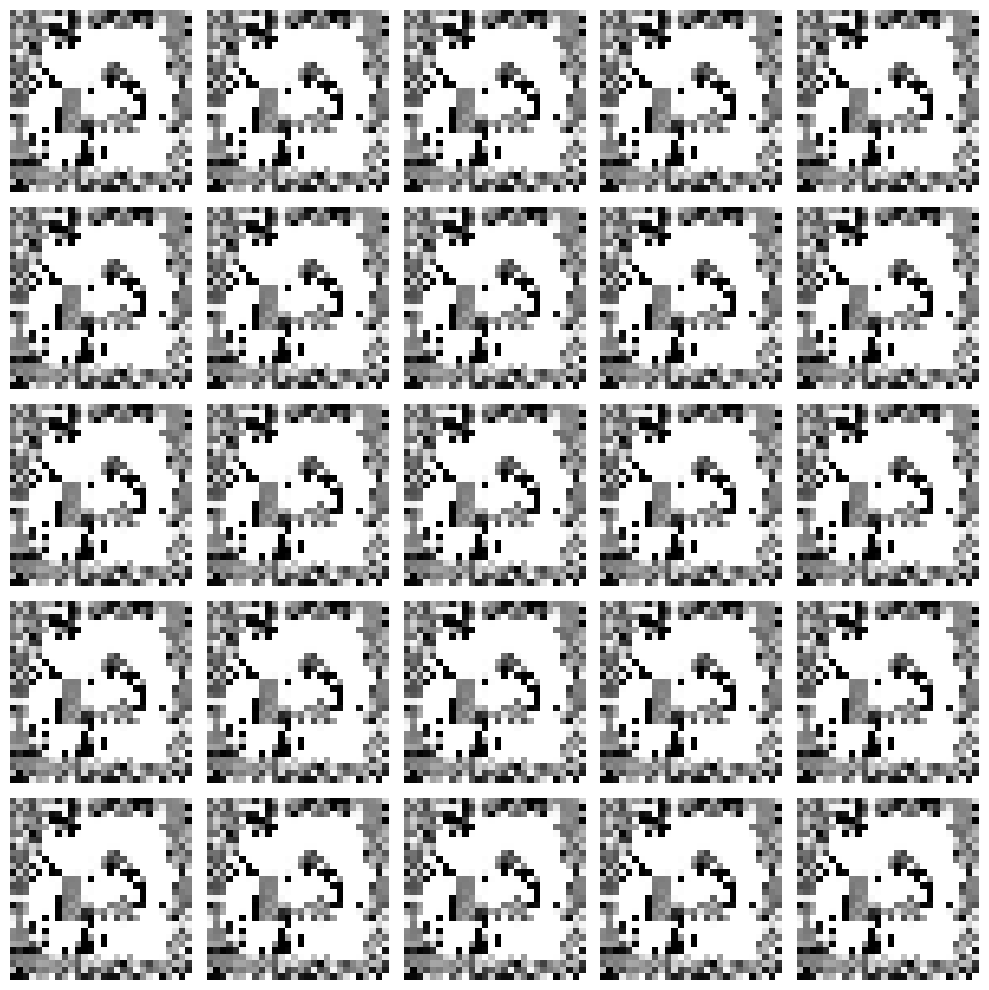

2/2 [==============================] - 0s 4ms/step
1350 [D loss: 0.00010034368824562989, acc.: 100.0%] [G loss: 2.6538033485412598]
1/1 [==============================] - 0s 19ms/step


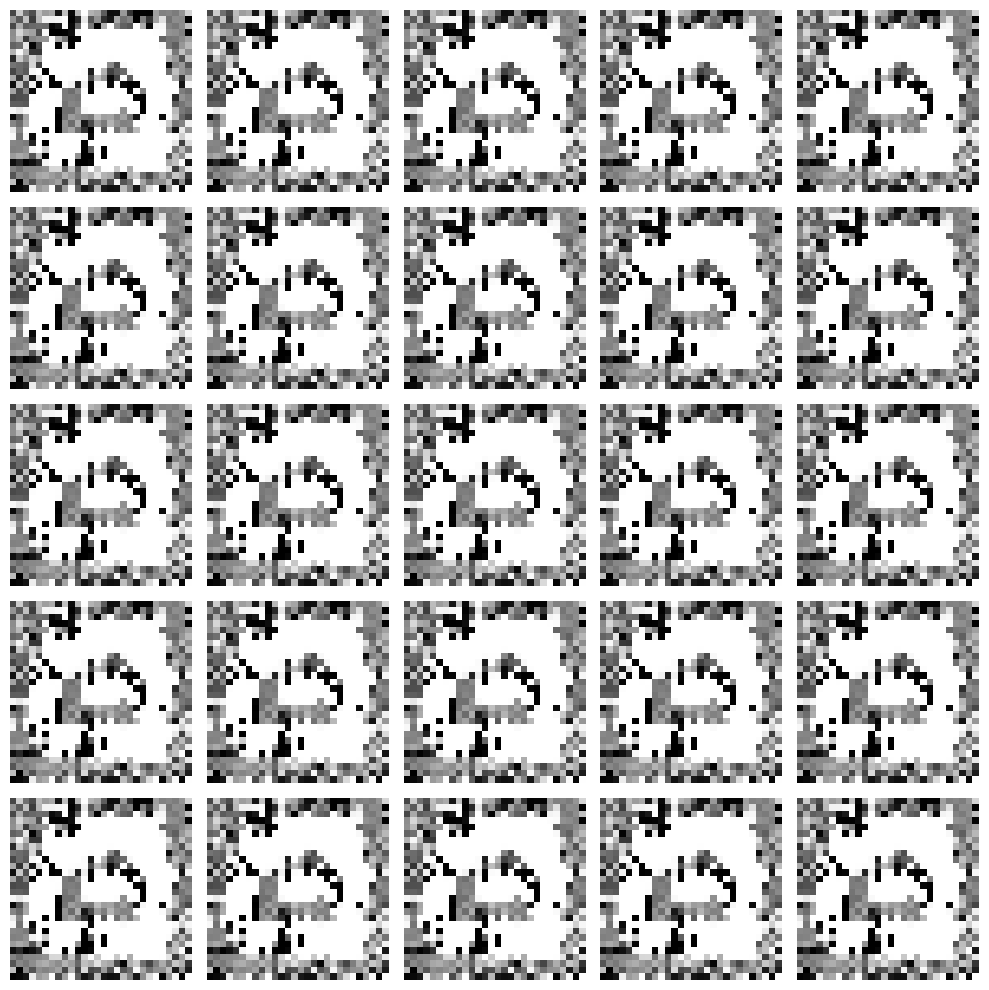

2/2 [==============================] - 0s 5ms/step
1400 [D loss: 7.156654100981541e-05, acc.: 100.0%] [G loss: 2.691744804382324]
1/1 [==============================] - 0s 17ms/step


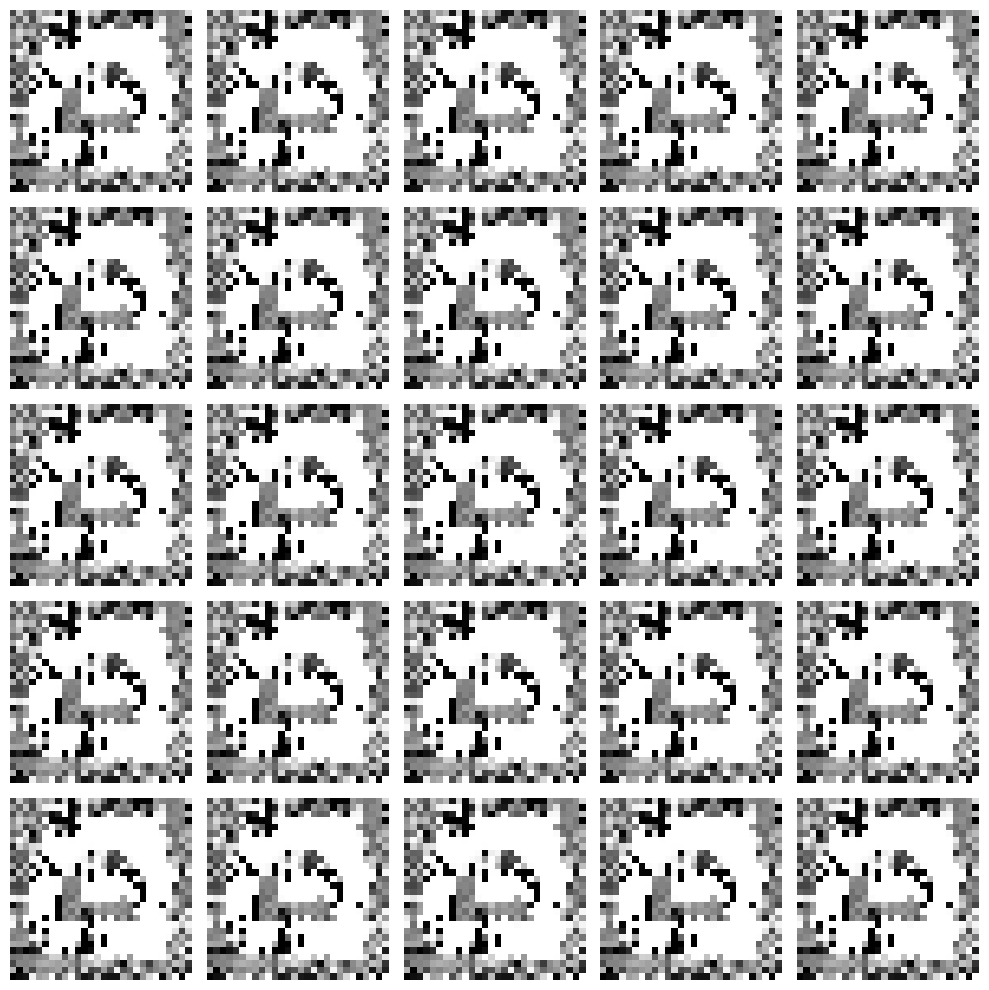

2/2 [==============================] - 0s 5ms/step
1450 [D loss: 3.9428850868716836e-05, acc.: 100.0%] [G loss: 2.97177791595459]
1/1 [==============================] - 0s 17ms/step


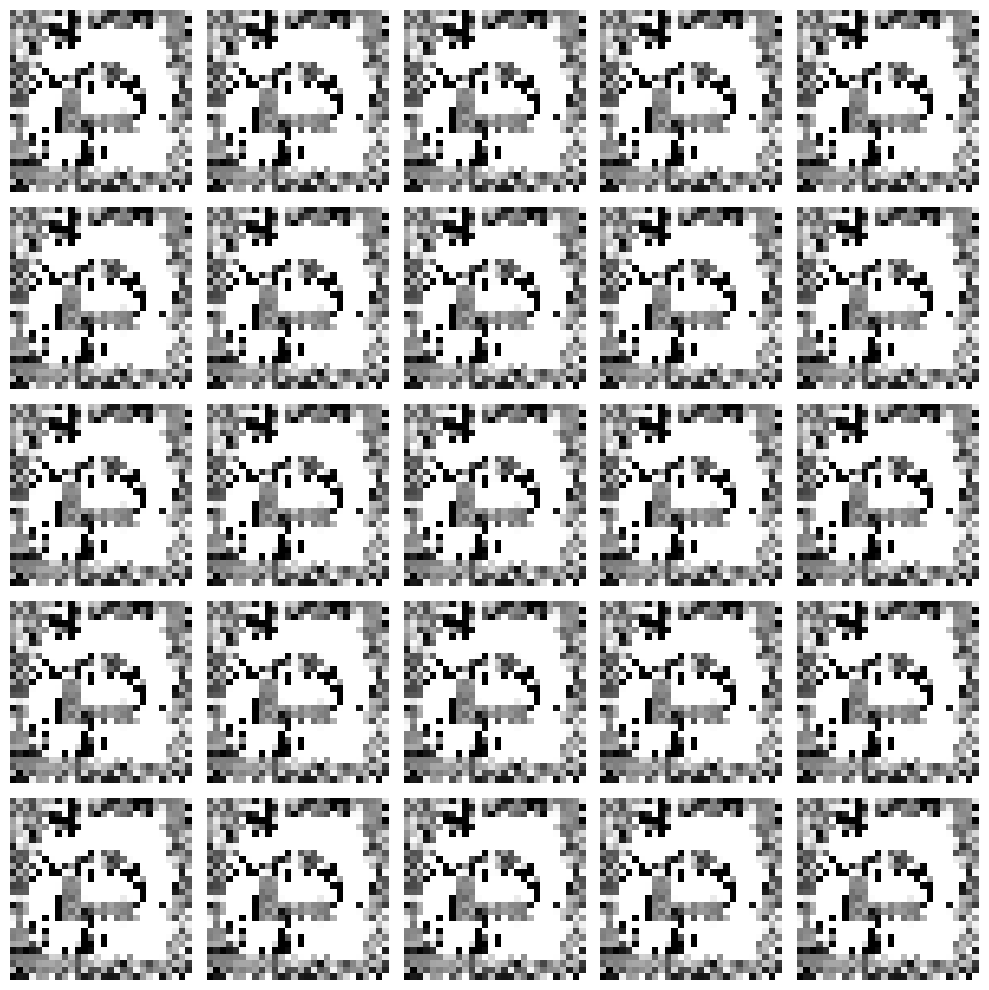

2/2 [==============================] - 0s 3ms/step
1500 [D loss: 8.50576088851085e-05, acc.: 100.0%] [G loss: 3.2405524253845215]
1/1 [==============================] - 0s 19ms/step


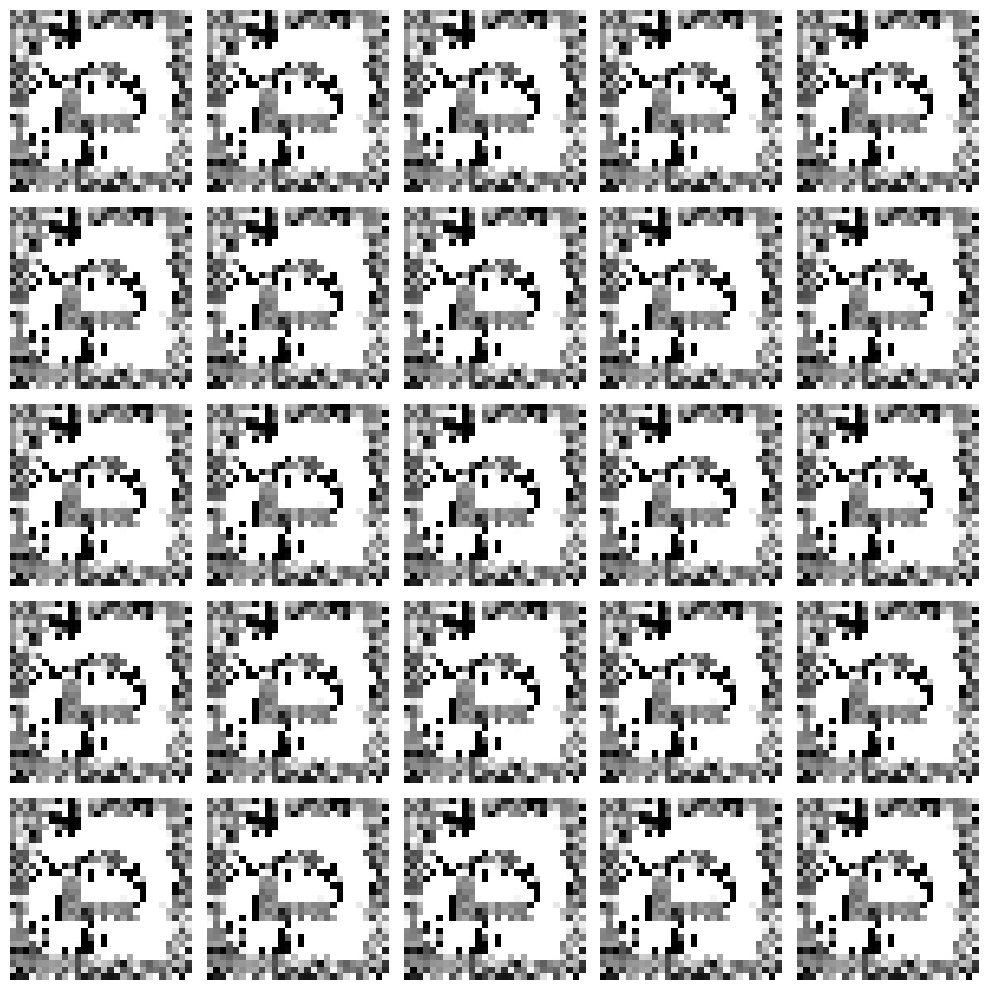

2/2 [==============================] - 0s 5ms/step
1550 [D loss: 3.5958990338258445e-05, acc.: 100.0%] [G loss: 3.139652729034424]
1/1 [==============================] - 0s 21ms/step


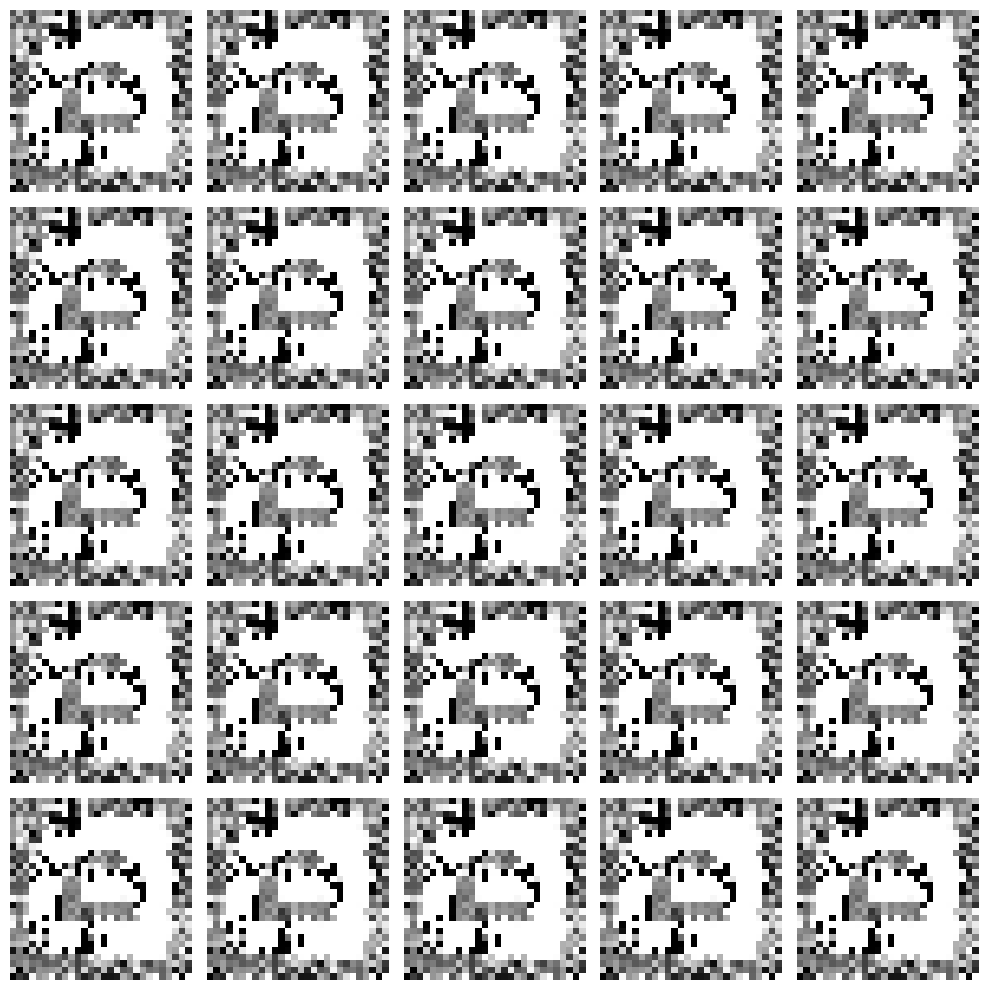

2/2 [==============================] - 0s 4ms/step
1600 [D loss: 2.770025639620144e-05, acc.: 100.0%] [G loss: 3.0384387969970703]
1/1 [==============================] - 0s 18ms/step


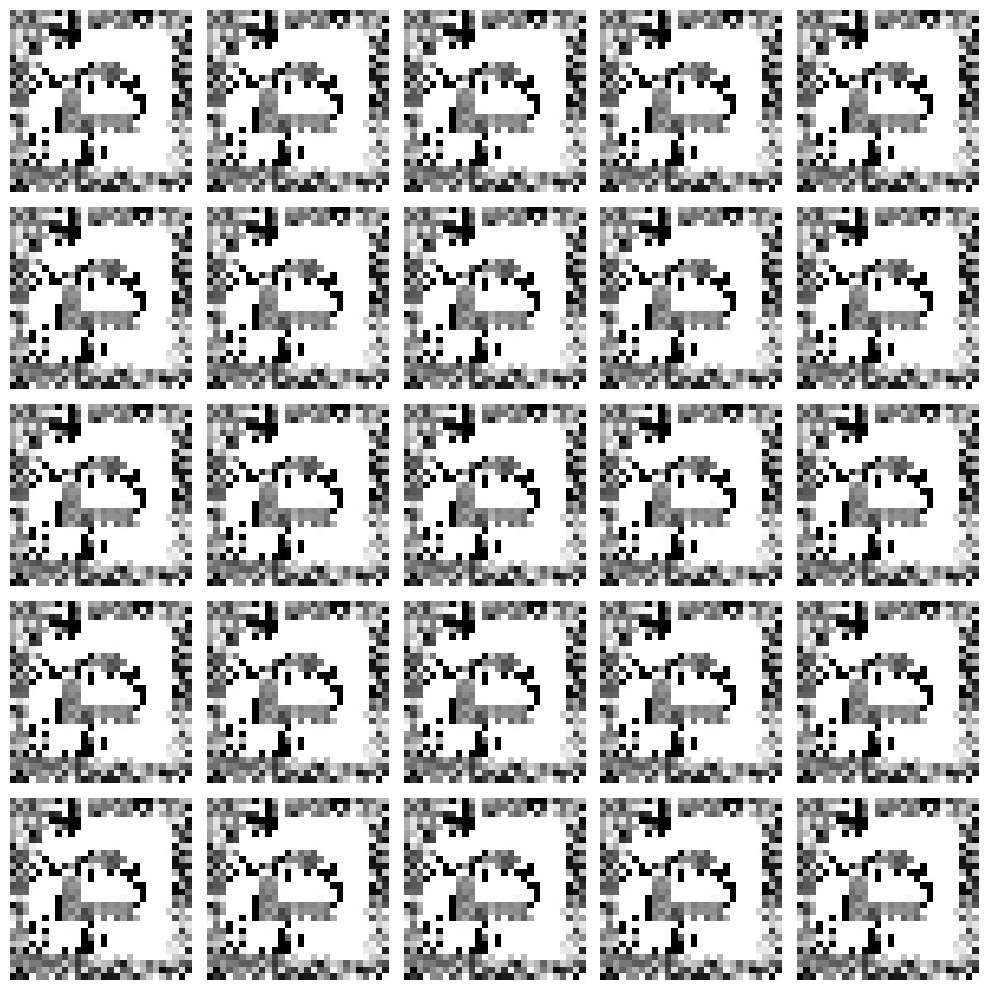

2/2 [==============================] - 0s 4ms/step
1650 [D loss: 2.1859020307601895e-05, acc.: 100.0%] [G loss: 3.00225567817688]
1/1 [==============================] - 0s 17ms/step


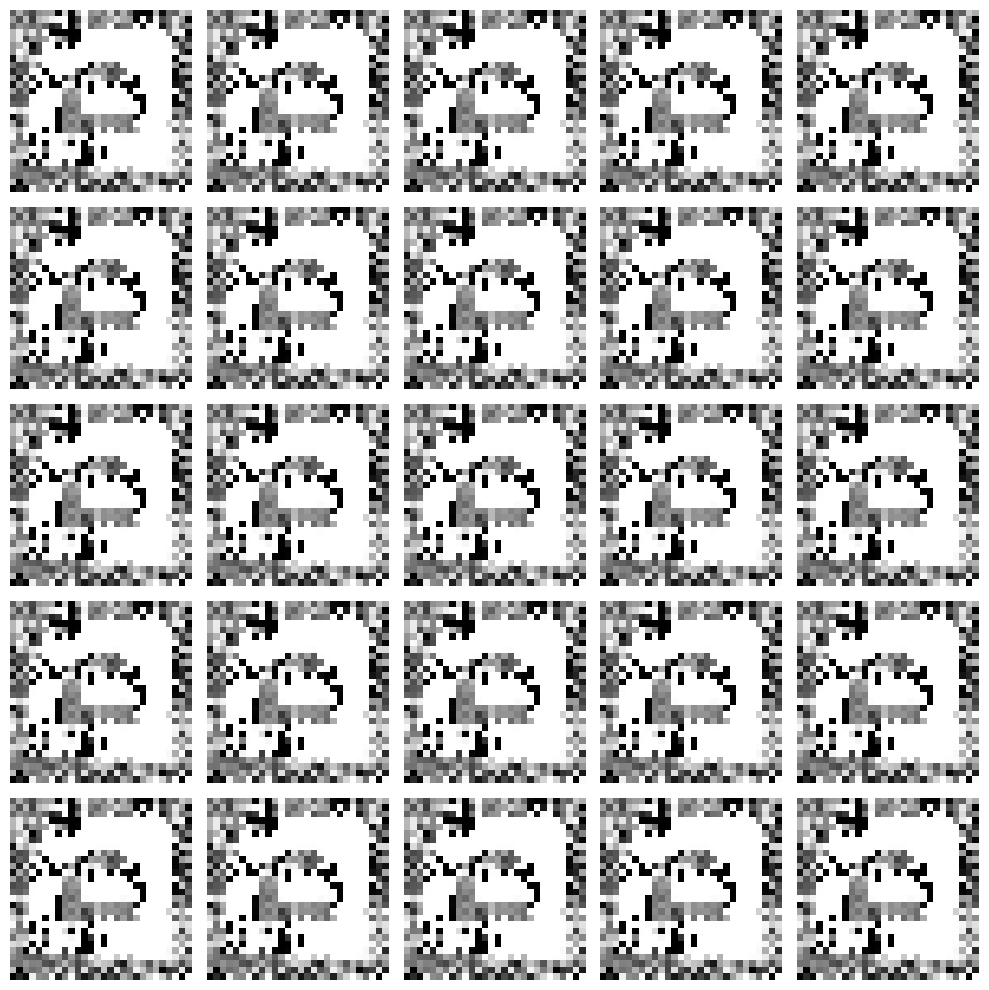

2/2 [==============================] - 0s 4ms/step
1700 [D loss: 4.188694947515614e-05, acc.: 100.0%] [G loss: 3.1450071334838867]
1/1 [==============================] - 0s 17ms/step


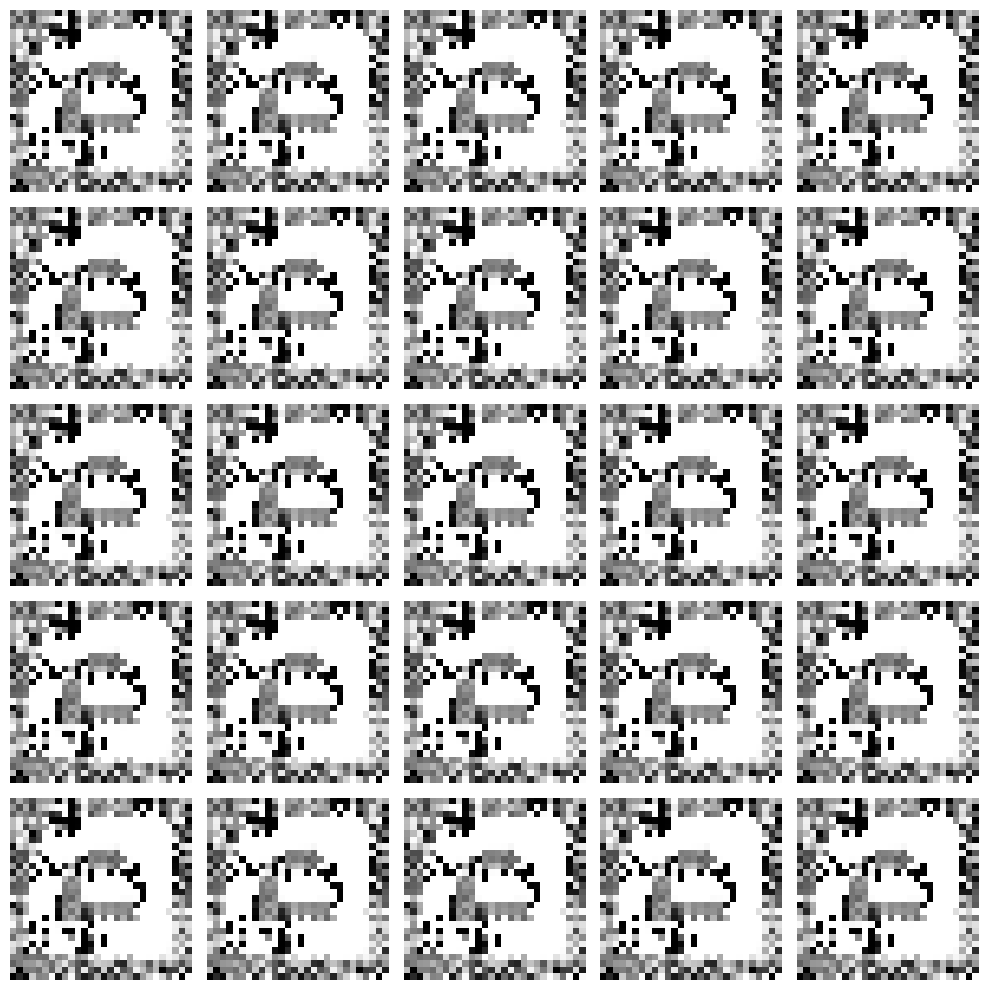

2/2 [==============================] - 0s 4ms/step
1750 [D loss: 3.262979316787096e-05, acc.: 100.0%] [G loss: 3.340153932571411]
1/1 [==============================] - 0s 17ms/step


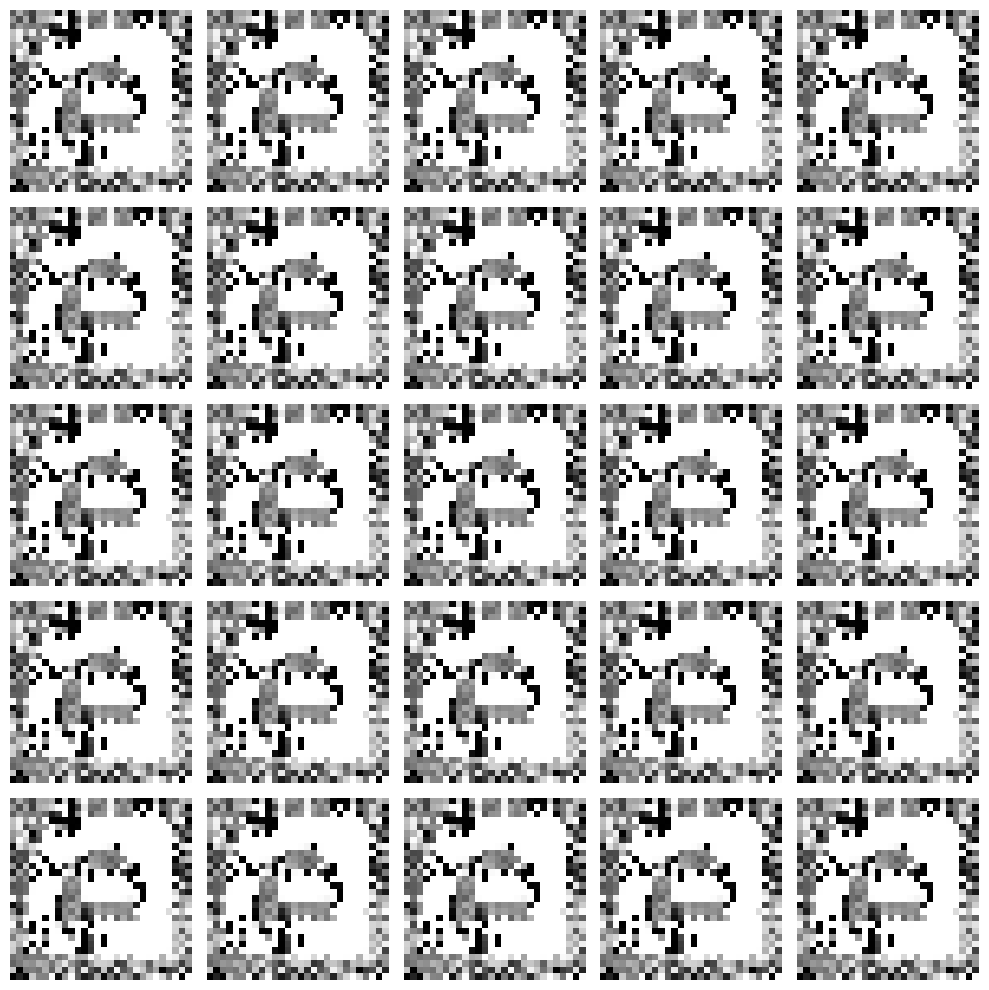

2/2 [==============================] - 0s 4ms/step
1800 [D loss: 6.174460759211797e-05, acc.: 100.0%] [G loss: 2.9621081352233887]
1/1 [==============================] - 0s 17ms/step


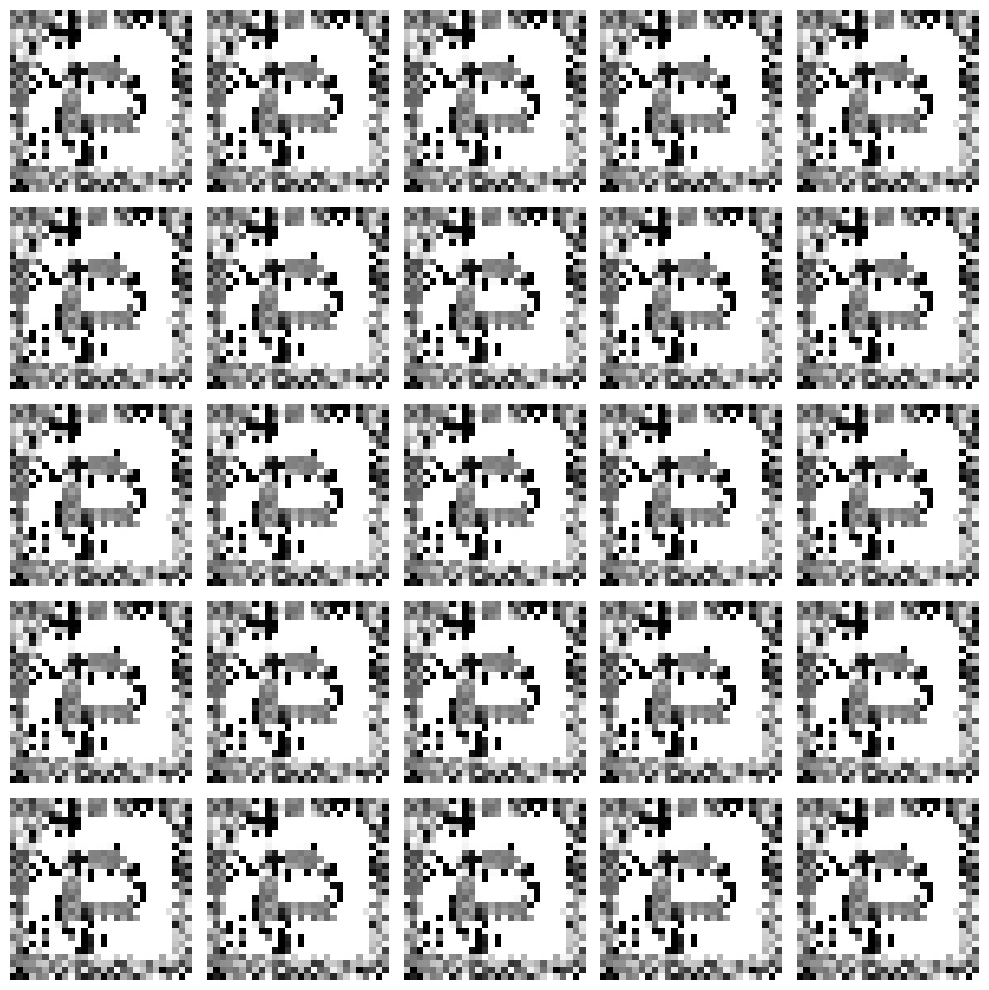

2/2 [==============================] - 0s 5ms/step
1850 [D loss: 1.2668492672673892e-05, acc.: 100.0%] [G loss: 2.715057373046875]
1/1 [==============================] - 0s 20ms/step


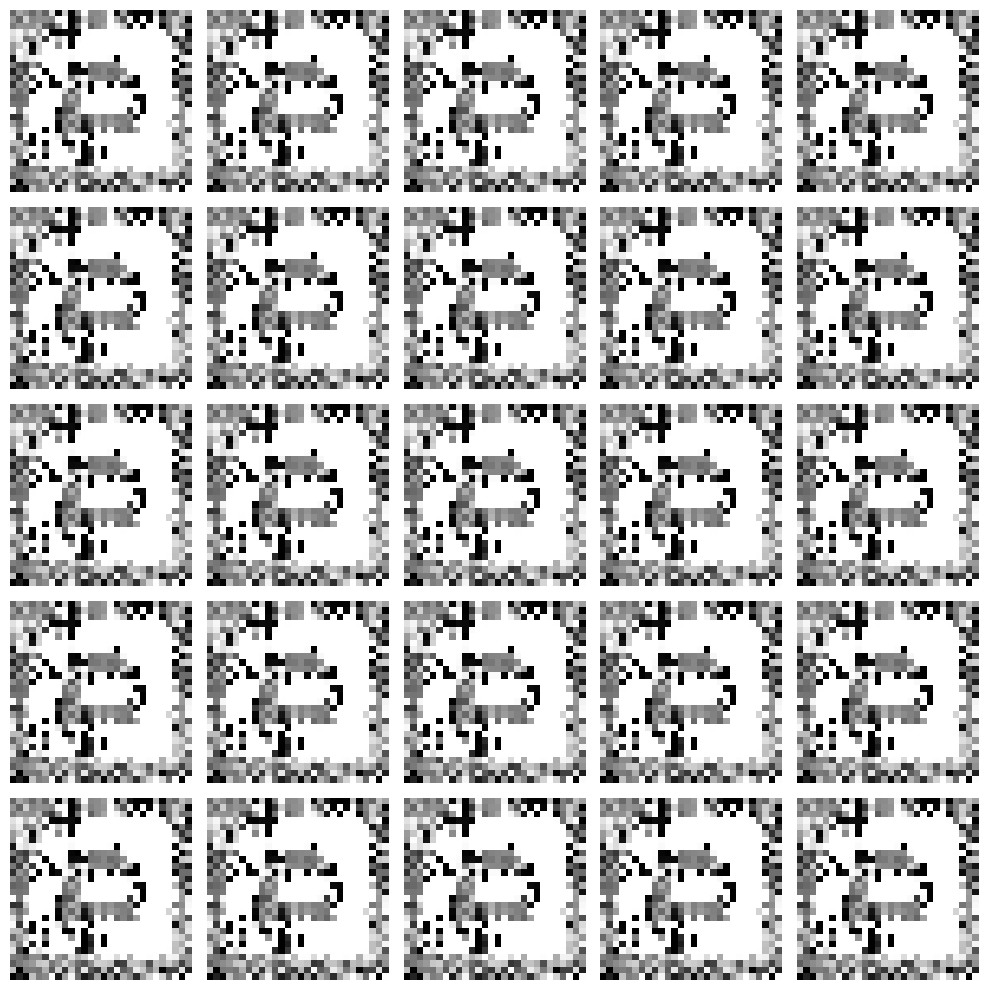

2/2 [==============================] - 0s 5ms/step
1900 [D loss: 3.2959147574729286e-05, acc.: 100.0%] [G loss: 3.2756309509277344]
1/1 [==============================] - 0s 19ms/step


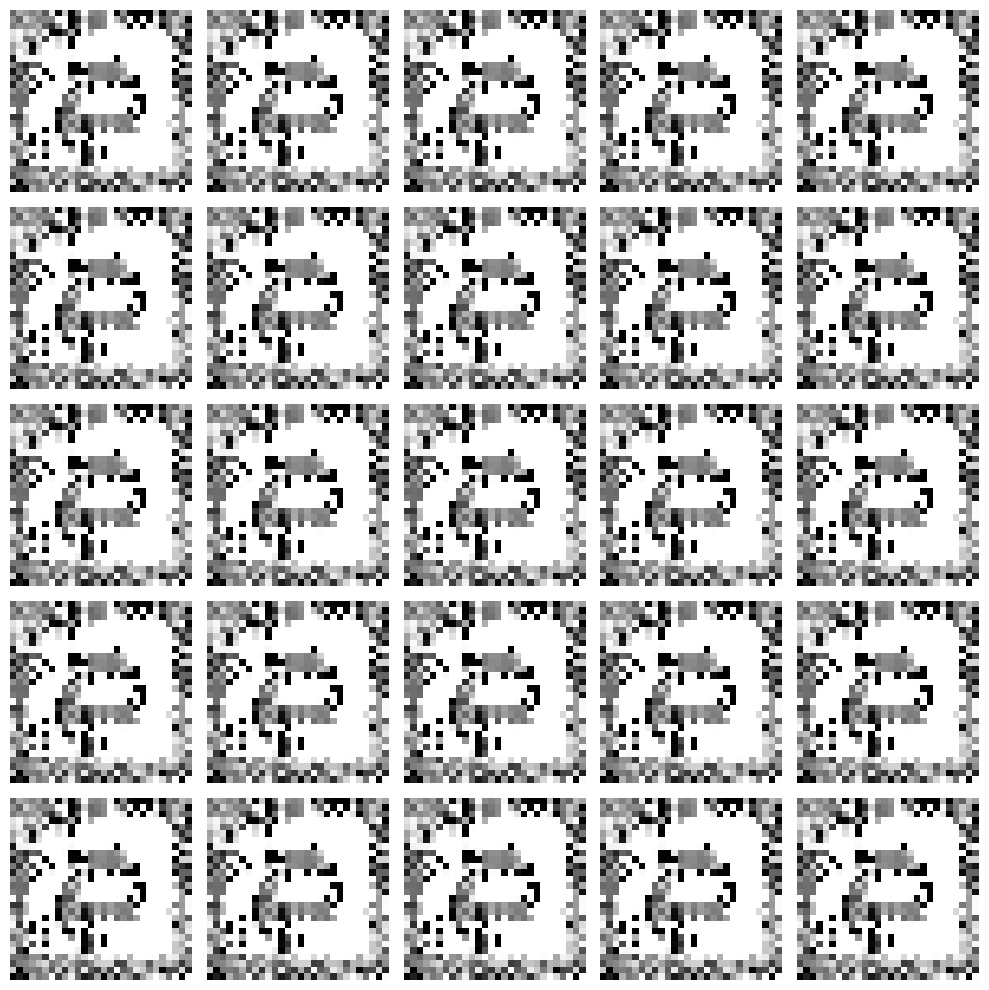

2/2 [==============================] - 0s 4ms/step
1950 [D loss: 2.5695688236737624e-05, acc.: 100.0%] [G loss: 3.3526272773742676]
1/1 [==============================] - 0s 18ms/step


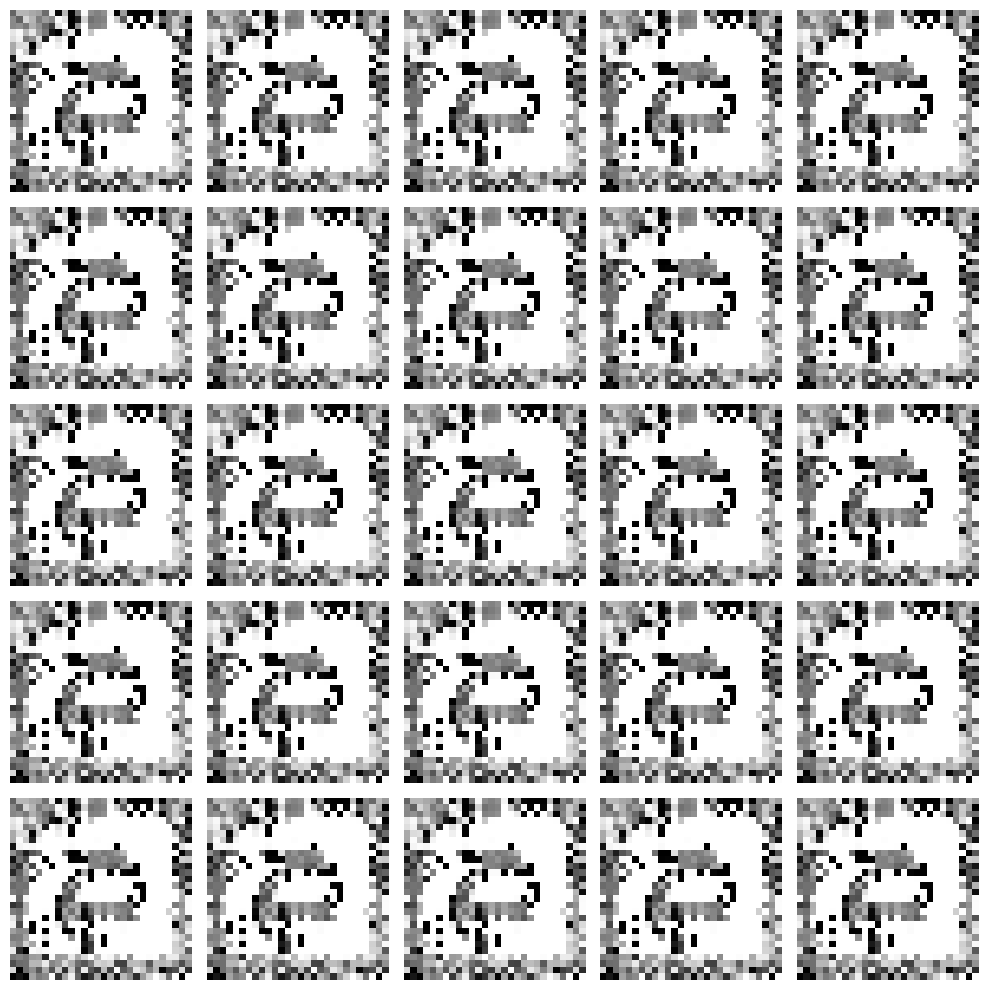

2/2 [==============================] - 0s 5ms/step
2000 [D loss: 2.5921113774529658e-05, acc.: 100.0%] [G loss: 3.35806941986084]
1/1 [==============================] - 0s 18ms/step


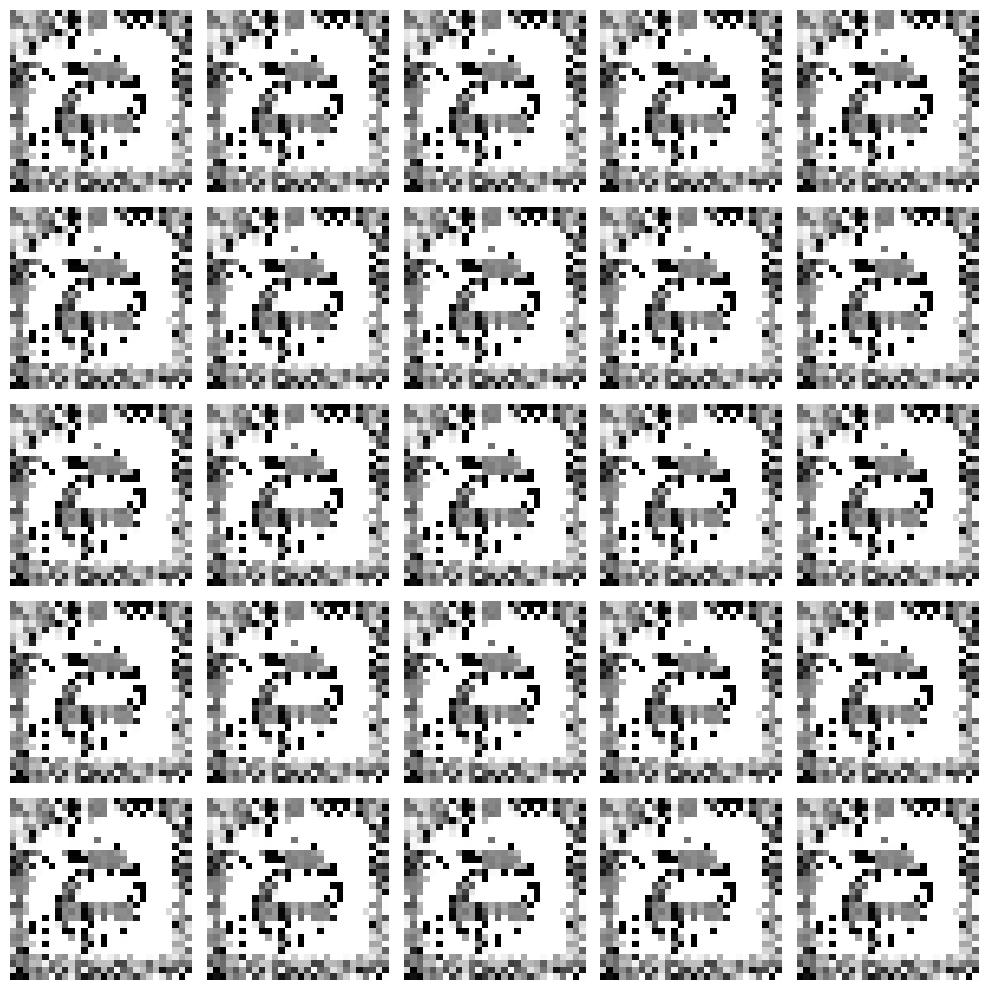

2/2 [==============================] - 0s 5ms/step
2050 [D loss: 9.575820968166227e-06, acc.: 100.0%] [G loss: 3.3710718154907227]
1/1 [==============================] - 0s 19ms/step


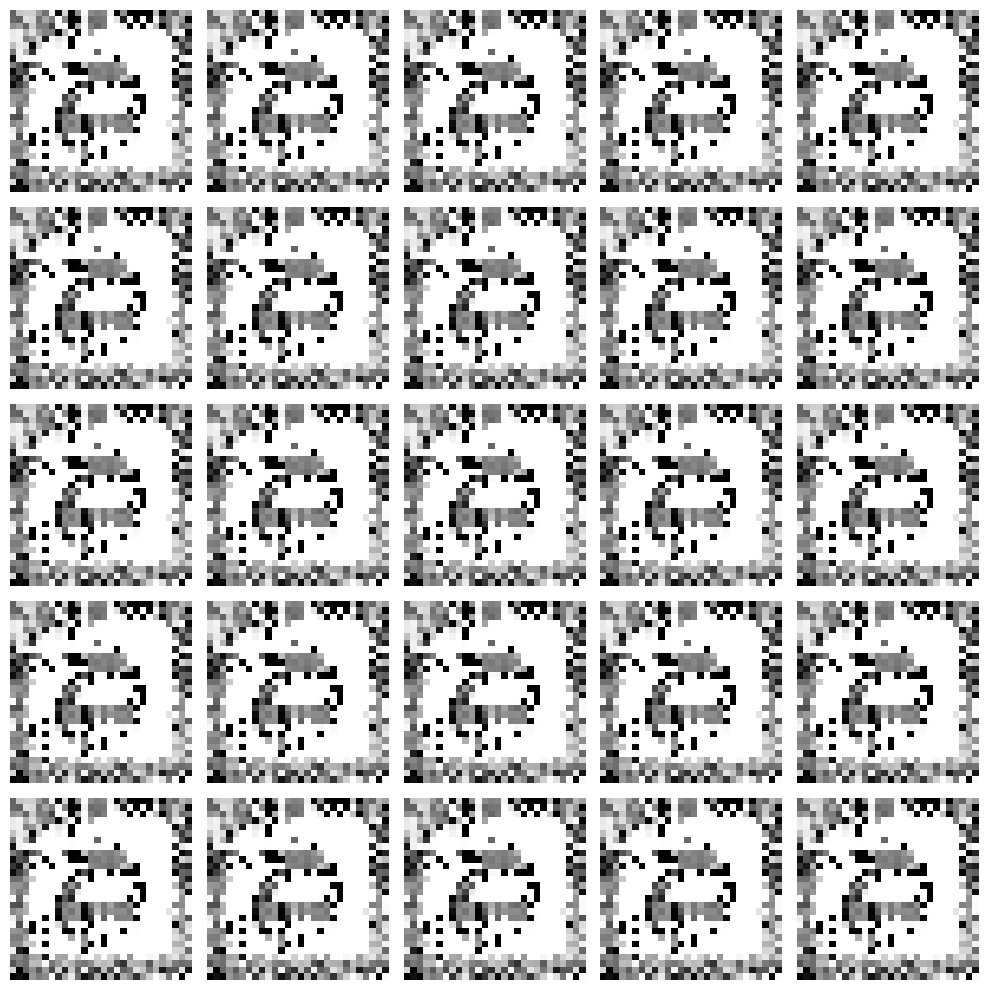

2/2 [==============================] - 0s 4ms/step
2100 [D loss: 1.409228525517392e-05, acc.: 100.0%] [G loss: 2.8963050842285156]
1/1 [==============================] - 0s 18ms/step


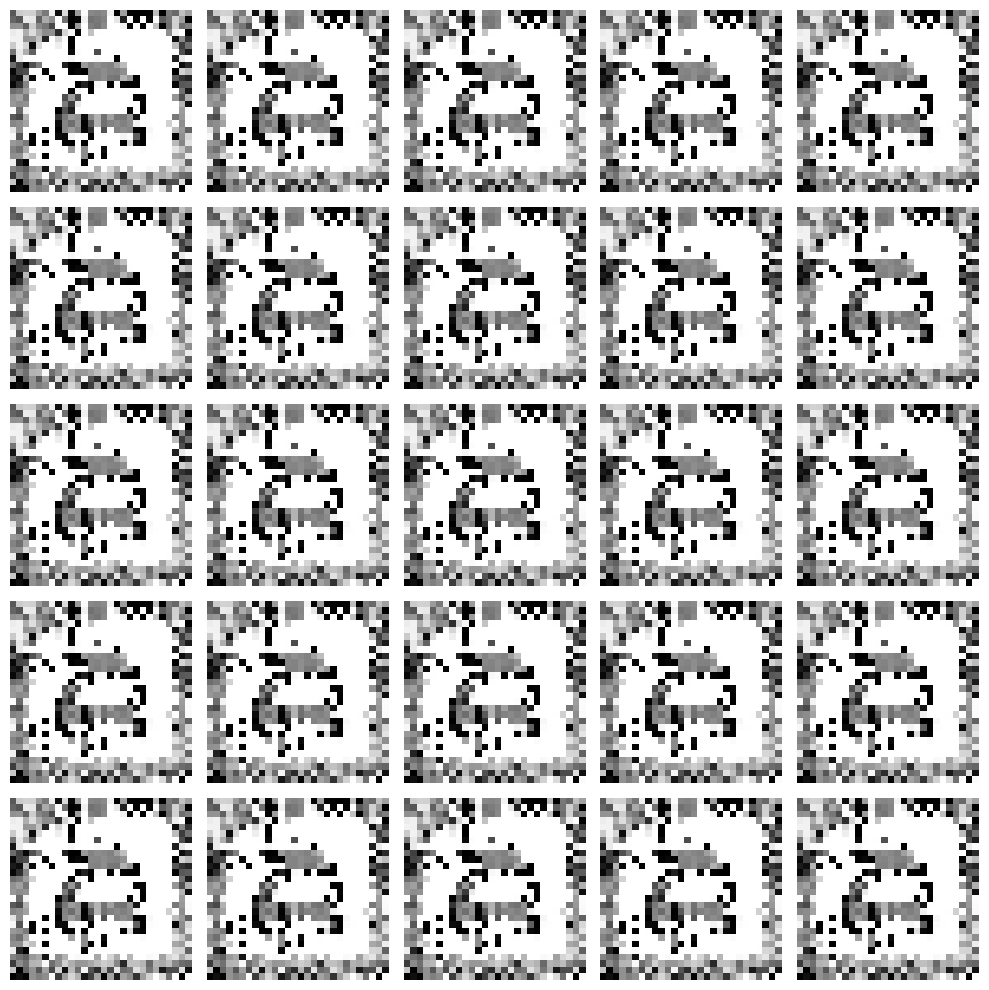

2/2 [==============================] - 0s 4ms/step
2150 [D loss: 2.7705779757525306e-05, acc.: 100.0%] [G loss: 3.399522542953491]
1/1 [==============================] - 0s 16ms/step


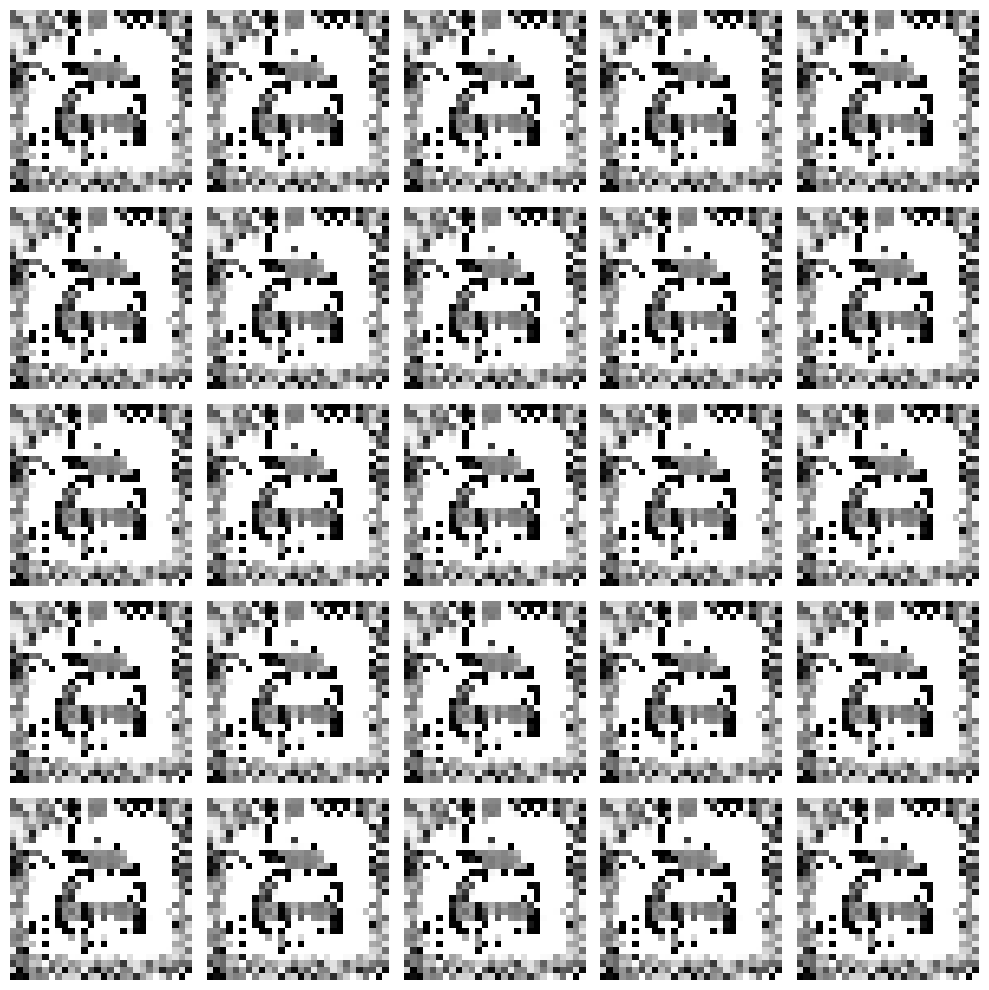

2/2 [==============================] - 0s 4ms/step
2200 [D loss: 1.149386253018747e-05, acc.: 100.0%] [G loss: 3.126011371612549]
1/1 [==============================] - 0s 17ms/step


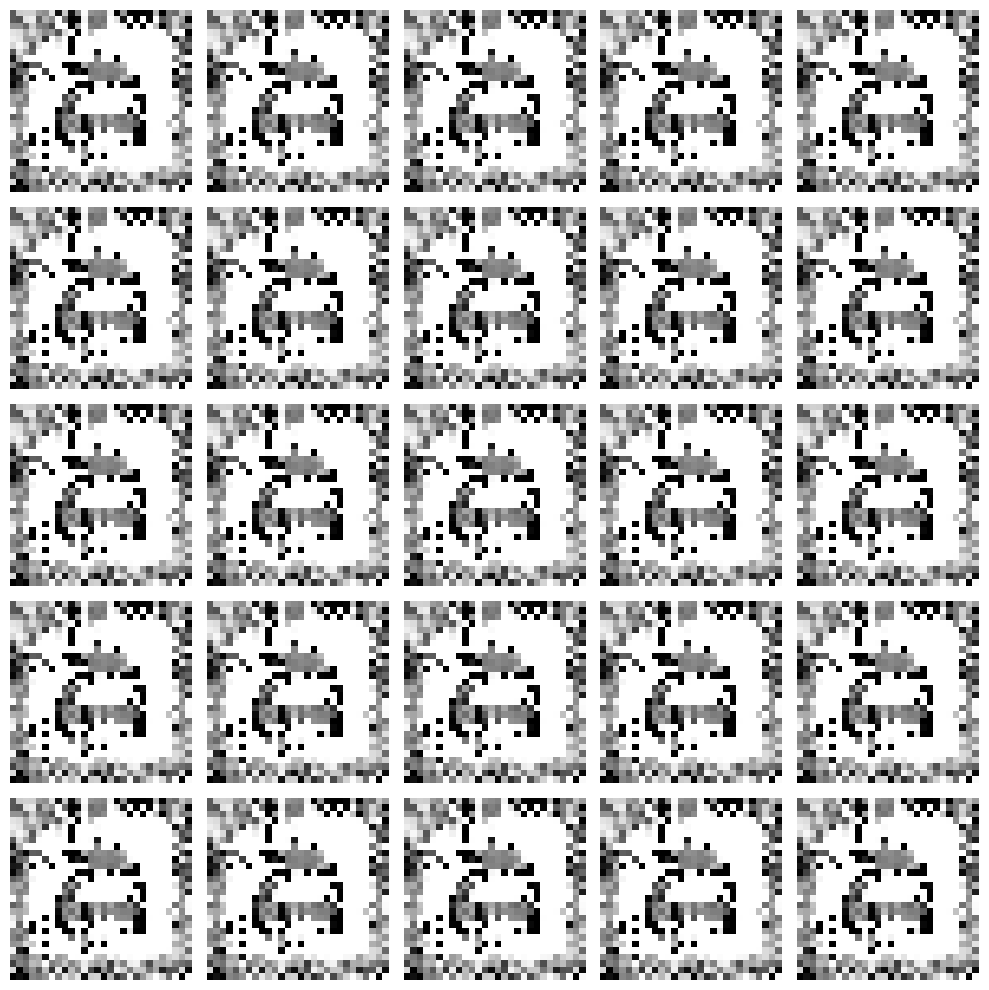

2/2 [==============================] - 0s 4ms/step
2250 [D loss: 9.888475688057952e-06, acc.: 100.0%] [G loss: 3.274374485015869]
1/1 [==============================] - 0s 18ms/step


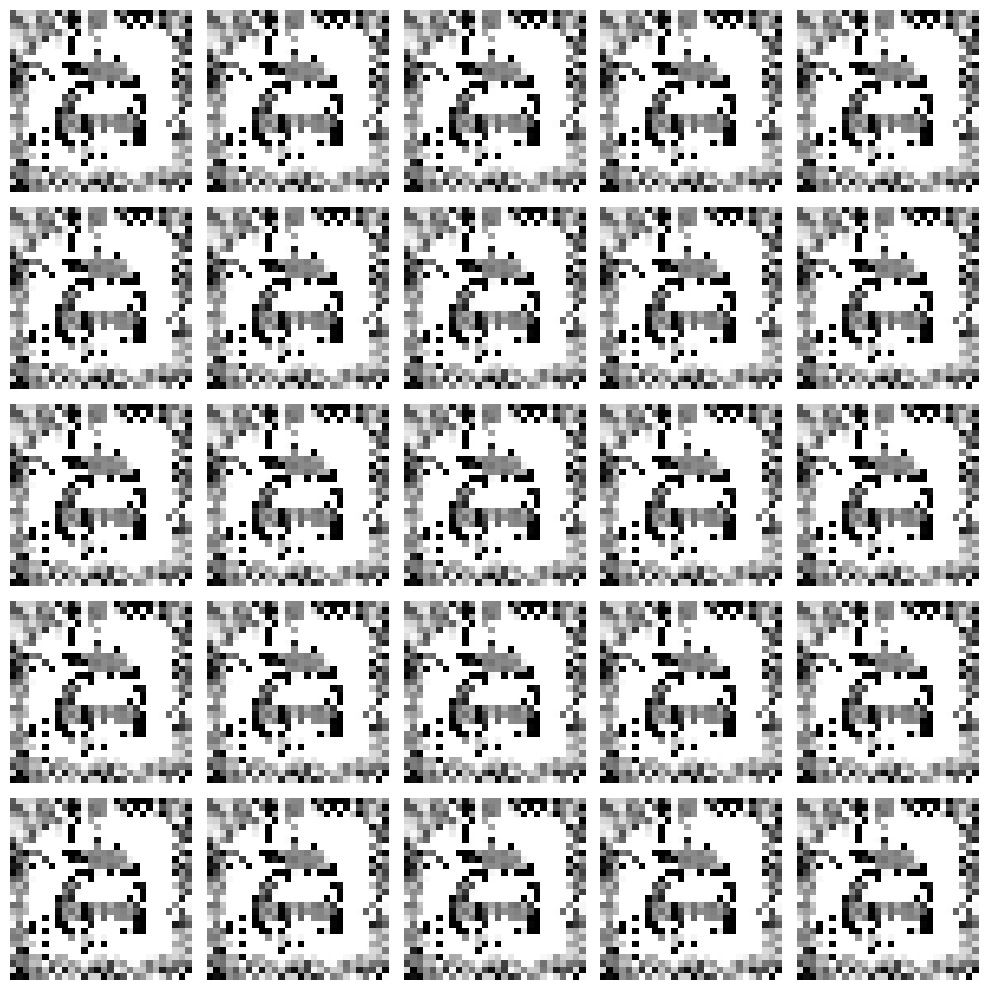

2/2 [==============================] - 0s 4ms/step
2300 [D loss: 8.014966624614317e-06, acc.: 100.0%] [G loss: 3.2684876918792725]
1/1 [==============================] - 0s 19ms/step


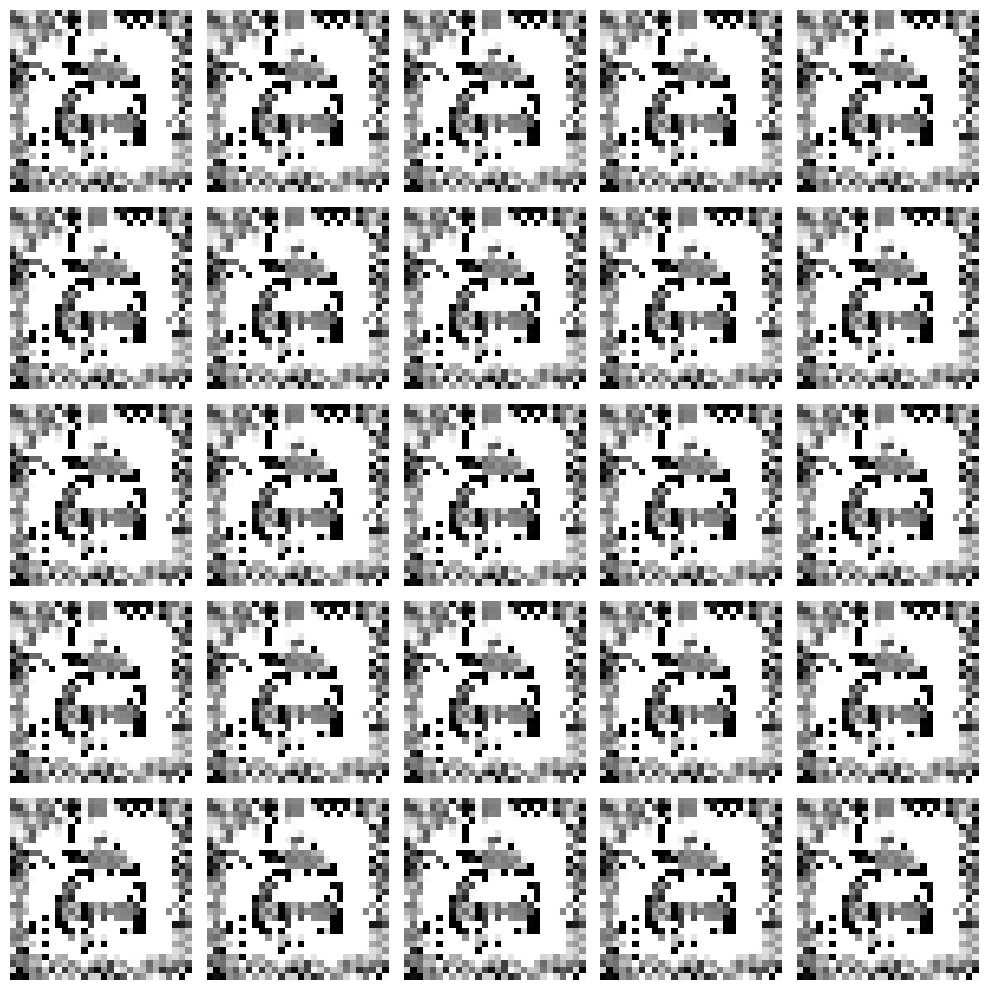

2/2 [==============================] - 0s 5ms/step
2350 [D loss: 6.690801455988549e-05, acc.: 100.0%] [G loss: 3.1431870460510254]
1/1 [==============================] - 0s 18ms/step


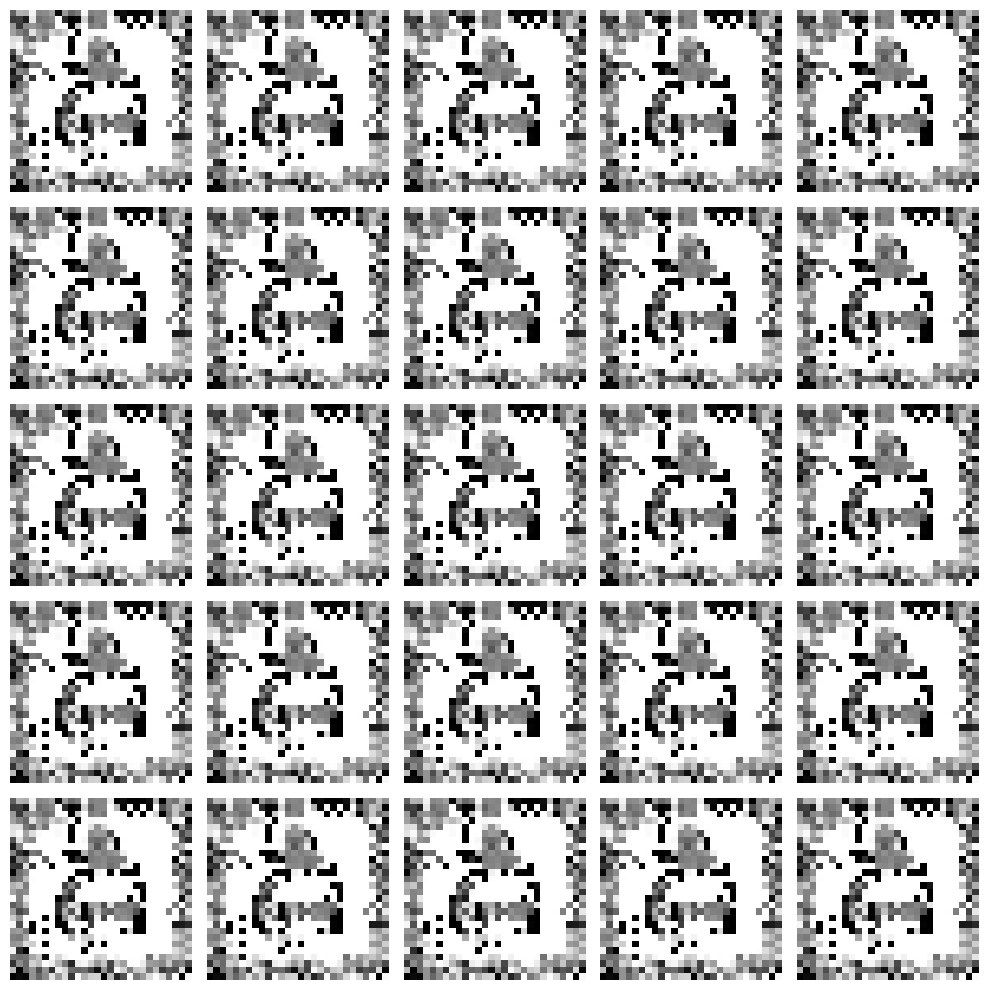

2/2 [==============================] - 0s 4ms/step
2400 [D loss: 2.7283824238111265e-05, acc.: 100.0%] [G loss: 3.3703560829162598]
1/1 [==============================] - 0s 17ms/step


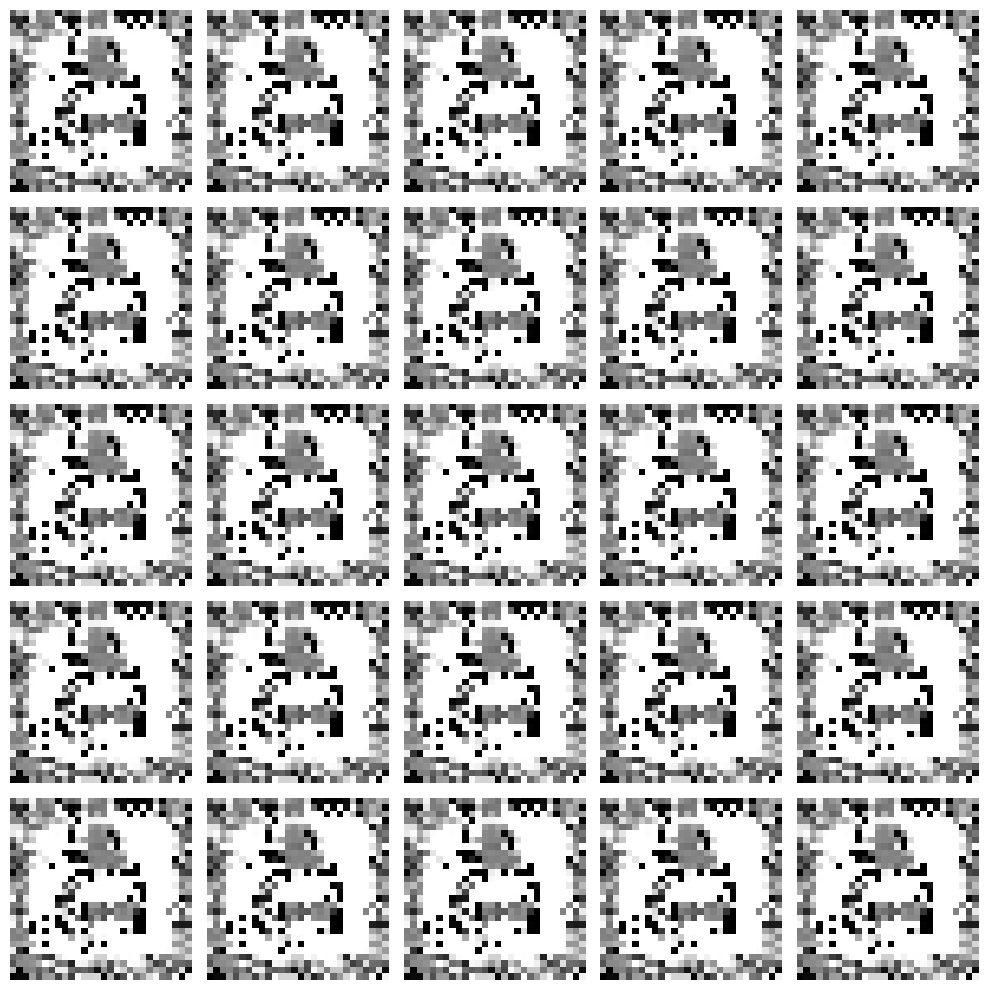

2/2 [==============================] - 0s 4ms/step
2450 [D loss: 1.3656250757776434e-05, acc.: 100.0%] [G loss: 3.8186569213867188]
1/1 [==============================] - 0s 27ms/step


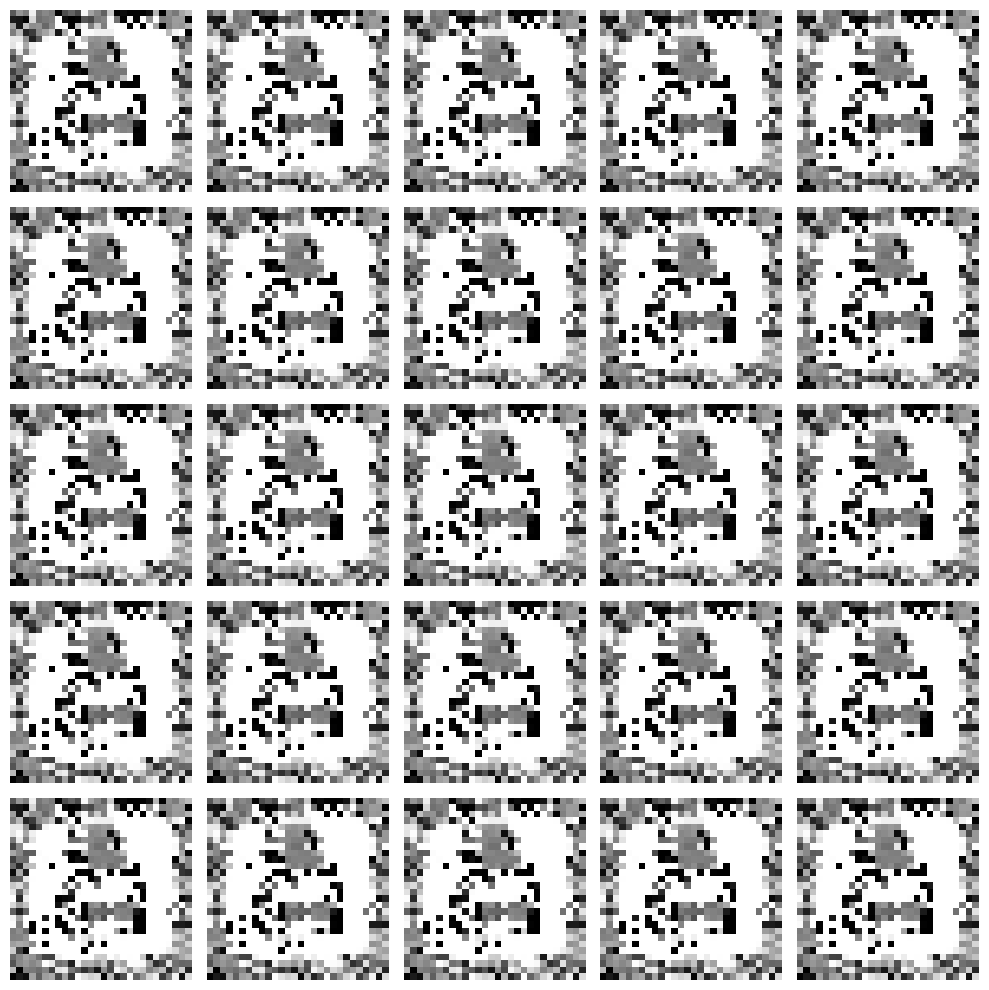

2/2 [==============================] - 0s 4ms/step
2500 [D loss: 2.7347192371962592e-05, acc.: 100.0%] [G loss: 3.917736291885376]
1/1 [==============================] - 0s 18ms/step


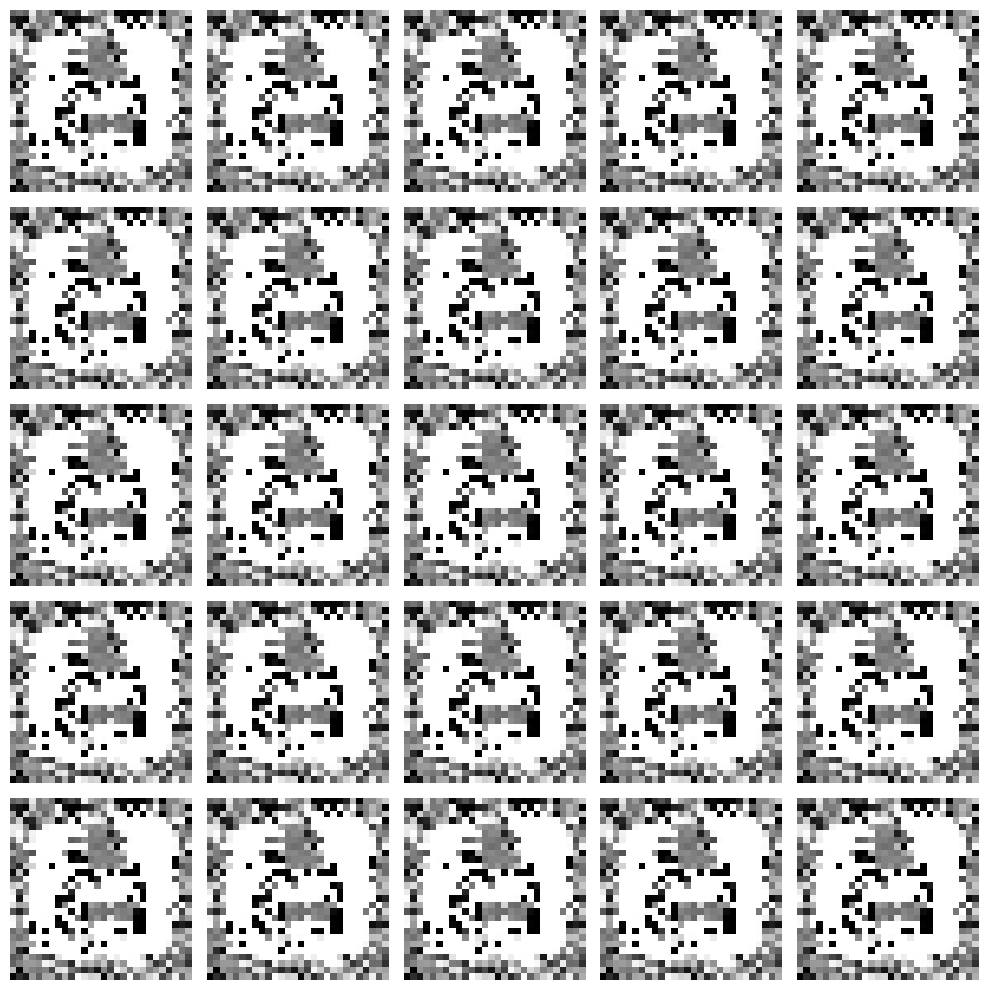

2/2 [==============================] - 0s 4ms/step


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import filters
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Flatten, Dropout, LeakyReLU, BatchNormalization, Embedding, multiply, UpSampling2D, Conv2D, Conv2DTranspose, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

class GAN:
    def __init__(self, images, binary_edges, labels):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.num_classes = len(np.unique(labels))
        self.images = images
        self.binary_edges = binary_edges
        self.labels = labels

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        valid = self.discriminator([img, label])

        # The combined model (stacked generator and discriminator)
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        model_input = multiply([noise, label_embedding])

        x = Dense(128 * 7 * 7, activation="relu")(model_input)
        x = Reshape((7, 7, 128))(x)
        x = UpSampling2D()(x)
        x = Conv2D(128, kernel_size=3, padding="same")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)
        x = UpSampling2D()(x)
        x = Conv2D(64, kernel_size=3, padding="same")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)
        x = Conv2D(self.channels, kernel_size=3, padding="same")(x)
        img = Activation("tanh")(x)

        model = Model([noise, label], img)
        return model

    def build_discriminator(self):
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        label_embedding = Reshape(self.img_shape)(label_embedding)

        combined_input = Concatenate(axis=-1)([img, label_embedding])

        x = Conv2D(64, kernel_size=3, strides=2, padding="same")(combined_input)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.25)(x)
        x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.25)(x)
        x = Conv2D(256, kernel_size=3, strides=2, padding="same")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.25)(x)
        x = Flatten()(x)
        validity = Dense(1, activation='sigmoid')(x)

        model = Model([img, label], validity)
        return model

    def train(self, epochs, batch_size=128, save_interval=50):
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            # Select a random half batch of images
            idx = np.random.randint(0, self.images.shape[0], batch_size)
            imgs = self.images[idx]
            edges_batch = self.binary_edges[idx]
            labels_batch = self.labels[idx]

            # Generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict([noise, labels_batch])

            # Train the discriminator (real classified as 1 and fake as 0)
            d_loss_real = self.discriminator.train_on_batch([imgs, labels_batch], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels_batch], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            # Generate a batch of new noise and labels
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            sampled_labels = np.random.randint(0, self.num_classes, (batch_size, 1))

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # If at save interval, save generated image samples
            if epoch % save_interval == 0:
                print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")
                self.generate_and_plot_images(epoch)

    def generate_and_plot_images(self, epoch):
        noise = np.random.normal(0, 1, (self.num_classes, self.latent_dim))
        labels = np.arange(self.num_classes).reshape(-1, 1)
        generated_images = self.generator.predict([noise, labels])

        fig, axes = plt.subplots(5, 5, figsize=(10, 10))
        for i, ax in enumerate(axes.flatten()):
            if i < self.num_classes:
                ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
                ax.axis('off')
        plt.tight_layout()
        plt.savefig(f'generated_images_epoch_{epoch}.png')
        plt.show()

# Apply a binary threshold to the edge-detected images
thresholded_edges = [filters.threshold_otsu(edge) for edge in edges]
binary_edges = np.array([(edge > threshold).astype(int) for edge, threshold in zip(edges, thresholded_edges)])

# Display some thresholded edge-detected images
fig, axes = plt.subplots(2, 5, figsize=(10, 10))
for i in range(10):
    row, col = divmod(i, 5)
    axes[row, col].imshow(binary_edges[i], cmap='gray')
    axes[row, col].set_title(f'Label: {labels[i]}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

# Instantiate and train the GAN with binary edges and labels
gan = GAN(images, binary_edges, labels)
gan.train(epochs=3000, batch_size=64, save_interval=50)


In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the discriminator
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Make the discriminator not trainable for the combined model
discriminator.trainable = False

# Define the combined model (stacked generator and discriminator)
input_image = Input(shape=image_shape)
input_edge = Input(shape=image_shape)
gen_img = generator([input_image, input_edge])
validity = discriminator([gen_img, input_edge])

combined = Model([input_image, input_edge], validity)
combined.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

In [ ]:
import matplotlib.pyplot as plt

# Plot Discriminator and Generator Loss
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss During Training')
plt.legend()
plt.show()

# Plot Discriminator Accuracy
plt.figure(figsize=(10, 5))
plt.plot(d_accuracies, label='Discriminator Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Discriminator Accuracy During Training')
plt.legend()
plt.show()


In [ ]:
# Generate and plot final images
generate_and_plot_images(generator, input_dim, num_classes)

In [ ]:
print(hog_features)

In [ ]:
print(hog_features.shape)


## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Data Generator with Augmentations
datagen = ImageDataGenerator(
    rotation_range=10,      # Rotate images
    width_shift_range=0.1,  # Shift images horizontally
    height_shift_range=0.1, # Shift images vertically
    zoom_range=0.1,         # Zoom into images
    horizontal_flip=True,   # Flip images horizontally
    fill_mode='nearest'     # Fill in pixels after transformations
)

# Fit the generator on the dataset
datagen.fit(images)

# Example of applying augmentations
augmented_images, _ = next(datagen.flow(images, labels, batch_size=10))

# Plot some augmented images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(augmented_images[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()
